# Hyperparameter Search

Author: Shanel Gauthier
Date: 2021-12-09

The objective of this notebook is to train muliple models and compare their performance. 

For each architecture, a simple hyperparameter search is performed.

In [ ]:
#clone parametric scattering network repo
#! git clone https://github.com/sgaut023/kymatio_mod/

Cloning into 'kymatio_mod'...
remote: Enumerating objects: 9863, done.
remote: Counting objects: 100% (2185/2185), done.
remote: Compressing objects: 100% (767/767), done.


In [ ]:
import torch
from torchvision import datasets
from getpass import getpass
from pprint import pprint
from pathlib import Path 
from sklearn.model_selection import ParameterSampler
from utils import *

import sys
import IPython
import numpy as np
import mlflow
import os
import sys
import warnings
# import kymatio classes
warnings.filterwarnings("ignore")

In [2]:
sys.path.append(str(Path.cwd().parent)+'/kymatio_mod')
sys.path.append(str(Path.cwd().parent))

# 1. Experimental Tracking Tool

For this experiment, we are using an experimental tracking tool called Mlflow.

The metrics are saved in the DAGsHub's servers. Click [here](https://dagshub.com/gauthier.shanel/skin_disease/experiments/#/) to see the hyperparameter search results associated with this notebook.

To run this notebook and save your results [here](https://dagshub.com/gauthier.shanel/skin_disease/experiments/#/), you need to create your DAGsHUB account.

Then, you need to copy your token by clicking on -> Your Setting

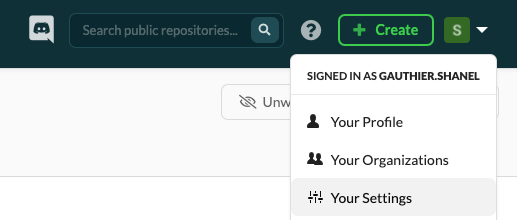

Then, you need to clik on -> Tokens and copy your token

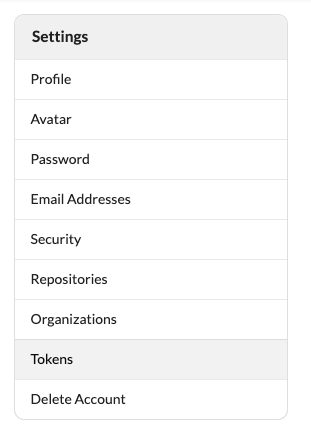

**Set Environment Variables**


In [37]:
#@title Enter the repository name for the project:

REPO_NAME= "skin_disease" #@param {type:"string"}

In [38]:
#@title Enter the repository name for the project:

REPO_OWNER= "gauthier.shanel" #@param {type:"string"}

** Please make sure to change "gauthier.shanel" for YOUR user name in DAGsHub**

In [39]:
#@title Enter the username of your DAGsHub account:

USER_NAME = "gauthier.shanel" #@param {type:"string"}

**Set Local Configurations**

Under the [Token tab](https://dagshub.com/user/settings/tokens) in the user setting, copy the default token and use it here.

In [40]:
os.environ['MLFLOW_TRACKING_USERNAME'] = USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')
mlflow.set_tracking_uri(f'https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow')

KeyboardInterrupt: Interrupted by user

# 2. Create Pytorch Dataset

In this section, we create the pytorch dataset and dataloader.

In [9]:
#Settings and hyperparamerters for this experiment
workers = 4
batch_size=16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Create Dataset
dataset = datasets.ImageFolder(root='data_3class_skin_diseases/', transform=augmentationFactory('augment'))

In the dataset, we normalize the images by the mean and std per channel. Below, you can see how we computed the mean and std per channel.

Mean: [0.6475, 0.4907, 0.4165]
std: [0.1875, 0.1598, 0.1460]

In [12]:
# code from: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def get_mean_std_per_channel(loader):
    nimages = 0
    mean = 0.
    std = 0.
    for batch, _ in loader:
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    # Final step
    mean /= nimages
    std /= nimages
    return mean, std
# create dataloader
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers,pin_memory=True)
get_mean_std_per_channel(loader)

(tensor([0.6475, 0.4907, 0.4165]), tensor([0.1882, 0.1607, 0.1470]))

# 3. Hyperparameter Search

In this section, we consider 4 different architectures: vanilla cnn, pretrained resnet50, big tranfer model from this [paper](https://arxiv.org/abs/1912.11370) and parametric scattering network from this [paper](https://arxiv.org/abs/2107.09539).

For each architecture, we do a simple hyperparameter search.

The next cell allows you to visualize the results from DAGsHub. 
Make sure you followed the instruction of section 1. 



In [ ]:
display(IPython.display.IFrame(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}/experiments/#/",'100%',600))

## 3.1 Vanilla CNN

In [81]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-4,1e-3, 1e-4)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(2,30, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 18, 'lr': 0.0006000000000000001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:14.83497562011083, Test Loss: 20.602964401245117
Epoch 2-- Train Loss:23.964456001917522, Test Loss: 24.20540428161621
Epoch 3-- Train Loss:11.12871960798899, Test Loss: 7.205683708190918
Epoch 4-- Train Loss:2.6986592113970005, Test Loss: 3.7977356910705566
Epoch 5-- Train Loss:3.8727974891662598, Test Loss: 29.49567985534668
Epoch 6-- Train Loss:12.071016589800516, Test Loss: 16.990989685058594
Epoch 7-- Train Loss:4.541417578856151, Test Loss: 52.698883056640625
Epoch 8-- Train Loss:12.521948854119424, Test Loss: 0.24940113723278046
Epoch 9-- Train Loss:1.422837754090627, Test Loss: 17.476686477661133
Epoch 10-- Train Loss:1.1547197198494057, Test Loss: 3.050602436065674
Epoch 11-- Train Loss:1.1525965892360546, Test Loss: 2.174943208694458
Epoch 12-- Train Loss:0.46754601285404834, Test Loss: 3.6261534690856934
Epoch 13-- Train Loss:6.380407337409754, Test 

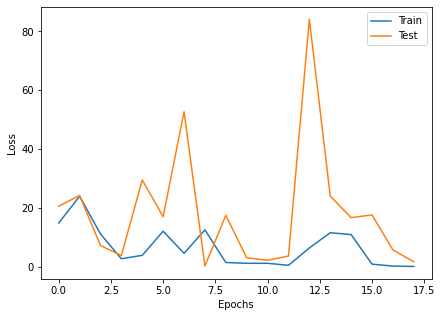

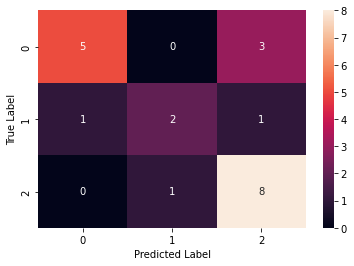

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:22.576192915439606, Test Loss: 42.92252731323242
Epoch 2-- Train Loss:15.71370538075765, Test Loss: 23.08866310119629
Epoch 3-- Train Loss:24.237290223439533, Test Loss: 16.89044761657715
Epoch 4-- Train Loss:13.832703431447348, Test Loss: 24.427066802978516
Epoch 5-- Train Loss:5.738704641660054, Test Loss: 14.695231437683105
Epoch 6-- Train Loss:2.7879174252351127, Test Loss: 4.6819634437561035
Epoch 7-- Train Loss:1.568098021428644, Test Loss: 6.257899761199951
Epoch 8-- Train Loss:0.31802403274923563, Test Loss: 0.5110155344009399
Epoch 9-- Train Loss:0.42483106985067326, Test Loss: 1.2975348234176636
Epoch 10-- Train Loss:2.193865768611431, Test Loss: 37.38546371459961
Epoch 11-- Train Loss:14.251225739717484, Test Loss: 0.22693148255348206
Epoch 12-- Train Loss:0.5239329139391581, Test Loss: 4.03952169418335
Epoch 13-- Train Loss:0.49246234943469364, Test Loss: 8.113544464111328
Epoch 14-- Train Loss:0.

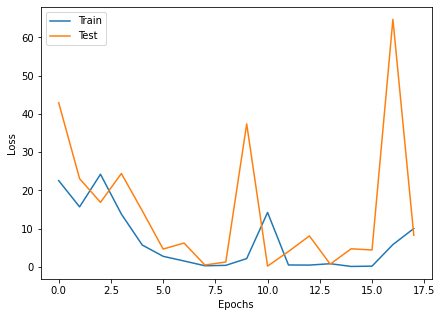

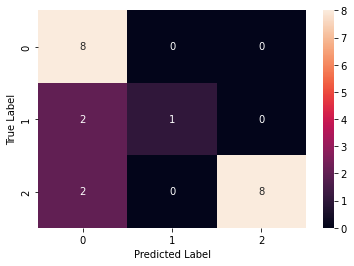

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:23.527909954388935, Test Loss: 70.15656280517578
Epoch 2-- Train Loss:20.57497163613637, Test Loss: 29.946002960205078
Epoch 3-- Train Loss:11.619932174682617, Test Loss: 1.2027069330215454
Epoch 4-- Train Loss:11.499897142251333, Test Loss: 34.22471618652344
Epoch 5-- Train Loss:6.815811527272065, Test Loss: 6.2824907302856445
Epoch 6-- Train Loss:2.2796107303972044, Test Loss: 1.1815348863601685
Epoch 7-- Train Loss:2.544737145411394, Test Loss: 10.443262100219727
Epoch 8-- Train Loss:1.1634993313540083, Test Loss: 4.218282222747803
Epoch 9-- Train Loss:0.9916671266158422, Test Loss: 14.259482383728027
Epoch 10-- Train Loss:2.309330117267867, Test Loss: 0.25594496726989746
Epoch 11-- Train Loss:1.6971495943143964, Test Loss: 39.59164047241211
Epoch 12-- Train Loss:5.590722649523134, Test Loss: 3.5649967193603516
Epoch 13-- Train Loss:0.4833354279398918, Test Loss: 20.39670753479004
Epoch 14-- Train Loss:1.4

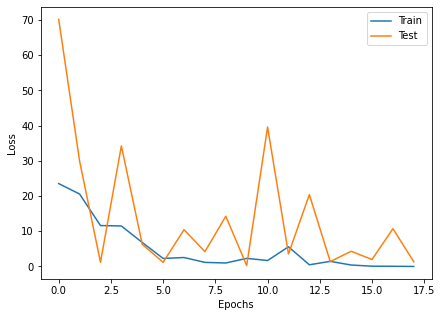

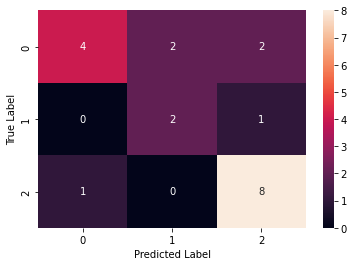

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:17.995556076367695, Test Loss: 33.69646072387695
Epoch 2-- Train Loss:26.840409358342487, Test Loss: 71.082763671875
Epoch 3-- Train Loss:12.50273863474528, Test Loss: 30.458890914916992
Epoch 4-- Train Loss:15.519630710283915, Test Loss: 32.35808181762695
Epoch 5-- Train Loss:18.913035710652668, Test Loss: 14.2379150390625
Epoch 6-- Train Loss:9.39051990287991, Test Loss: 3.473371744155884
Epoch 7-- Train Loss:2.6546814780061445, Test Loss: 5.020379543304443
Epoch 8-- Train Loss:3.499921315393294, Test Loss: 3.587583541870117
Epoch 9-- Train Loss:1.1057101152837276, Test Loss: 4.395010471343994
Epoch 10-- Train Loss:0.7531687002859447, Test Loss: 3.1509900093078613
Epoch 11-- Train Loss:0.36747296285951353, Test Loss: 1.6179288625717163
Epoch 12-- Train Loss:0.24813174842468774, Test Loss: 0.4279630482196808
Epoch 13-- Train Loss:0.21032395364682088, Test Loss: 0.0006503741024062037
Epoch 14-- Train Loss:0.0

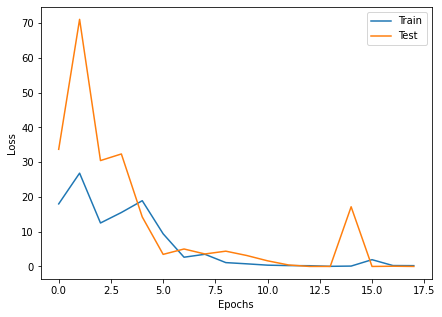

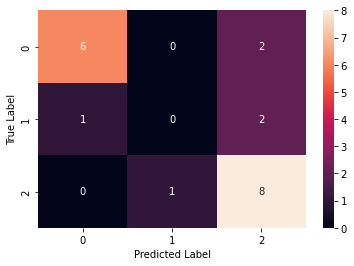

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:15.131161669890085, Test Loss: 0.0
Epoch 2-- Train Loss:15.995742221097336, Test Loss: 15.335518836975098
Epoch 3-- Train Loss:7.769476100802422, Test Loss: 11.49760627746582
Epoch 4-- Train Loss:5.7584832310676575, Test Loss: 25.225862503051758
Epoch 5-- Train Loss:3.6691076954205832, Test Loss: 23.42190933227539
Epoch 6-- Train Loss:6.450722733267715, Test Loss: 3.2758939266204834
Epoch 7-- Train Loss:1.4478254394475887, Test Loss: 13.596173286437988
Epoch 8-- Train Loss:0.8581065436204275, Test Loss: 24.84503936767578
Epoch 9-- Train Loss:0.11911176015322174, Test Loss: 0.021298419684171677
Epoch 10-- Train Loss:0.0957187623619878, Test Loss: 6.868587970733643
Epoch 11-- Train Loss:0.14863650247768115, Test Loss: 9.10596752166748
Epoch 12-- Train Loss:0.07110110257250568, Test Loss: 27.416900634765625
Epoch 13-- Train Loss:0.04488876857794762, Test Loss: 9.00124740600586
Epoch 14-- Train Loss:0.00665216624

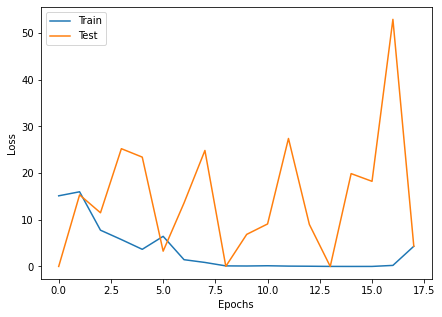

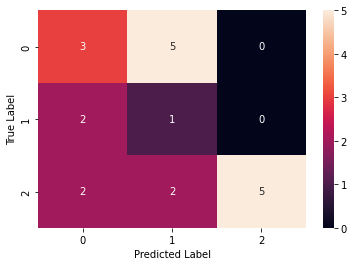

Starting testing
Training Complete
{'0': {'f1-score': '0.671±0.113',
       'precision': '0.751±0.216',
       'recall': '0.65±0.146',
       'support': 8},
 '1': {'f1-score': '0.401±0.129',
       'precision': '0.529±0.273',
       'recall': '0.383±0.145',
       'support': 4},
 '2': {'f1-score': '0.761±0.033',
       'precision': '0.805±0.159',
       'recall': '0.787±0.176',
       'support': 9},
 'accuracy': '0.667±0.097',
 'macro avg': {'f1-score': '0.611±0.085',
               'precision': '0.695±0.117',
               'recall': '0.607±0.084',
               'support': 21},
 'weighted avg': {'f1-score': '0.669±0.076',
                  'precision': '0.743±0.075',
                  'recall': '0.667±0.097',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0001, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:5.434096500233171, Test Loss: 2.3706343173980713
Epoch 2-- Train Loss:2.0836130284393826, Test Loss: 1.311301275563892e-06
Epoch 3-- T

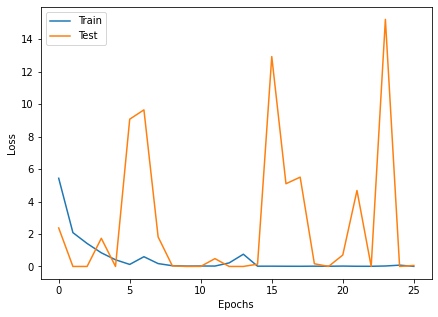

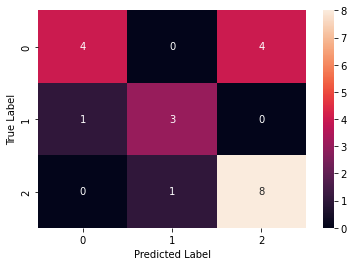

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:5.565731181630066, Test Loss: 0.0015906550688669086
Epoch 2-- Train Loss:3.3382297330314206, Test Loss: 0.0075643532909452915
Epoch 3-- Train Loss:1.197145220083517, Test Loss: 5.831211090087891
Epoch 4-- Train Loss:0.7058068399450609, Test Loss: 0.00400099391117692
Epoch 5-- Train Loss:0.15741300726776467, Test Loss: 0.00031585473334416747
Epoch 6-- Train Loss:0.3246451542869354, Test Loss: 7.748303323751315e-05
Epoch 7-- Train Loss:0.25374519586746047, Test Loss: 0.04877592623233795
Epoch 8-- Train Loss:0.09660421868691282, Test Loss: 0.0026291587855666876
Epoch 9-- Train Loss:0.04449514368094415, Test Loss: 0.09553147107362747
Epoch 10-- Train Loss:0.01652241304483531, Test Loss: 0.0007108307327143848
Epoch 11-- Train Loss:0.029123964833464317, Test Loss: 0.12602591514587402
Epoch 12-- Train Loss:0.02494369542996754, Test Loss: 0.0012738931691274047
Epoch 13-- Train Loss:0.016402278849065106, Test Loss: 0.

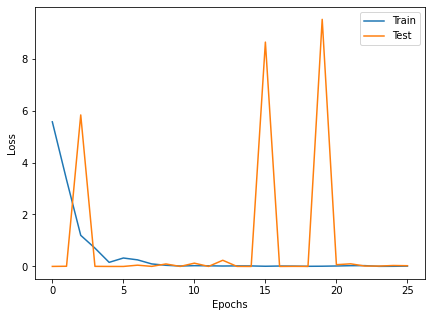

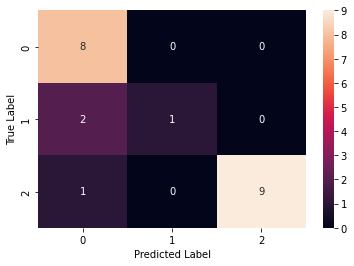

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.940126311211078, Test Loss: 17.62938690185547
Epoch 2-- Train Loss:3.0320258961430575, Test Loss: 2.523991584777832
Epoch 3-- Train Loss:0.859642367178042, Test Loss: 1.5480892658233643
Epoch 4-- Train Loss:1.3449126002725236, Test Loss: 1.7535548210144043
Epoch 5-- Train Loss:0.8061715047224425, Test Loss: 0.00021962517348583788
Epoch 6-- Train Loss:0.35555511791469707, Test Loss: 1.1138737201690674
Epoch 7-- Train Loss:0.4533610153275298, Test Loss: 0.2783510088920593
Epoch 8-- Train Loss:0.024329992541814654, Test Loss: 1.5503103733062744
Epoch 9-- Train Loss:0.04376048561902107, Test Loss: 0.1999194175004959
Epoch 10-- Train Loss:0.04916966374202318, Test Loss: 1.463464617729187
Epoch 11-- Train Loss:0.037868378868941885, Test Loss: 0.004213558044284582
Epoch 12-- Train Loss:0.03436747489052193, Test Loss: 0.0007061108481138945
Epoch 13-- Train Loss:0.026922091381579992, Test Loss: 0.2704322040081024
Ep

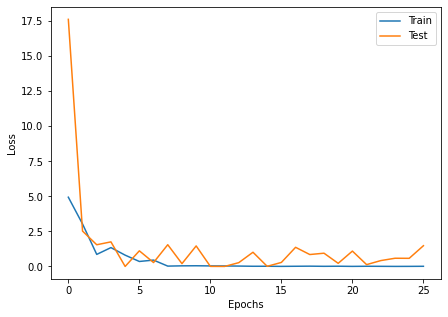

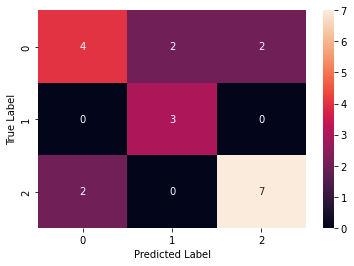

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.880289125434328, Test Loss: 9.766251564025879
Epoch 2-- Train Loss:1.700307182346781, Test Loss: 0.04680273309350014
Epoch 3-- Train Loss:1.2249268902731794, Test Loss: 2.140839099884033
Epoch 4-- Train Loss:1.4931093826889992, Test Loss: 1.3906644582748413
Epoch 5-- Train Loss:0.9460143559762011, Test Loss: 2.5886123180389404
Epoch 6-- Train Loss:0.2954378156545794, Test Loss: 0.663447916507721
Epoch 7-- Train Loss:0.21108703439330428, Test Loss: 0.1103866696357727
Epoch 8-- Train Loss:0.23752465235338605, Test Loss: 0.024443967267870903
Epoch 9-- Train Loss:0.03645667736704387, Test Loss: 0.21506433188915253
Epoch 10-- Train Loss:0.019386006029630413, Test Loss: 0.03461645543575287
Epoch 11-- Train Loss:0.027659081249112205, Test Loss: 0.04417983442544937
Epoch 12-- Train Loss:0.018373001967445037, Test Loss: 0.7053921222686768
Epoch 13-- Train Loss:0.011322037657789354, Test Loss: 0.08261307328939438
Epo

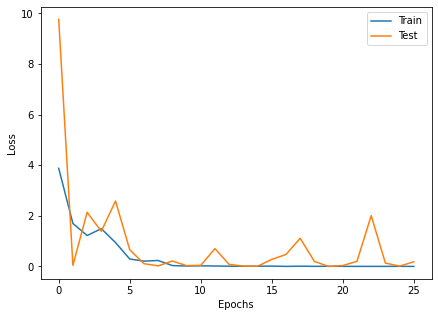

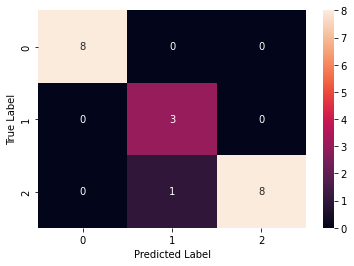

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.2499080016121815, Test Loss: 2.1373393535614014
Epoch 2-- Train Loss:2.0358290442354265, Test Loss: 5.694689750671387
Epoch 3-- Train Loss:1.5521854752940791, Test Loss: 3.9943454265594482
Epoch 4-- Train Loss:0.3278725197638518, Test Loss: 3.0468244552612305
Epoch 5-- Train Loss:0.3756722134733406, Test Loss: 2.00480580329895
Epoch 6-- Train Loss:0.3237206318091402, Test Loss: 1.3495959043502808
Epoch 7-- Train Loss:0.06625886582506132, Test Loss: 0.3869105577468872
Epoch 8-- Train Loss:0.23265636064622544, Test Loss: 0.46974220871925354
Epoch 9-- Train Loss:0.02442192534259188, Test Loss: 0.3676738142967224
Epoch 10-- Train Loss:0.029299851890148904, Test Loss: 2.693638801574707
Epoch 11-- Train Loss:0.036788254775317566, Test Loss: 1.218961238861084
Epoch 12-- Train Loss:0.025287808557983397, Test Loss: 4.395337104797363
Epoch 13-- Train Loss:0.016603595367909986, Test Loss: 0.00661975285038352
Epoch 14-

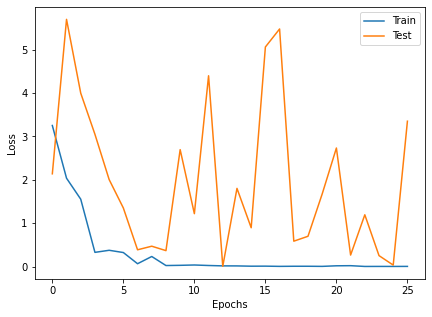

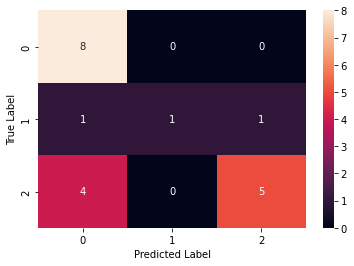

Starting testing
Training Complete
{'0': {'f1-score': '0.73±0.145',
       'precision': '0.734±0.16',
       'recall': '0.775±0.229',
       'support': 8},
 '1': {'f1-score': '0.614±0.337',
       'precision': '0.7±0.367',
       'recall': '0.617±0.393',
       'support': 4},
 '2': {'f1-score': '0.798±0.114',
       'precision': '0.816±0.124',
       'recall': '0.802±0.165',
       'support': 9},
 'accuracy': '0.764±0.103',
 'macro avg': {'f1-score': '0.714±0.141',
               'precision': '0.75±0.165',
               'recall': '0.731±0.128',
               'support': 21},
 'weighted avg': {'f1-score': '0.745±0.117',
                  'precision': '0.769±0.127',
                  'recall': '0.764±0.103',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0007000000000000001, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:22.81275433843786, Test Loss: 14.851936340332031
Epoch 2-- Train Loss:11.161917729811234, Test Loss: 13.595778465270996
Epo

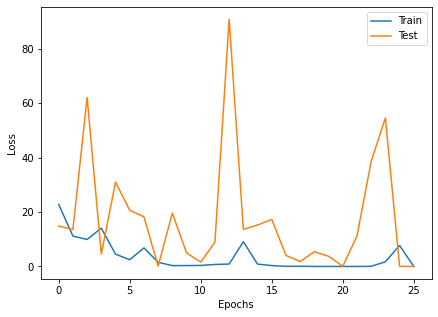

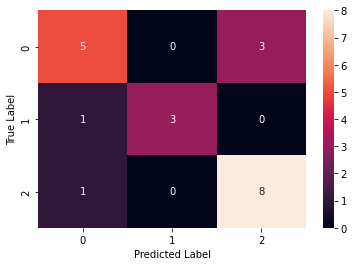

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:19.310629801316693, Test Loss: 1.6219122409820557
Epoch 2-- Train Loss:13.173426368358461, Test Loss: 24.02875518798828
Epoch 3-- Train Loss:11.826947588367727, Test Loss: 8.863362312316895
Epoch 4-- Train Loss:5.284485654397444, Test Loss: 6.787484645843506
Epoch 5-- Train Loss:4.052818055518649, Test Loss: 11.156764030456543
Epoch 6-- Train Loss:2.403472556901926, Test Loss: 0.6564351320266724
Epoch 7-- Train Loss:1.2035850281645666, Test Loss: 12.718863487243652
Epoch 8-- Train Loss:0.3990386274689089, Test Loss: 0.4142172336578369
Epoch 9-- Train Loss:0.3259879518848482, Test Loss: 16.81661605834961
Epoch 10-- Train Loss:0.3723427221085461, Test Loss: 11.149901390075684
Epoch 11-- Train Loss:2.00676780364963, Test Loss: 0.003120279172435403
Epoch 12-- Train Loss:1.0476916413571111, Test Loss: 0.5966852903366089
Epoch 13-- Train Loss:0.031010701733884295, Test Loss: 14.737385749816895
Epoch 14-- Train Loss

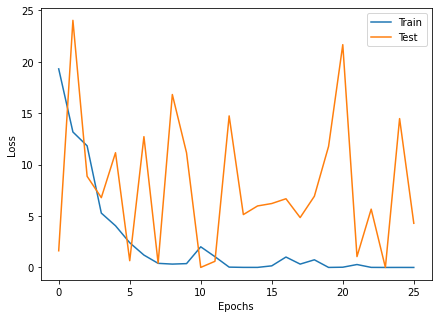

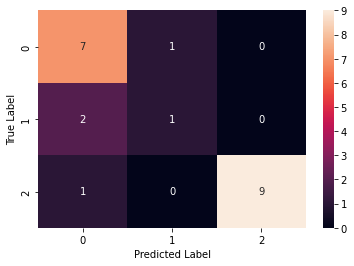

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:22.771355162967335, Test Loss: 25.13228988647461
Epoch 2-- Train Loss:22.63544463478452, Test Loss: 8.167078971862793
Epoch 3-- Train Loss:3.157989222524603, Test Loss: 5.269038200378418
Epoch 4-- Train Loss:6.068696749481288, Test Loss: 11.544976234436035
Epoch 5-- Train Loss:7.595675327561119, Test Loss: 26.03386688232422
Epoch 6-- Train Loss:7.3563387243279355, Test Loss: 3.7869150638580322
Epoch 7-- Train Loss:1.8557506762616531, Test Loss: 0.38354262709617615
Epoch 8-- Train Loss:0.7941468290512096, Test Loss: 21.404090881347656
Epoch 9-- Train Loss:1.730744562684177, Test Loss: 0.011679603718221188
Epoch 10-- Train Loss:0.10799709903573416, Test Loss: 3.6730148792266846
Epoch 11-- Train Loss:0.6922329174670714, Test Loss: 2.533575207053218e-05
Epoch 12-- Train Loss:0.7379905422767944, Test Loss: 0.0
Epoch 13-- Train Loss:0.01560132085447014, Test Loss: 3.900759696960449
Epoch 14-- Train Loss:0.311770921

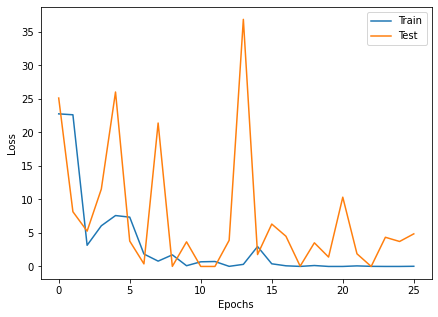

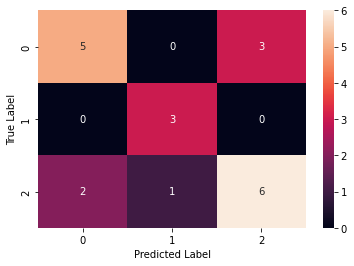

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:14.198468381708318, Test Loss: 16.564294815063477
Epoch 2-- Train Loss:8.711349178665676, Test Loss: 16.15514373779297
Epoch 3-- Train Loss:13.197261875325983, Test Loss: 6.387543678283691
Epoch 4-- Train Loss:10.984893514244256, Test Loss: 18.70136260986328
Epoch 5-- Train Loss:11.442410268566825, Test Loss: 31.13215446472168
Epoch 6-- Train Loss:5.2093593862770255, Test Loss: 11.387978553771973
Epoch 7-- Train Loss:1.0057751570514022, Test Loss: 6.839578628540039
Epoch 8-- Train Loss:2.3336396193353206, Test Loss: 26.704376220703125
Epoch 9-- Train Loss:1.6115474142302033, Test Loss: 2.5755743990885094e-06
Epoch 10-- Train Loss:0.2266093096891795, Test Loss: 0.005449254065752029
Epoch 11-- Train Loss:0.19961281081351656, Test Loss: 7.4081349339394365e-06
Epoch 12-- Train Loss:0.13225633562443628, Test Loss: 6.3784637451171875
Epoch 13-- Train Loss:0.2438439203592802, Test Loss: 19.535335540771484
Epoch 14--

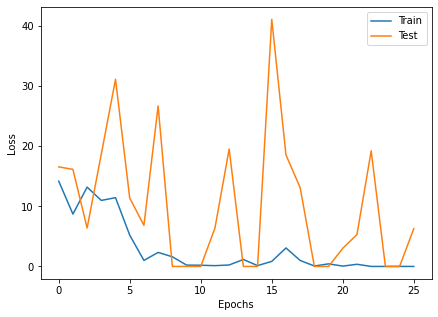

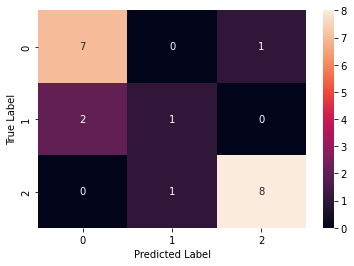

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:23.214471751993354, Test Loss: 13.105443954467773
Epoch 2-- Train Loss:9.526900537989356, Test Loss: 51.6890983581543
Epoch 3-- Train Loss:10.091504833915018, Test Loss: 19.268823623657227
Epoch 4-- Train Loss:3.036816796118563, Test Loss: 73.6788330078125
Epoch 5-- Train Loss:7.560777237794983, Test Loss: 13.079243659973145
Epoch 6-- Train Loss:3.318051171778026, Test Loss: 4.870923042297363
Epoch 7-- Train Loss:0.7724543448057601, Test Loss: 14.740324974060059
Epoch 8-- Train Loss:1.6351664508269592, Test Loss: 1.2605160474777222
Epoch 9-- Train Loss:4.33381559361111, Test Loss: 4.692018032073975
Epoch 10-- Train Loss:0.18800543892373092, Test Loss: 16.848886489868164
Epoch 11-- Train Loss:0.30229047634741785, Test Loss: 3.128079414367676
Epoch 12-- Train Loss:0.11794287681029586, Test Loss: 29.654600143432617
Epoch 13-- Train Loss:0.024512562138109848, Test Loss: 5.5285461542098346e-08
Epoch 14-- Train Los

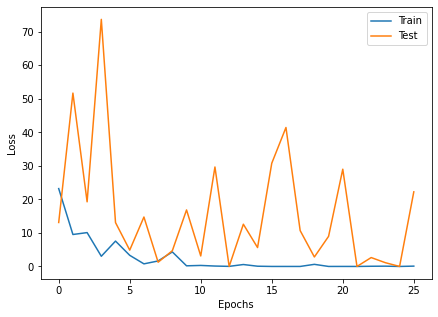

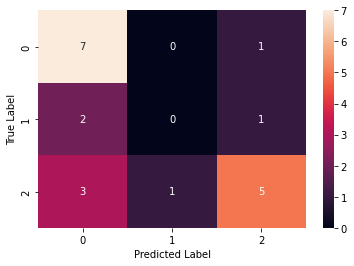

Starting testing
Training Complete
{'0': {'f1-score': '0.701±0.108',
       'precision': '0.685±0.054',
       'recall': '0.75±0.209',
       'support': 8},
 '1': {'f1-score': '0.503±0.324',
       'precision': '0.55±0.332',
       'recall': '0.483±0.351',
       'support': 4},
 '2': {'f1-score': '0.779±0.123',
       'precision': '0.798±0.146',
       'recall': '0.78±0.142',
       'support': 9},
 'accuracy': '0.725±0.069',
 'macro avg': {'f1-score': '0.661±0.093',
               'precision': '0.678±0.103',
               'recall': '0.671±0.077',
               'support': 21},
 'weighted avg': {'f1-score': '0.71±0.079',
                  'precision': '0.72±0.075',
                  'recall': '0.725±0.069',
                  'support': 21}}
{'num_epochs': 18, 'lr': 0.0007000000000000001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:17.08117268482844, Test Loss: 23.533405303955078
Epoch 2-- Train Loss:19.376420656840008, Test Loss: 13.70435905456543
Epo

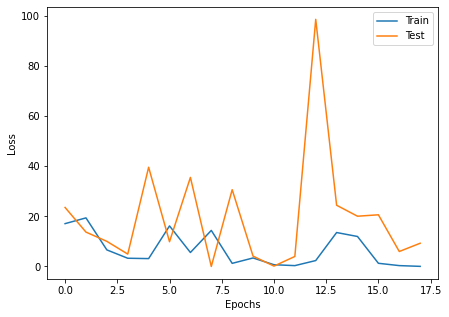

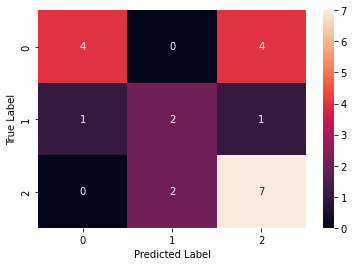

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:25.94160681962967, Test Loss: 48.68276596069336
Epoch 2-- Train Loss:18.23030153910319, Test Loss: 25.216947555541992
Epoch 3-- Train Loss:21.55200469493866, Test Loss: 21.893407821655273
Epoch 4-- Train Loss:18.535629908243816, Test Loss: 33.729209899902344
Epoch 5-- Train Loss:6.437748114267985, Test Loss: 17.46828842163086
Epoch 6-- Train Loss:2.7430567940076194, Test Loss: 7.877059459686279
Epoch 7-- Train Loss:2.440691277384758, Test Loss: 10.665400505065918
Epoch 8-- Train Loss:2.2104099839925766, Test Loss: 0.03930874168872833
Epoch 9-- Train Loss:0.2769340851000379, Test Loss: 2.8299384117126465
Epoch 10-- Train Loss:2.0286681552339965, Test Loss: 41.44314193725586
Epoch 11-- Train Loss:14.84067408243815, Test Loss: 0.005765122827142477
Epoch 12-- Train Loss:0.5932459160685539, Test Loss: 4.920825481414795
Epoch 13-- Train Loss:0.3603244076136889, Test Loss: 7.789449691772461
Epoch 14-- Train Loss:0.5

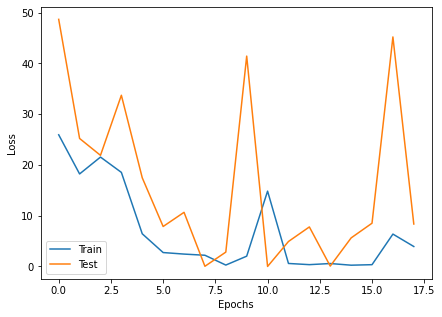

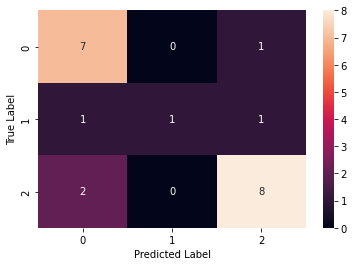

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:26.888345917065937, Test Loss: 78.03092193603516
Epoch 2-- Train Loss:22.956286549568176, Test Loss: 34.45304489135742
Epoch 3-- Train Loss:13.992546558380127, Test Loss: 5.147427082061768
Epoch 4-- Train Loss:16.101831912994385, Test Loss: 35.08517837524414
Epoch 5-- Train Loss:12.598899702231089, Test Loss: 23.22519874572754
Epoch 6-- Train Loss:8.590551495552063, Test Loss: 26.40656852722168
Epoch 7-- Train Loss:10.86738563157894, Test Loss: 16.531326293945312
Epoch 8-- Train Loss:4.376152687159522, Test Loss: 4.28563117980957
Epoch 9-- Train Loss:0.8562851262589296, Test Loss: 9.228754997253418
Epoch 10-- Train Loss:5.305767297744751, Test Loss: 19.306726455688477
Epoch 11-- Train Loss:2.6659273778398833, Test Loss: 36.25355529785156
Epoch 12-- Train Loss:4.835556425134655, Test Loss: 1.9473230838775635
Epoch 13-- Train Loss:0.2617940669207428, Test Loss: 3.786576986312866
Epoch 14-- Train Loss:0.45263441

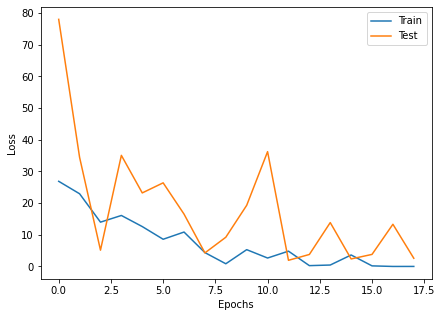

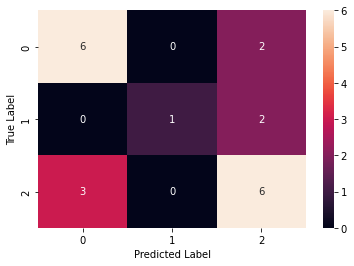

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:20.58783503373464, Test Loss: 39.224605560302734
Epoch 2-- Train Loss:30.03880039850871, Test Loss: 86.39058685302734
Epoch 3-- Train Loss:17.58573325475057, Test Loss: 33.52543640136719
Epoch 4-- Train Loss:14.126523534456888, Test Loss: 36.182743072509766
Epoch 5-- Train Loss:25.932143370310467, Test Loss: 15.065438270568848
Epoch 6-- Train Loss:9.535974462827047, Test Loss: 4.500993728637695
Epoch 7-- Train Loss:1.6636032462120056, Test Loss: 1.904711365699768
Epoch 8-- Train Loss:3.423779025518646, Test Loss: 3.6225123405456543
Epoch 9-- Train Loss:1.3070030250310083, Test Loss: 2.3507566452026367
Epoch 10-- Train Loss:0.7698474352558454, Test Loss: 0.7654411196708679
Epoch 11-- Train Loss:0.6175520902930126, Test Loss: 1.1678569316864014
Epoch 12-- Train Loss:0.5817482411606155, Test Loss: 24.064149856567383
Epoch 13-- Train Loss:2.349023523286936, Test Loss: 32.397727966308594
Epoch 14-- Train Loss:7.27

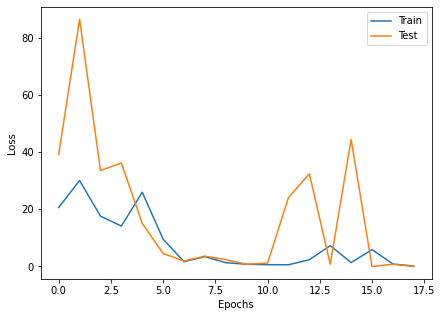

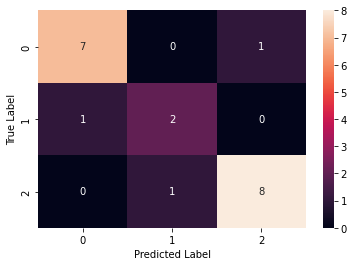

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:17.568267186482746, Test Loss: 0.0
Epoch 2-- Train Loss:14.272380113601685, Test Loss: 27.14473533630371
Epoch 3-- Train Loss:9.69626717052112, Test Loss: 4.842234134674072
Epoch 4-- Train Loss:3.351365089416504, Test Loss: 65.75961303710938
Epoch 5-- Train Loss:18.73086444536845, Test Loss: 25.887540817260742
Epoch 6-- Train Loss:6.715407793575953, Test Loss: 0.11151491105556488
Epoch 7-- Train Loss:1.779951345675272, Test Loss: 16.66236114501953
Epoch 8-- Train Loss:0.6438094675540924, Test Loss: 36.391998291015625
Epoch 9-- Train Loss:0.3277437225721466, Test Loss: 0.010938315652310848
Epoch 10-- Train Loss:0.16921274608466774, Test Loss: 10.593913078308105
Epoch 11-- Train Loss:0.08061087884319325, Test Loss: 21.288408279418945
Epoch 12-- Train Loss:0.5356397857928338, Test Loss: 39.70759963989258
Epoch 13-- Train Loss:0.14284992446331066, Test Loss: 8.837084770202637
Epoch 14-- Train Loss:0.0076712758436

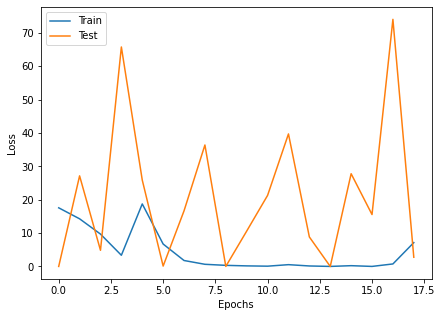

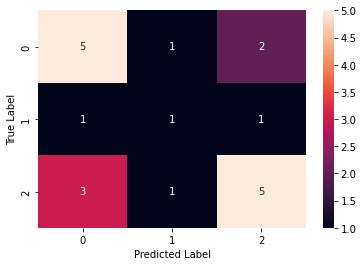

Starting testing
Training Complete
{'0': {'f1-score': '0.614±0.181',
       'precision': '0.612±0.144',
       'recall': '0.625±0.224',
       'support': 8},
 '1': {'f1-score': '0.313±0.218',
       'precision': '0.323±0.234',
       'recall': '0.317±0.213',
       'support': 4},
 '2': {'f1-score': '0.731±0.119',
       'precision': '0.733±0.166',
       'recall': '0.74±0.085',
       'support': 9},
 'accuracy': '0.628±0.148',
 'macro avg': {'f1-score': '0.553±0.168',
               'precision': '0.556±0.175',
               'recall': '0.561±0.16',
               'support': 21},
 'weighted avg': {'f1-score': '0.62±0.156',
                  'precision': '0.622±0.164',
                  'recall': '0.628±0.148',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.0008, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:27.370760321617126, Test Loss: 32.71680450439453
Epoch 2-- Train Loss:11.915194294669412, Test Loss: 7.696902275085449
Epoch 3-- Train L

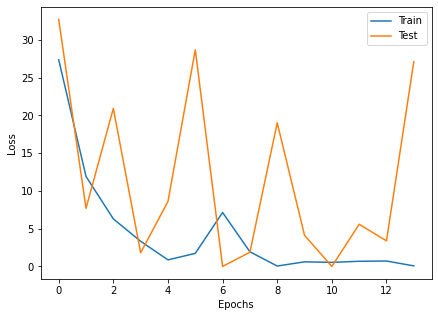

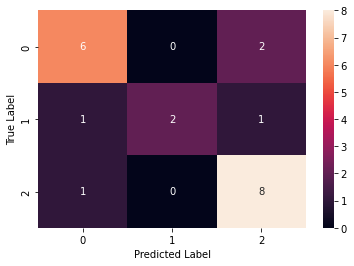

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:22.51239853555506, Test Loss: 26.804832458496094
Epoch 2-- Train Loss:14.849236141551625, Test Loss: 107.55430603027344
Epoch 3-- Train Loss:18.165345647118308, Test Loss: 5.898932456970215
Epoch 4-- Train Loss:2.6665726862847805, Test Loss: 25.3705997467041
Epoch 5-- Train Loss:4.948985197327354, Test Loss: 36.57582473754883
Epoch 6-- Train Loss:9.234738863327287, Test Loss: 13.172436714172363
Epoch 7-- Train Loss:2.2683120323723744, Test Loss: 7.089029312133789
Epoch 8-- Train Loss:0.44572494316492917, Test Loss: 1.1694719791412354
Epoch 9-- Train Loss:0.5751635575911936, Test Loss: 8.258698463439941
Epoch 10-- Train Loss:0.4729079912548183, Test Loss: 2.058015823364258
Epoch 11-- Train Loss:0.7272431864711725, Test Loss: 6.4952192306518555
Epoch 12-- Train Loss:0.6438522550557686, Test Loss: 0.0
Epoch 13-- Train Loss:0.09897930194269251, Test Loss: 2.4243216514587402
Epoch 14-- Train Loss:0.139183737221314

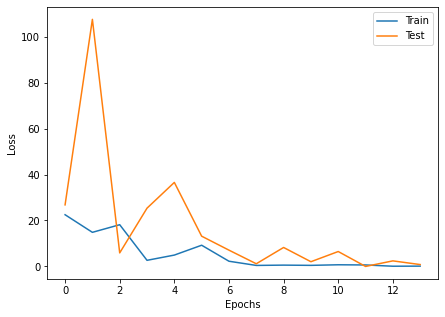

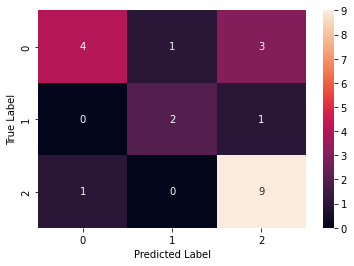

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:22.087477109648965, Test Loss: 37.80642318725586
Epoch 2-- Train Loss:16.397154549136758, Test Loss: 17.9265079498291
Epoch 3-- Train Loss:9.20434713916091, Test Loss: 9.308344841003418
Epoch 4-- Train Loss:4.354276359081268, Test Loss: 8.417181015014648
Epoch 5-- Train Loss:2.7298121318389432, Test Loss: 16.67641830444336
Epoch 6-- Train Loss:5.243318118801519, Test Loss: 6.4753031730651855
Epoch 7-- Train Loss:1.5259591860151638, Test Loss: 1.662113904953003
Epoch 8-- Train Loss:3.0766205983959067, Test Loss: 0.0
Epoch 9-- Train Loss:3.4157549316278657, Test Loss: 1.3179892301559448
Epoch 10-- Train Loss:1.0935040388974977, Test Loss: 21.0550479888916
Epoch 11-- Train Loss:3.9953855082714487, Test Loss: 7.286447048187256
Epoch 12-- Train Loss:1.3266620126503932, Test Loss: 5.194606304168701
Epoch 13-- Train Loss:0.0848198661253796, Test Loss: 0.011659127660095692
Epoch 14-- Train Loss:1.0771341475756757, Te

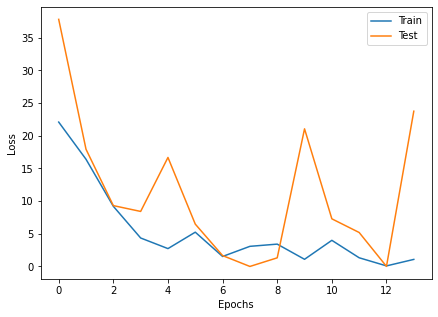

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:21.49950035051866, Test Loss: 126.0076904296875
Epoch 2-- Train Loss:26.784501162442293, Test Loss: 95.7547607421875
Epoch 3-- Train Loss:21.83338900587775, Test Loss: 2.3587536811828613
Epoch 4-- Train Loss:8.520265224982392, Test Loss: 55.22544860839844
Epoch 5-- Train Loss:10.520527021366764, Test Loss: 7.963538646697998
Epoch 6-- Train Loss:8.042849652651057, Test Loss: 10.404261589050293
Epoch 7-- Train Loss:4.378562254946536, Test Loss: 3.387173652648926
Epoch 8-- Train Loss:1.3739385749774804, Test Loss: 0.10180430114269257
Epoch 9-- Train Loss:1.5668234633400986, Test Loss: 30.380348205566406
Epoch 10-- Train Loss:1.2917883622242499, Test Loss: 12.040501594543457
Epoch 11-- Train Loss:0.45965562040560765, Test Loss: 1.690215867711231e-05
Epoch 12-- Train Loss:0.15735638669423685, Test Loss: 0.0022840688470751047
Epoch 13-- Train Loss:0.1419839967485073, Test Loss: 7.186026096343994
Epoch 14-- Train Lo

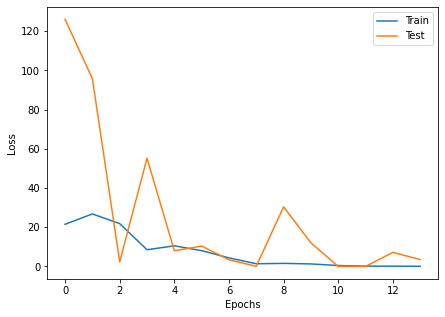

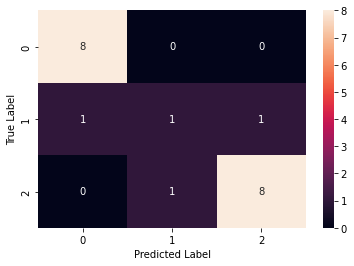

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:14.025893135504289, Test Loss: 40.83993911743164
Epoch 2-- Train Loss:15.142958272587169, Test Loss: 48.61009979248047
Epoch 3-- Train Loss:9.347690163169649, Test Loss: 19.81572723388672
Epoch 4-- Train Loss:3.7022790957072917, Test Loss: 10.917143821716309
Epoch 5-- Train Loss:4.406172166477042, Test Loss: 25.581031799316406
Epoch 6-- Train Loss:5.898808465906603, Test Loss: 1.607177972793579
Epoch 7-- Train Loss:6.060204291755165, Test Loss: 0.14888592064380646
Epoch 8-- Train Loss:2.292091027922032, Test Loss: 6.316395282745361
Epoch 9-- Train Loss:0.7319051093760539, Test Loss: 57.93919372558594
Epoch 10-- Train Loss:1.1861323554634593, Test Loss: 12.960517883300781
Epoch 11-- Train Loss:0.012035351353203034, Test Loss: 10.82888126373291
Epoch 12-- Train Loss:1.2194594788830024e-05, Test Loss: 30.792049407958984
Epoch 13-- Train Loss:4.136162640138769e-05, Test Loss: 7.7468791007995605
Epoch 14-- Train L

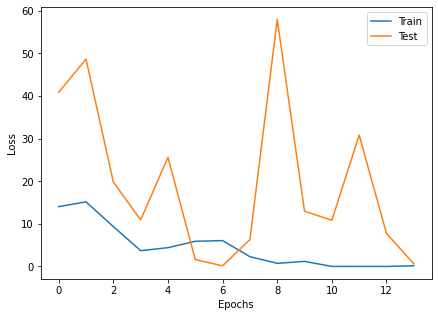

Starting testing
Training Complete
{'0': {'f1-score': '0.701±0.183',
       'precision': '0.859±0.085',
       'recall': '0.65±0.255',
       'support': 8},
 '1': {'f1-score': '0.42±0.151',
       'precision': '0.407±0.193',
       'recall': '0.567±0.249',
       'support': 4},
 '2': {'f1-score': '0.674±0.344',
       'precision': '0.668±0.342',
       'recall': '0.691±0.362',
       'support': 9},
 'accuracy': '0.655±0.214',
 'macro avg': {'f1-score': '0.599±0.194',
               'precision': '0.645±0.14',
               'recall': '0.636±0.125',
               'support': 21},
 'weighted avg': {'f1-score': '0.645±0.229',
                  'precision': '0.702±0.145',
                  'recall': '0.655±0.214',
                  'support': 21}}
{'num_epochs': 6, 'lr': 0.0009000000000000001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:21.37077711025874, Test Loss: 29.344465255737305
Epoch 2-- Train Loss:22.703934987386067, Test Loss: 21.416288375854492
E

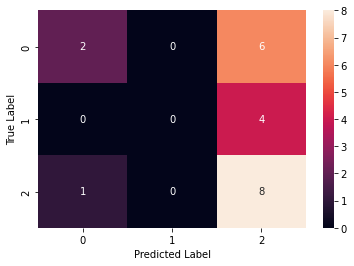

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:16.315745910008747, Test Loss: 99.426025390625
Epoch 2-- Train Loss:33.41328322887421, Test Loss: 71.6002426147461
Epoch 3-- Train Loss:23.229523022969563, Test Loss: 99.11365509033203
Epoch 4-- Train Loss:20.218687375386555, Test Loss: 8.171334266662598
Epoch 5-- Train Loss:4.5631173600753145, Test Loss: 19.59207534790039
Epoch 6-- Train Loss:4.138033489386241, Test Loss: 20.27922821044922


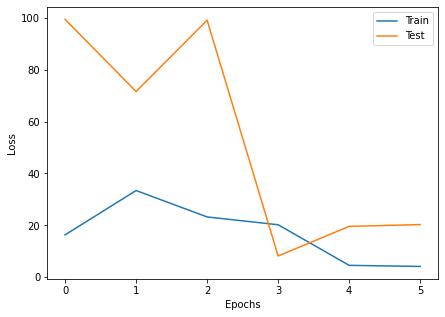

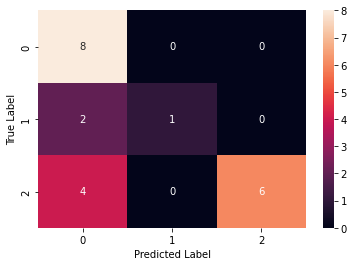

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:19.85719907247403, Test Loss: 39.29193878173828
Epoch 2-- Train Loss:17.856521288553875, Test Loss: 14.180007934570312
Epoch 3-- Train Loss:13.058704536932225, Test Loss: 2.9295601844787598
Epoch 4-- Train Loss:7.497272213300069, Test Loss: 29.060949325561523
Epoch 5-- Train Loss:10.400580525398254, Test Loss: 17.59747886657715
Epoch 6-- Train Loss:3.410335721598434, Test Loss: 4.236244201660156


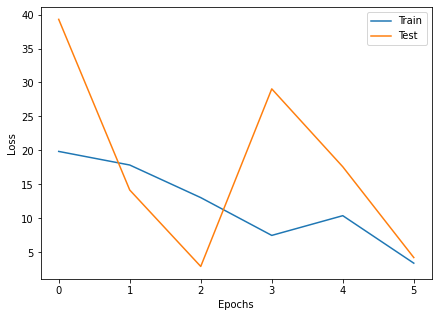

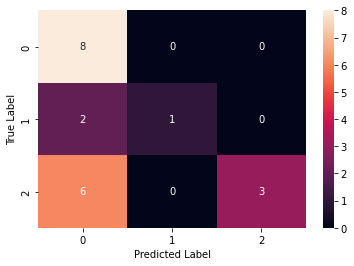

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:17.702440977096558, Test Loss: 76.44143676757812
Epoch 2-- Train Loss:25.103265285491943, Test Loss: 62.14335632324219
Epoch 3-- Train Loss:14.414668281873068, Test Loss: 0.00173378165345639
Epoch 4-- Train Loss:8.235747337341309, Test Loss: 17.887250900268555
Epoch 5-- Train Loss:11.969253540039062, Test Loss: 49.87586212158203
Epoch 6-- Train Loss:10.12745514077445, Test Loss: 6.955880165100098


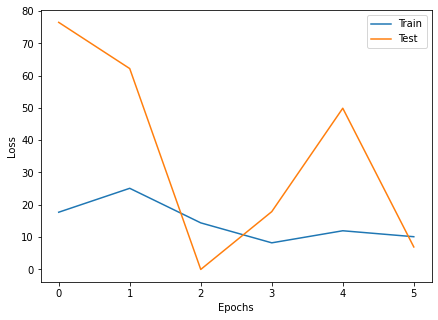

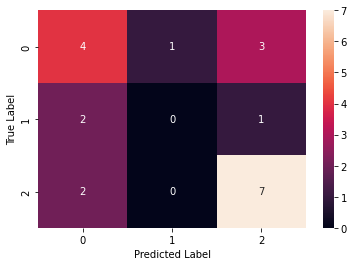

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:22.127427001794178, Test Loss: 21.227291107177734
Epoch 2-- Train Loss:16.10554790496826, Test Loss: 27.652482986450195
Epoch 3-- Train Loss:16.297329485416395, Test Loss: 18.393938064575195
Epoch 4-- Train Loss:5.965506474177043, Test Loss: 20.234251022338867
Epoch 5-- Train Loss:7.368496576944987, Test Loss: 16.247539520263672
Epoch 6-- Train Loss:2.5149483781230324, Test Loss: 6.430737018585205


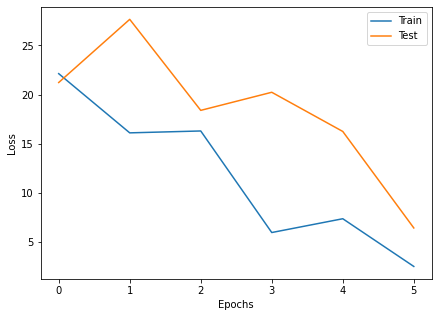

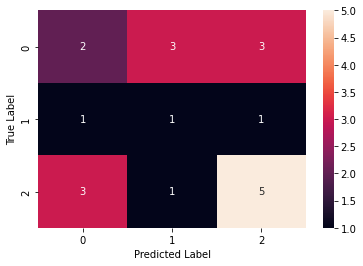

Starting testing
Training Complete
{'0': {'f1-score': '0.594±0.16',
       'precision': '0.544±0.068',
       'recall': '0.725±0.3',
       'support': 8},
 '1': {'f1-score': '0.344±0.203',
       'precision': '0.633±0.452',
       'recall': '0.267±0.133',
       'support': 4},
 '2': {'f1-score': '0.659±0.169',
       'precision': '0.836±0.194',
       'recall': '0.629±0.23',
       'support': 9},
 'accuracy': '0.608±0.123',
 'macro avg': {'f1-score': '0.532±0.143',
               'precision': '0.671±0.22',
               'recall': '0.54±0.115',
               'support': 21},
 'weighted avg': {'f1-score': '0.583±0.142',
                  'precision': '0.686±0.17',
                  'recall': '0.608±0.123',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.0002, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.399681528409322, Test Loss: 4.01616096496582
Epoch 2-- Train Loss:2.7691367864608765, Test Loss: 18.227651596069336
Epoch 3-- Train Loss:

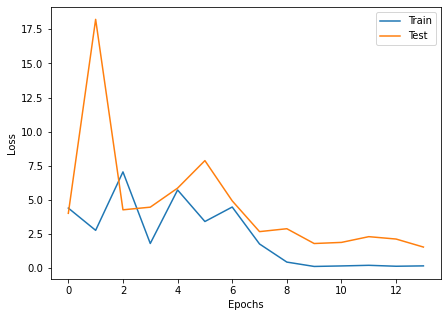

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.3155494133631387, Test Loss: 4.043296813964844
Epoch 2-- Train Loss:5.923967679341634, Test Loss: 3.9575037956237793
Epoch 3-- Train Loss:3.7478838761647544, Test Loss: 2.81997013092041
Epoch 4-- Train Loss:4.45164422194163, Test Loss: 6.701615333557129
Epoch 5-- Train Loss:5.980390310287476, Test Loss: 6.0411481857299805
Epoch 6-- Train Loss:3.2891701459884644, Test Loss: 1.2032123804092407
Epoch 7-- Train Loss:0.6190206607182821, Test Loss: 2.4030561447143555
Epoch 8-- Train Loss:1.6209492286046345, Test Loss: 3.214366912841797
Epoch 9-- Train Loss:1.0869629283746083, Test Loss: 1.48428475856781
Epoch 10-- Train Loss:0.22424795230229697, Test Loss: 1.4877986907958984
Epoch 11-- Train Loss:0.16867139687140784, Test Loss: 1.3627585172653198
Epoch 12-- Train Loss:0.09179737667242686, Test Loss: 1.0076793432235718
Epoch 13-- Train Loss:0.09501754616697629, Test Loss: 0.8773171901702881
Epoch 14-- Train Loss:0

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:6.044020255406697, Test Loss: 2.175837993621826
Epoch 2-- Train Loss:2.39297616481781, Test Loss: 5.018950462341309
Epoch 3-- Train Loss:4.39246129989624, Test Loss: 10.106586456298828
Epoch 4-- Train Loss:3.2890155712763467, Test Loss: 3.779914379119873
Epoch 5-- Train Loss:3.5215245882670083, Test Loss: 5.511815071105957
Epoch 6-- Train Loss:2.9365479151407876, Test Loss: 2.47198748588562
Epoch 7-- Train Loss:1.5942762692769368, Test Loss: 2.2181432247161865
Epoch 8-- Train Loss:1.6060574054718018, Test Loss: 5.66386604309082
Epoch 9-- Train Loss:1.847012460231781, Test Loss: 1.2174174785614014
Epoch 10-- Train Loss:0.2741992101073265, Test Loss: 0.9848167896270752
Epoch 11-- Train Loss:0.14400208741426468, Test Loss: 0.9093694090843201
Epoch 12-- Train Loss:0.08034365934630235, Test Loss: 0.7966197729110718
Epoch 13-- Train Loss:0.05576181039214134, Test Loss: 0.9281231760978699
Epoch 14-- Train Loss:0.062

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.023623983065287, Test Loss: 6.319670677185059
Epoch 2-- Train Loss:5.3386945724487305, Test Loss: 8.019007682800293
Epoch 3-- Train Loss:4.529183983802795, Test Loss: 2.621616840362549
Epoch 4-- Train Loss:3.662787675857544, Test Loss: 3.2012245655059814
Epoch 5-- Train Loss:2.3877113858858743, Test Loss: 0.665510892868042
Epoch 6-- Train Loss:0.8771684964497884, Test Loss: 4.4119954109191895
Epoch 7-- Train Loss:2.4033839305241904, Test Loss: 5.1315460205078125
Epoch 8-- Train Loss:1.7601100603739421, Test Loss: 1.587570071220398
Epoch 9-- Train Loss:0.6205457051595052, Test Loss: 0.6857282519340515
Epoch 10-- Train Loss:0.3697345058123271, Test Loss: 1.5258421897888184
Epoch 11-- Train Loss:0.9329206446806589, Test Loss: 1.800817608833313
Epoch 12-- Train Loss:0.39228344957033795, Test Loss: 0.7885932326316833
Epoch 13-- Train Loss:0.21714123586813608, Test Loss: 0.977042019367218
Epoch 14-- Train Loss:0.

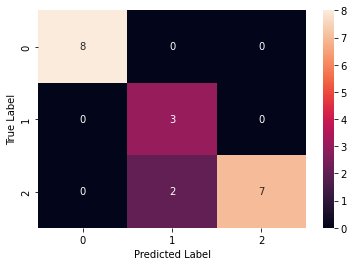

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:6.387618978818257, Test Loss: 14.382262229919434
Epoch 2-- Train Loss:7.32007098197937, Test Loss: 11.237951278686523
Epoch 3-- Train Loss:3.3500083287556968, Test Loss: 5.878403186798096
Epoch 4-- Train Loss:1.5566679040590923, Test Loss: 2.867447853088379
Epoch 5-- Train Loss:0.8578056991100311, Test Loss: 6.271010875701904
Epoch 6-- Train Loss:3.7783323923746743, Test Loss: 3.8922064304351807
Epoch 7-- Train Loss:3.0672496954600015, Test Loss: 6.41180944442749
Epoch 8-- Train Loss:0.6601718813180923, Test Loss: 3.7088708877563477
Epoch 9-- Train Loss:0.12981491163372993, Test Loss: 2.698572874069214
Epoch 10-- Train Loss:0.09686398692429066, Test Loss: 2.7042179107666016
Epoch 11-- Train Loss:0.05716824779907862, Test Loss: 2.8238861560821533
Epoch 12-- Train Loss:0.10088491812348366, Test Loss: 2.861476421356201
Epoch 13-- Train Loss:0.03895637020468712, Test Loss: 2.8362696170806885
Epoch 14-- Train Loss

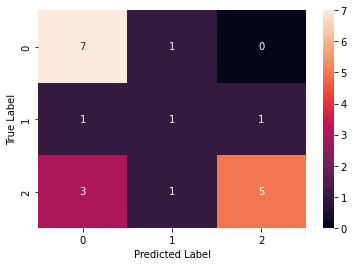

Starting testing
Training Complete
{'0': {'f1-score': '0.765±0.154',
       'precision': '0.726±0.155',
       'recall': '0.825±0.187',
       'support': 8},
 '1': {'f1-score': '0.535±0.223',
       'precision': '0.537±0.137',
       'recall': '0.583±0.342',
       'support': 4},
 '2': {'f1-score': '0.759±0.119',
       'precision': '0.832±0.108',
       'recall': '0.713±0.153',
       'support': 9},
 'accuracy': '0.735±0.104',
 'macro avg': {'f1-score': '0.686±0.109',
               'precision': '0.698±0.095',
               'recall': '0.707±0.123',
               'support': 21},
 'weighted avg': {'f1-score': '0.725±0.109',
                  'precision': '0.744±0.109',
                  'recall': '0.735±0.104',
                  'support': 21}}
{'num_epochs': 18, 'lr': 0.0007000000000000001, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:15.097132404645285, Test Loss: 21.623083114624023
Epoch 2-- Train Loss:27.259419759114582, Test Loss: 9.4313497543334

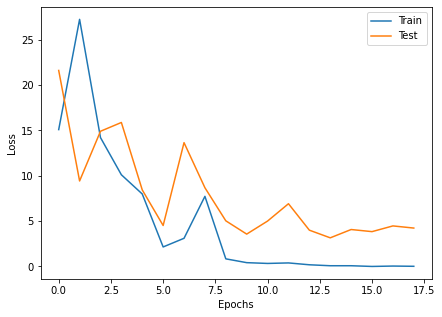

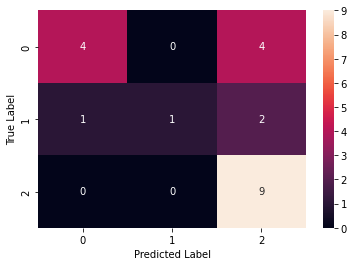

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:12.237455646197, Test Loss: 12.426193237304688
Epoch 2-- Train Loss:19.56914742787679, Test Loss: 32.671478271484375
Epoch 3-- Train Loss:17.862018426259358, Test Loss: 4.445107460021973
Epoch 4-- Train Loss:8.904840071996054, Test Loss: 18.740921020507812
Epoch 5-- Train Loss:6.1377187098066015, Test Loss: 5.767404079437256
Epoch 6-- Train Loss:7.413443962732951, Test Loss: 18.68760108947754
Epoch 7-- Train Loss:8.032029549280802, Test Loss: 5.091812610626221
Epoch 8-- Train Loss:1.479429731766383, Test Loss: 5.466792106628418
Epoch 9-- Train Loss:1.3082074125607808, Test Loss: 5.199647903442383
Epoch 10-- Train Loss:0.45805225272973377, Test Loss: 3.0966691970825195
Epoch 11-- Train Loss:0.07118930884947379, Test Loss: 3.1893537044525146
Epoch 12-- Train Loss:0.06076087926824888, Test Loss: 3.0789458751678467
Epoch 13-- Train Loss:0.09641345745573442, Test Loss: 3.270142078399658
Epoch 14-- Train Loss:0.067

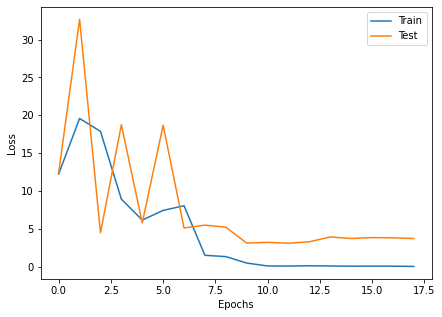

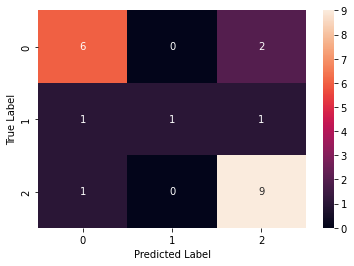

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:17.62214740117391, Test Loss: 16.02485466003418
Epoch 2-- Train Loss:27.721161206563313, Test Loss: 10.028367042541504
Epoch 3-- Train Loss:18.73430411020915, Test Loss: 13.569053649902344
Epoch 4-- Train Loss:3.7157293558120728, Test Loss: 13.729292869567871
Epoch 5-- Train Loss:5.5215427080790205, Test Loss: 7.53116512298584
Epoch 6-- Train Loss:1.760329931974411, Test Loss: 2.6151857376098633
Epoch 7-- Train Loss:1.5769200921058655, Test Loss: 3.151122570037842
Epoch 8-- Train Loss:2.480681538581848, Test Loss: 1.3580867052078247
Epoch 9-- Train Loss:0.30273295442263287, Test Loss: 4.780571460723877
Epoch 10-- Train Loss:4.63416314125061, Test Loss: 8.754263877868652
Epoch 11-- Train Loss:4.119185368220012, Test Loss: 5.306562423706055
Epoch 12-- Train Loss:2.931932032108307, Test Loss: 1.8819801807403564
Epoch 13-- Train Loss:0.24782687425613403, Test Loss: 2.5859017372131348
Epoch 14-- Train Loss:0.13390

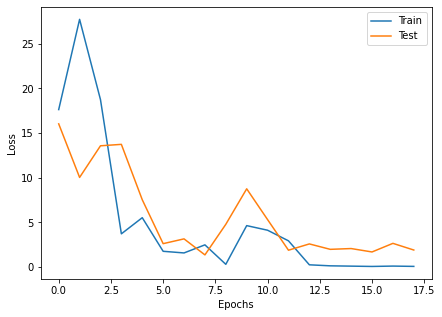

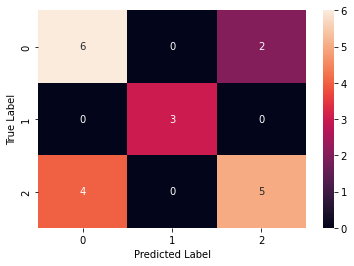

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:15.093869010607401, Test Loss: 56.828086853027344
Epoch 2-- Train Loss:25.44400469462077, Test Loss: 44.76962661743164
Epoch 3-- Train Loss:27.084795316060383, Test Loss: 42.47867965698242
Epoch 4-- Train Loss:17.288227876027424, Test Loss: 12.689784049987793
Epoch 5-- Train Loss:4.4041407108306885, Test Loss: 7.436413288116455
Epoch 6-- Train Loss:1.7507953246434529, Test Loss: 4.4232964515686035
Epoch 7-- Train Loss:0.5640606035788854, Test Loss: 2.258326292037964
Epoch 8-- Train Loss:0.5291722615559896, Test Loss: 2.9674057960510254
Epoch 9-- Train Loss:0.15552389497558275, Test Loss: 2.0017170906066895
Epoch 10-- Train Loss:0.13333220135731003, Test Loss: 2.119682788848877
Epoch 11-- Train Loss:2.5469817171494165, Test Loss: 21.30783462524414
Epoch 12-- Train Loss:12.535054842631022, Test Loss: 4.719979286193848
Epoch 13-- Train Loss:0.6211918336339295, Test Loss: 3.574536085128784
Epoch 14-- Train Loss:0

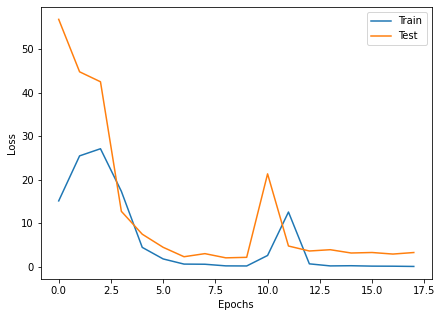

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:5.9982606172561646, Test Loss: 39.10810470581055
Epoch 2-- Train Loss:18.713172753651936, Test Loss: 13.253471374511719
Epoch 3-- Train Loss:10.618326187133789, Test Loss: 10.370238304138184
Epoch 4-- Train Loss:3.36781636873881, Test Loss: 20.376922607421875
Epoch 5-- Train Loss:18.885130564371746, Test Loss: 34.06557083129883
Epoch 6-- Train Loss:8.922913253307343, Test Loss: 7.924511432647705
Epoch 7-- Train Loss:0.7760430773099264, Test Loss: 9.008190155029297
Epoch 8-- Train Loss:0.564764271179835, Test Loss: 10.512274742126465
Epoch 9-- Train Loss:0.7253016261383891, Test Loss: 8.186540603637695
Epoch 10-- Train Loss:0.1300396754522808, Test Loss: 7.69350528717041
Epoch 11-- Train Loss:0.04216915931707869, Test Loss: 7.28368616104126
Epoch 12-- Train Loss:0.17575287818908691, Test Loss: 7.06102180480957
Epoch 13-- Train Loss:0.014939381430546442, Test Loss: 7.752157211303711
Epoch 14-- Train Loss:0.0313

Starting testing
Training Complete
{'0': {'f1-score': '0.718±0.073',
       'precision': '0.718±0.095',
       'recall': '0.75±0.158',
       'support': 8},
 '1': {'f1-score': '0.591±0.198',
       'precision': '0.85±0.2',
       'recall': '0.517±0.281',
       'support': 4},
 '2': {'f1-score': '0.729±0.054',
       'precision': '0.744±0.086',
       'recall': '0.76±0.179',
       'support': 9},
 'accuracy': '0.716±0.045',
 'macro avg': {'f1-score': '0.679±0.076',
               'precision': '0.771±0.067',
               'recall': '0.676±0.078',
               'support': 21},
 'weighted avg': {'f1-score': '0.702±0.055',
                  'precision': '0.752±0.036',
                  'recall': '0.716±0.045',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0002, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:8.250165959021874, Test Loss: 0.0017556031234562397
Epoch 2-- Train Loss:3.312033048343091, Test Loss: 1.1920928244535389e-07
Epoch 3-- Tr

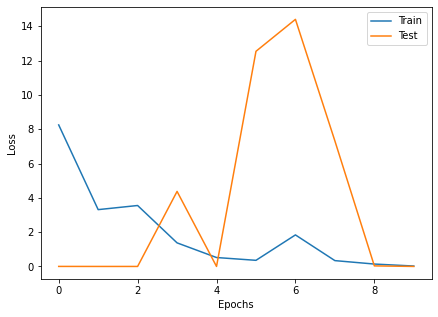

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:9.844312554314023, Test Loss: 46.57035827636719
Epoch 2-- Train Loss:3.7455379270970646, Test Loss: 0.0
Epoch 3-- Train Loss:1.3805879953769054, Test Loss: 1.1920928244535389e-07
Epoch 4-- Train Loss:0.794443562684599, Test Loss: 0.02688816376030445
Epoch 5-- Train Loss:0.9653607553861698, Test Loss: 5.6429924964904785
Epoch 6-- Train Loss:1.7427576303520407, Test Loss: 9.756468772888184
Epoch 7-- Train Loss:0.2543583657149078, Test Loss: 0.002148702275007963
Epoch 8-- Train Loss:0.15936073786853977, Test Loss: 10.762555122375488
Epoch 9-- Train Loss:0.16182790116309456, Test Loss: 0.1181052178144455
Epoch 10-- Train Loss:0.11936933754818552, Test Loss: 5.5598368644714355


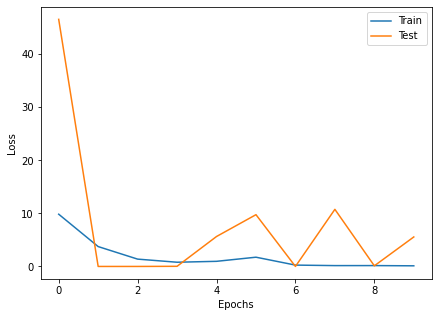

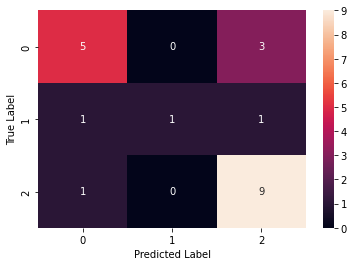

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:10.620266375087557, Test Loss: 16.72955322265625
Epoch 2-- Train Loss:6.176115771511658, Test Loss: 6.042259216308594
Epoch 3-- Train Loss:2.9770722577589344, Test Loss: 3.35455584526062
Epoch 4-- Train Loss:1.0132920041083016, Test Loss: 1.0942524671554565
Epoch 5-- Train Loss:0.9658591733286379, Test Loss: 0.35713887214660645
Epoch 6-- Train Loss:0.5888496628859208, Test Loss: 6.791024208068848
Epoch 7-- Train Loss:0.3870856743057651, Test Loss: 2.026533842086792
Epoch 8-- Train Loss:1.067525230962344, Test Loss: 10.61401081085205
Epoch 9-- Train Loss:1.3571999318727475, Test Loss: 1.358145833015442
Epoch 10-- Train Loss:0.31308640406340243, Test Loss: 10.832744598388672


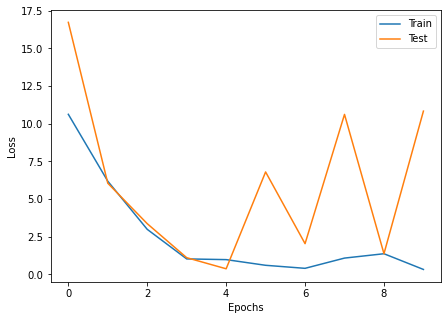

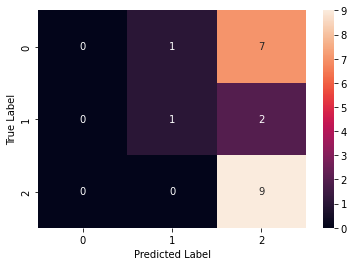

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:7.323378854995099, Test Loss: 10.525237083435059
Epoch 2-- Train Loss:4.54526332276255, Test Loss: 12.607965469360352
Epoch 3-- Train Loss:2.616939101444911, Test Loss: 10.460124015808105
Epoch 4-- Train Loss:1.908842015077209, Test Loss: 1.4411280155181885
Epoch 5-- Train Loss:1.0617996855005025, Test Loss: 26.09577751159668
Epoch 6-- Train Loss:4.622819190735927, Test Loss: 8.234493255615234
Epoch 7-- Train Loss:1.3962720929730696, Test Loss: 2.6239118576049805
Epoch 8-- Train Loss:0.16967863030123115, Test Loss: 2.6089580059051514
Epoch 9-- Train Loss:0.13126258674577448, Test Loss: 1.1155943870544434
Epoch 10-- Train Loss:0.10621988946944666, Test Loss: 0.00016874349967110902


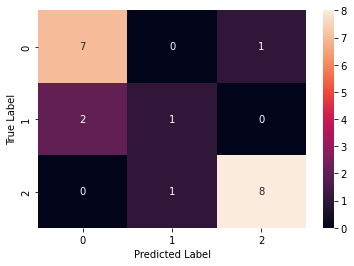

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:7.942674749397805, Test Loss: 14.098074913024902
Epoch 2-- Train Loss:2.6479655756939193, Test Loss: 7.0518341064453125
Epoch 3-- Train Loss:1.6861476791698027, Test Loss: 2.0799143314361572
Epoch 4-- Train Loss:0.8949401152744291, Test Loss: 2.935753345489502
Epoch 5-- Train Loss:2.002051531506281, Test Loss: 5.123984336853027
Epoch 6-- Train Loss:0.20740361481994168, Test Loss: 1.985959768295288
Epoch 7-- Train Loss:0.040511060996892855, Test Loss: 2.960548162460327
Epoch 8-- Train Loss:0.02957749693954847, Test Loss: 1.3334858417510986
Epoch 9-- Train Loss:0.05183565732380623, Test Loss: 3.4535863399505615
Epoch 10-- Train Loss:0.009360166027238933, Test Loss: 7.160511016845703


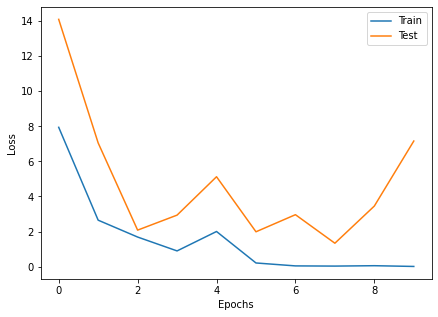

Starting testing
Training Complete
{'0': {'f1-score': '0.622±0.333',
       'precision': '0.6±0.335',
       'recall': '0.675±0.367',
       'support': 8},
 '1': {'f1-score': '0.351±0.325',
       'precision': '0.55±0.458',
       'recall': '0.317±0.367',
       'support': 4},
 '2': {'f1-score': '0.754±0.137',
       'precision': '0.738±0.178',
       'recall': '0.847±0.207',
       'support': 9},
 'accuracy': '0.695±0.167',
 'macro avg': {'f1-score': '0.576±0.246',
               'precision': '0.629±0.289',
               'recall': '0.613±0.21',
               'support': 21},
 'weighted avg': {'f1-score': '0.639±0.224',
                  'precision': '0.657±0.258',
                  'recall': '0.695±0.167',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0005, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:22.21025715824882, Test Loss: 24.447242736816406
Epoch 2-- Train Loss:8.703252960444107, Test Loss: 0.0
Epoch 3-- Train Loss:7.3196437965

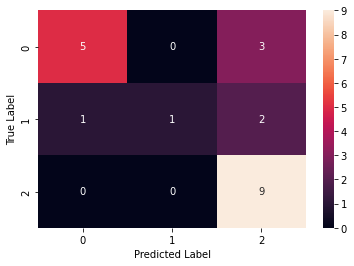

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:18.50179310072036, Test Loss: 86.12899780273438
Epoch 2-- Train Loss:9.71733204874077, Test Loss: 0.0
Epoch 3-- Train Loss:5.2163387400424615, Test Loss: 0.0
Epoch 4-- Train Loss:2.846625990405876, Test Loss: 0.0
Epoch 5-- Train Loss:2.6752638647607303, Test Loss: 0.0016094601014629006
Epoch 6-- Train Loss:4.986770296294232, Test Loss: 19.813552856445312
Epoch 7-- Train Loss:1.4261955799607984, Test Loss: 6.437280717364047e-06
Epoch 8-- Train Loss:1.4699484958472258, Test Loss: 30.217926025390625
Epoch 9-- Train Loss:0.6892224115059175, Test Loss: 0.0
Epoch 10-- Train Loss:0.21474689851600848, Test Loss: 7.027565956115723


Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:21.162108336176193, Test Loss: 23.72809410095215
Epoch 2-- Train Loss:15.167345137823196, Test Loss: 11.777033805847168
Epoch 3-- Train Loss:7.570309984373688, Test Loss: 4.252788066864014
Epoch 4-- Train Loss:1.6561259441386464, Test Loss: 2.6230974197387695
Epoch 5-- Train Loss:5.016696150050853, Test Loss: 5.085975170135498
Epoch 6-- Train Loss:3.8684595788441962, Test Loss: 8.5978364944458
Epoch 7-- Train Loss:2.378188478624947, Test Loss: 3.927168607711792
Epoch 8-- Train Loss:2.3760029047540048, Test Loss: 1.7223223447799683
Epoch 9-- Train Loss:0.11351224298179018, Test Loss: 0.9006800651550293
Epoch 10-- Train Loss:0.6754793893558332, Test Loss: 10.341068267822266


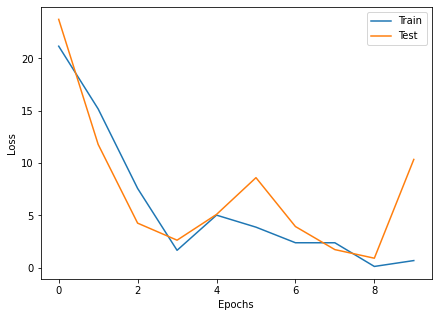

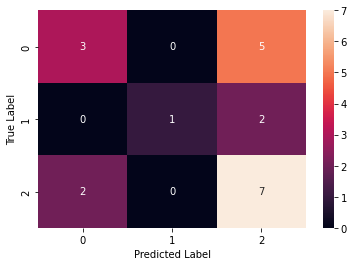

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:19.8403010054997, Test Loss: 18.683374404907227
Epoch 2-- Train Loss:12.138088346583014, Test Loss: 16.51934051513672
Epoch 3-- Train Loss:7.746610689023868, Test Loss: 15.022052764892578
Epoch 4-- Train Loss:8.375761200715951, Test Loss: 4.087178707122803
Epoch 5-- Train Loss:2.842754348029492, Test Loss: 25.118133544921875
Epoch 6-- Train Loss:3.2803154886435997, Test Loss: 23.62407112121582
Epoch 7-- Train Loss:2.4237766504210887, Test Loss: 1.1700398921966553
Epoch 8-- Train Loss:1.9469656707466627, Test Loss: 2.0907325744628906
Epoch 9-- Train Loss:1.6911919282697563, Test Loss: 2.3114583492279053
Epoch 10-- Train Loss:1.1551554029858135, Test Loss: 0.001354564563371241


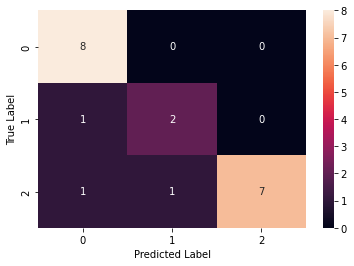

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:18.540600682837606, Test Loss: 31.393661499023438
Epoch 2-- Train Loss:5.792889508148489, Test Loss: 6.886603832244873
Epoch 3-- Train Loss:5.615210931537495, Test Loss: 45.922630310058594
Epoch 4-- Train Loss:2.890594693384255, Test Loss: 1.7506742477416992
Epoch 5-- Train Loss:6.021024298963658, Test Loss: 8.569826126098633
Epoch 6-- Train Loss:2.507200018345332, Test Loss: 6.714245870398372e-08
Epoch 7-- Train Loss:0.7814919895865164, Test Loss: 7.4315948486328125
Epoch 8-- Train Loss:0.15619910877907323, Test Loss: 2.157374620437622
Epoch 9-- Train Loss:0.3025330688044767, Test Loss: 7.195704460144043
Epoch 10-- Train Loss:0.18278579377805756, Test Loss: 25.54849624633789


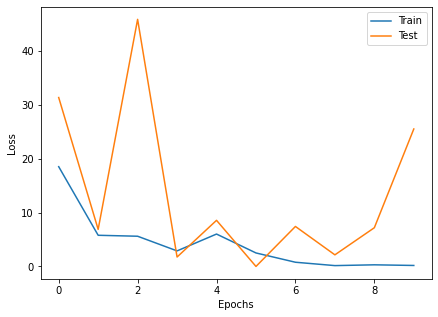

Starting testing
Training Complete
{'0': {'f1-score': '0.699±0.162',
       'precision': '0.694±0.152',
       'recall': '0.75±0.237',
       'support': 8},
 '1': {'f1-score': '0.347±0.299',
       'precision': '0.367±0.306',
       'recall': '0.333±0.298',
       'support': 4},
 '2': {'f1-score': '0.754±0.112',
       'precision': '0.791±0.177',
       'recall': '0.782±0.186',
       'support': 9},
 'accuracy': '0.696±0.111',
 'macro avg': {'f1-score': '0.6±0.14',
               'precision': '0.617±0.128',
               'recall': '0.622±0.123',
               'support': 21},
 'weighted avg': {'f1-score': '0.665±0.124',
                  'precision': '0.683±0.113',
                  'recall': '0.696±0.111',
                  'support': 21}}


In [83]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='cnn'
    results = train_model(name=name, dataset=dataset, k_folds =5,  **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )


## 3.2 Petrained Resnet-50

In [35]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-3,1e-1, 1e-3)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(2,30, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 26, 'lr': 0.024, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.9168689129027454, Test Loss: 1.6181929111480713
Epoch 2-- Train Loss:1.4786305099048398, Test Loss: 0.34028998017311096
Epoch 3-- Train Loss:0.8164712000976909, Test Loss: 0.5868074297904968
Epoch 4-- Train Loss:0.6626892689276825, Test Loss: 1.1256853342056274
Epoch 5-- Train Loss:0.4284438140351664, Test Loss: 1.8839917182922363
Epoch 6-- Train Loss:0.7524461197582158, Test Loss: 2.5944082736968994
Epoch 7-- Train Loss:0.8190104643052275, Test Loss: 4.2170023918151855
Epoch 8-- Train Loss:0.6857433197173205, Test Loss: 0.1885252445936203
Epoch 9-- Train Loss:0.7796034973792054, Test Loss: 1.5858564376831055
Epoch 10-- Train Loss:0.6525750480253588, Test Loss: 0.13902568817138672
Epoch 11-- Train Loss:0.5422499302605336, Test Loss: 0.7227229475975037
Epoch 12-- Train Loss:1.0102333561940626, Test Loss: 1.5592093467712402
Epoch 13-- Train Loss:0.507920553907752, Test Loss: 0.

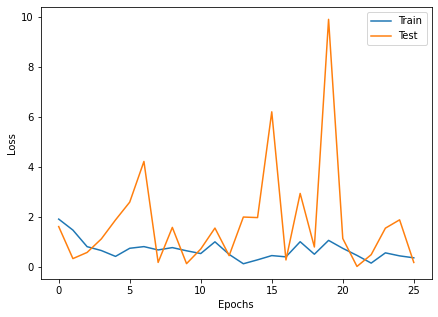

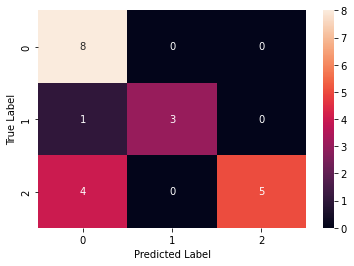

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.6343283328143032, Test Loss: 7.723484039306641
Epoch 2-- Train Loss:1.7984843882308765, Test Loss: 2.989440441131592
Epoch 3-- Train Loss:1.3511521951718763, Test Loss: 1.8002018928527832
Epoch 4-- Train Loss:0.8551398759538477, Test Loss: 0.7887840270996094
Epoch 5-- Train Loss:0.8098392892967571, Test Loss: 1.7535406351089478
Epoch 6-- Train Loss:0.6186942200769078, Test Loss: 0.04881443455815315
Epoch 7-- Train Loss:0.5937935574488207, Test Loss: 1.8764996528625488
Epoch 8-- Train Loss:0.5603381774642251, Test Loss: 0.23594802618026733
Epoch 9-- Train Loss:0.25769205478189344, Test Loss: 3.4943125247955322
Epoch 10-- Train Loss:0.4571939910000021, Test Loss: 1.199908971786499
Epoch 11-- Train Loss:0.43351926883174613, Test Loss: 0.9698339700698853
Epoch 12-- Train Loss:0.5219980078664693, Test Loss: 0.3197770118713379
Epoch 13-- Train Loss:0.4811330327594822, Test Loss: 2.0945279598236084
Epoch 14-- Trai

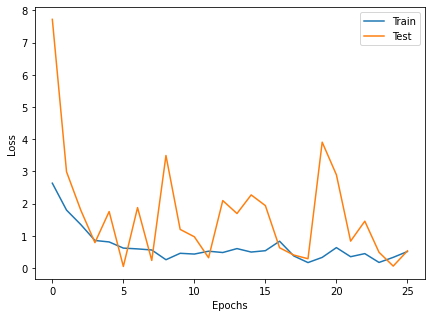

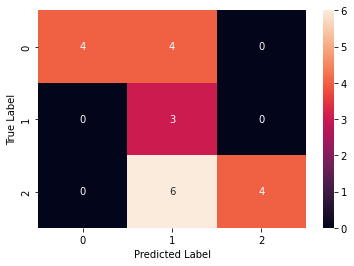

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.791569097475572, Test Loss: 1.3458850383758545
Epoch 2-- Train Loss:1.3767746795307507, Test Loss: 4.022428512573242
Epoch 3-- Train Loss:0.48819494484500453, Test Loss: 1.3882988691329956
Epoch 4-- Train Loss:0.4327090626413172, Test Loss: 6.1490983963012695
Epoch 5-- Train Loss:0.6676144154573028, Test Loss: 2.5502614974975586
Epoch 6-- Train Loss:0.7187073325568979, Test Loss: 1.0317437648773193
Epoch 7-- Train Loss:0.5499666787006638, Test Loss: 0.5503310561180115
Epoch 8-- Train Loss:0.24762660891494967, Test Loss: 4.346206188201904
Epoch 9-- Train Loss:0.7847666025839068, Test Loss: 1.7001097202301025
Epoch 10-- Train Loss:0.4870017467235977, Test Loss: 0.9227647185325623
Epoch 11-- Train Loss:0.5390847169540145, Test Loss: 3.428075075149536
Epoch 12-- Train Loss:0.9233212985775687, Test Loss: 3.4219489097595215
Epoch 13-- Train Loss:0.7391881820830432, Test Loss: 0.5953665375709534
Epoch 14-- Train L

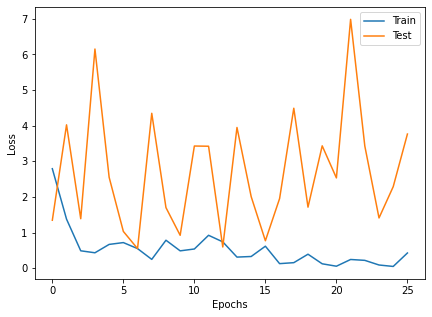

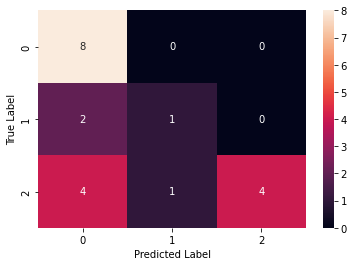

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:2.7171042182228784, Test Loss: 2.8087921142578125
Epoch 2-- Train Loss:1.2733771963552996, Test Loss: 4.959904670715332
Epoch 3-- Train Loss:1.367893481796438, Test Loss: 0.2588350474834442
Epoch 4-- Train Loss:0.23444078049876474, Test Loss: 0.4547595679759979
Epoch 5-- Train Loss:0.3502846746282144, Test Loss: 3.8536057472229004
Epoch 6-- Train Loss:1.4816459905017505, Test Loss: 0.5463777184486389
Epoch 7-- Train Loss:0.6269759413870898, Test Loss: 4.982351779937744
Epoch 8-- Train Loss:0.2009857606820085, Test Loss: 0.7878620624542236
Epoch 9-- Train Loss:0.22347534854303708, Test Loss: 2.9000580310821533
Epoch 10-- Train Loss:0.421685361049392, Test Loss: 1.4526586532592773
Epoch 11-- Train Loss:0.22424574052406984, Test Loss: 0.8856247067451477
Epoch 12-- Train Loss:0.4272042519666932, Test Loss: 0.031642988324165344
Epoch 13-- Train Loss:0.25199982625516976, Test Loss: 0.055431731045246124
Epoch 14-- T

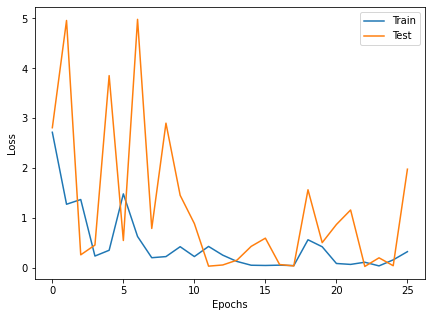

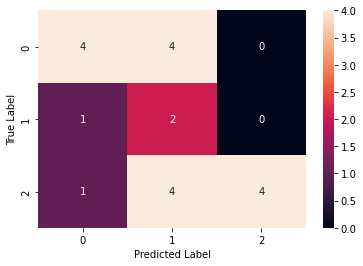

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.8866985602812334, Test Loss: 0.6504620313644409
Epoch 2-- Train Loss:1.871509389443831, Test Loss: 0.4437805116176605
Epoch 3-- Train Loss:0.9620151059194044, Test Loss: 1.302747130393982
Epoch 4-- Train Loss:0.7985837432471189, Test Loss: 1.1026092767715454
Epoch 5-- Train Loss:0.4988169338215481, Test Loss: 1.1457343101501465
Epoch 6-- Train Loss:0.8854044872251424, Test Loss: 1.1635589599609375
Epoch 7-- Train Loss:0.2886206485669721, Test Loss: 0.23810845613479614
Epoch 8-- Train Loss:0.14088501239364798, Test Loss: 1.763864517211914
Epoch 9-- Train Loss:0.6305394023656845, Test Loss: 1.147584319114685
Epoch 10-- Train Loss:0.617592073299668, Test Loss: 3.296673059463501
Epoch 11-- Train Loss:0.3948592083020644, Test Loss: 0.4331829249858856
Epoch 12-- Train Loss:0.13145204345611008, Test Loss: 1.3769015073776245
Epoch 13-- Train Loss:0.3315864654935219, Test Loss: 3.495225667953491
Epoch 14-- Train Los

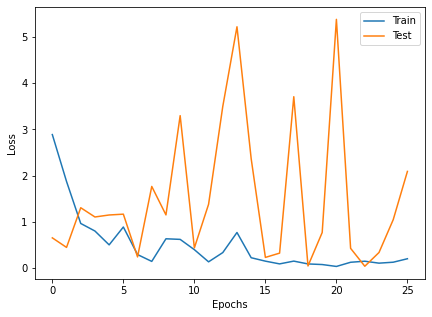

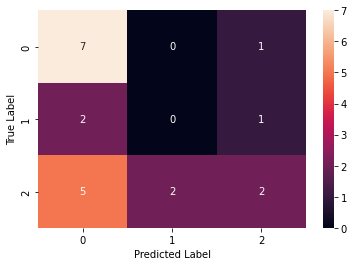

Starting testing
Training Complete
{'0': {'f1-score': '0.682±0.149',
       'precision': '0.741±0.163',
       'recall': '0.775±0.3',
       'support': 8},
 '1': {'f1-score': '0.481±0.132',
       'precision': '0.584±0.355',
       'recall': '0.633±0.221',
       'support': 4},
 '2': {'f1-score': '0.686±0.057',
       'precision': '1.0±0.0',
       'recall': '0.524±0.062',
       'support': 9},
 'accuracy': '0.639±0.116',
 'macro avg': {'f1-score': '0.616±0.101',
               'precision': '0.775±0.07',
               'recall': '0.644±0.065',
               'support': 21},
 'weighted avg': {'f1-score': '0.654±0.095',
                  'precision': '0.837±0.026',
                  'recall': '0.639±0.116',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.08600000000000001, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.101660150018605, Test Loss: 1.7375308275222778
Epoch 2-- Train Loss:1.2357380579818378, Test Loss: 1.3463859558105469
Epoch 3

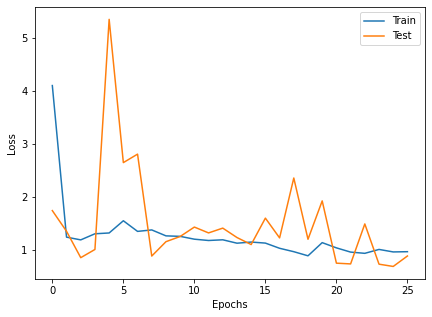

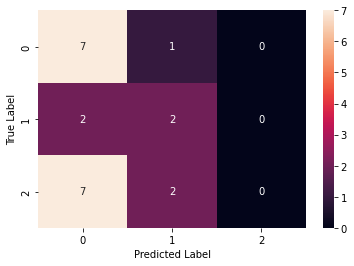

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:4.019894361495972, Test Loss: 6.02023983001709
Epoch 2-- Train Loss:1.7970913431861184, Test Loss: 2.9617836475372314
Epoch 3-- Train Loss:1.3137873411178589, Test Loss: 2.4204044342041016
Epoch 4-- Train Loss:1.3104051514105364, Test Loss: 0.5522356033325195
Epoch 5-- Train Loss:1.3110686269673435, Test Loss: 1.0960739850997925
Epoch 6-- Train Loss:1.1798022010109641, Test Loss: 1.3633214235305786
Epoch 7-- Train Loss:1.2856206406246533, Test Loss: 1.9260929822921753
Epoch 8-- Train Loss:1.2667016549543901, Test Loss: 1.7391324043273926
Epoch 9-- Train Loss:1.1660244356502185, Test Loss: 1.9838258028030396
Epoch 10-- Train Loss:1.1635547442869707, Test Loss: 1.395881175994873
Epoch 11-- Train Loss:1.1540841622786089, Test Loss: 1.5887598991394043
Epoch 12-- Train Loss:1.2461140155792236, Test Loss: 1.5145162343978882
Epoch 13-- Train Loss:1.234821373766119, Test Loss: 1.7167212963104248
Epoch 14-- Train Loss

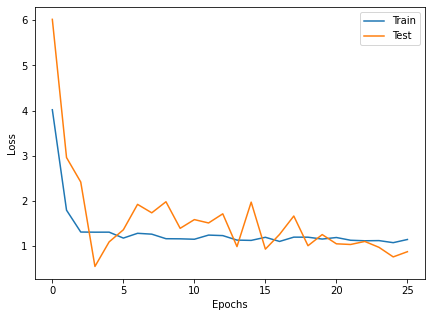

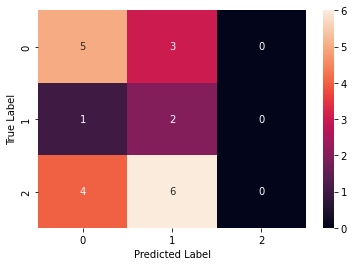

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:5.5261506980115715, Test Loss: 1.147823691368103
Epoch 2-- Train Loss:1.824350961230018, Test Loss: 2.5394179821014404
Epoch 3-- Train Loss:1.803588704629378, Test Loss: 2.6234333515167236
Epoch 4-- Train Loss:1.1595877029679038, Test Loss: 2.908179998397827
Epoch 5-- Train Loss:1.2937479290095242, Test Loss: 1.0283243656158447
Epoch 6-- Train Loss:1.1714129718867214, Test Loss: 1.1720927953720093
Epoch 7-- Train Loss:1.1319238218394192, Test Loss: 0.47719037532806396
Epoch 8-- Train Loss:1.0730096399784088, Test Loss: 2.041161298751831
Epoch 9-- Train Loss:1.1804850155656987, Test Loss: 1.273556113243103
Epoch 10-- Train Loss:1.1885422197255222, Test Loss: 0.8772693872451782
Epoch 11-- Train Loss:1.2232296846129678, Test Loss: 1.3044110536575317
Epoch 12-- Train Loss:1.0531104315410962, Test Loss: 1.3672765493392944
Epoch 13-- Train Loss:1.1977364475076848, Test Loss: 1.258144497871399
Epoch 14-- Train Loss:

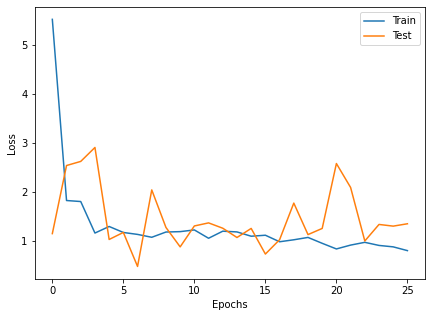

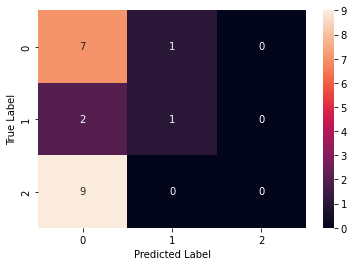

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:4.156972847201607, Test Loss: 1.6774097681045532
Epoch 2-- Train Loss:1.9109279946847395, Test Loss: 4.606912612915039
Epoch 3-- Train Loss:1.8333392901854082, Test Loss: 1.808138132095337
Epoch 4-- Train Loss:1.1722554997964338, Test Loss: 0.8841780424118042
Epoch 5-- Train Loss:1.1149342331019314, Test Loss: 2.4439752101898193
Epoch 6-- Train Loss:1.3201153495094993, Test Loss: 0.8549029231071472
Epoch 7-- Train Loss:1.1343226432800293, Test Loss: 1.2780518531799316
Epoch 8-- Train Loss:1.1292697895656933, Test Loss: 0.9990689754486084
Epoch 9-- Train Loss:1.1277440081943164, Test Loss: 2.1021814346313477
Epoch 10-- Train Loss:1.2351680668917568, Test Loss: 1.6557912826538086
Epoch 11-- Train Loss:1.078595221042633, Test Loss: 1.0865185260772705
Epoch 12-- Train Loss:1.1452145305546848, Test Loss: 0.8172863125801086
Epoch 13-- Train Loss:1.1634823029691523, Test Loss: 0.9000912308692932
Epoch 14-- Train Los

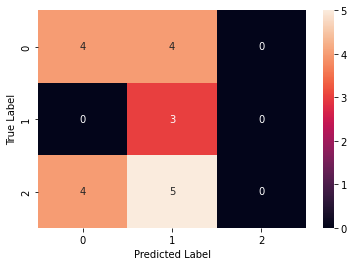

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:6.949754346500743, Test Loss: 1.108770489692688
Epoch 2-- Train Loss:1.6273637793280862, Test Loss: 0.6219481825828552
Epoch 3-- Train Loss:1.4021813381801953, Test Loss: 0.6439528465270996
Epoch 4-- Train Loss:1.2787103707140142, Test Loss: 1.1970893144607544
Epoch 5-- Train Loss:1.2548206719485195, Test Loss: 0.9958107471466064
Epoch 6-- Train Loss:1.291086272759871, Test Loss: 1.8103303909301758
Epoch 7-- Train Loss:1.160643761808222, Test Loss: 1.4487110376358032
Epoch 8-- Train Loss:1.1486602046272971, Test Loss: 2.1819217205047607
Epoch 9-- Train Loss:1.2503910064697266, Test Loss: 0.7084255218505859
Epoch 10-- Train Loss:1.2732242129065774, Test Loss: 1.6883623600006104
Epoch 11-- Train Loss:1.127403275533156, Test Loss: 0.7624606490135193
Epoch 12-- Train Loss:1.1376335295763882, Test Loss: 0.8804407119750977
Epoch 13-- Train Loss:1.1747920946641401, Test Loss: 1.4846926927566528
Epoch 14-- Train Loss

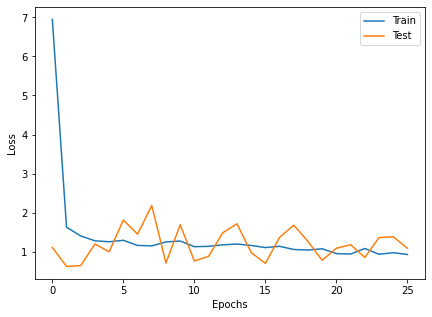

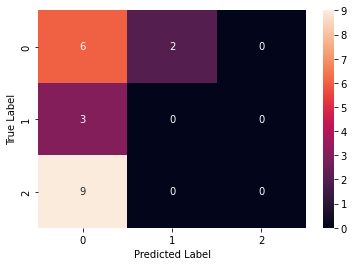

Starting testing
Training Complete
{'0': {'f1-score': '0.572±0.084',
       'precision': '0.467±0.121',
       'recall': '0.775±0.05',
       'support': 8},
 '1': {'f1-score': '0.263±0.163',
       'precision': '0.208±0.135',
       'recall': '0.433±0.327',
       'support': 4},
 '2': {'f1-score': '0.0±0.0',
       'precision': '0.0±0.0',
       'recall': '0.0±0.0',
       'support': 9},
 'accuracy': '0.373±0.042',
 'macro avg': {'f1-score': '0.278±0.067',
               'precision': '0.225±0.061',
               'recall': '0.403±0.099',
               'support': 21},
 'weighted avg': {'f1-score': '0.267±0.046',
                  'precision': '0.217±0.052',
                  'recall': '0.373±0.042',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.063, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.145319469950416, Test Loss: 2.3293020725250244
Epoch 2-- Train Loss:1.4893349083987149, Test Loss: 0.8512403964996338
Epoch 3-- Train Loss:1.3603

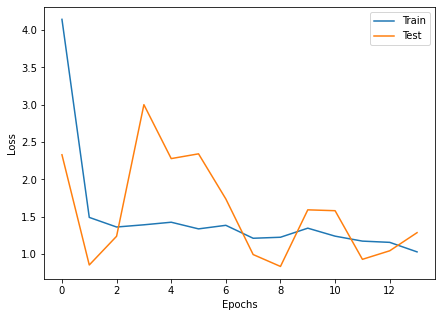

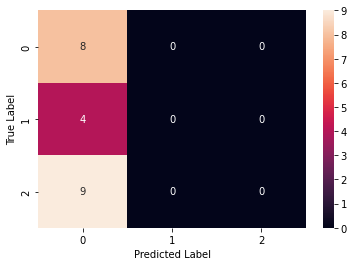

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:5.061708191579038, Test Loss: 0.9452011585235596
Epoch 2-- Train Loss:2.029240142215382, Test Loss: 2.369539737701416
Epoch 3-- Train Loss:1.2272470972754739, Test Loss: 3.0556259155273438
Epoch 4-- Train Loss:1.204369986599142, Test Loss: 1.9008859395980835
Epoch 5-- Train Loss:1.2172665054147893, Test Loss: 3.0800492763519287
Epoch 6-- Train Loss:1.1181034445762634, Test Loss: 0.5614113211631775
Epoch 7-- Train Loss:1.3632404533299534, Test Loss: 2.83668851852417
Epoch 8-- Train Loss:1.210597569292242, Test Loss: 1.4012748003005981
Epoch 9-- Train Loss:1.071299834684892, Test Loss: 1.694454550743103
Epoch 10-- Train Loss:1.1082854812795466, Test Loss: 1.0771604776382446
Epoch 11-- Train Loss:1.2087126590988853, Test Loss: 1.11922287940979
Epoch 12-- Train Loss:1.0379123362627896, Test Loss: 1.19870924949646
Epoch 13-- Train Loss:1.0317064794627102, Test Loss: 2.013901948928833
Epoch 14-- Train Loss:0.906506

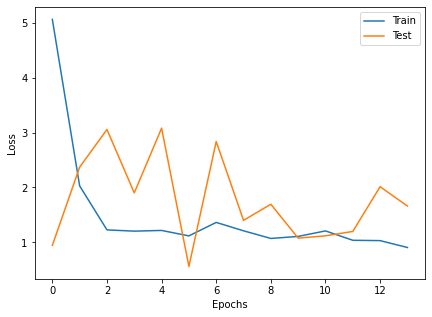

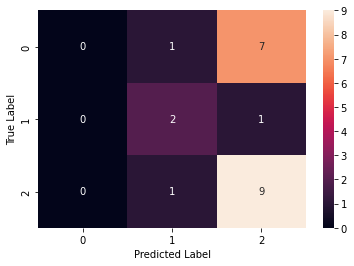

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:3.9404394409873267, Test Loss: 7.188320636749268
Epoch 2-- Train Loss:1.7049191052263433, Test Loss: 2.25422739982605
Epoch 3-- Train Loss:1.3130328763615002, Test Loss: 1.008769154548645
Epoch 4-- Train Loss:1.102332353591919, Test Loss: 1.2657989263534546
Epoch 5-- Train Loss:1.0653320984406904, Test Loss: 2.2190909385681152
Epoch 6-- Train Loss:1.0729557817632502, Test Loss: 2.538689136505127
Epoch 7-- Train Loss:1.1589046933434226, Test Loss: 0.8430655598640442
Epoch 8-- Train Loss:0.8694506612691012, Test Loss: 2.098677635192871
Epoch 9-- Train Loss:0.8627151413397356, Test Loss: 2.500007152557373
Epoch 10-- Train Loss:1.2171191518956965, Test Loss: 1.8662575483322144
Epoch 11-- Train Loss:1.1526018489490857, Test Loss: 0.5424773693084717
Epoch 12-- Train Loss:0.8166577572172339, Test Loss: 1.1042988300323486
Epoch 13-- Train Loss:0.8446152941747145, Test Loss: 0.33653244376182556
Epoch 14-- Train Loss:0

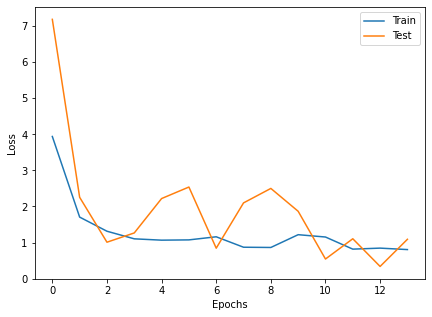

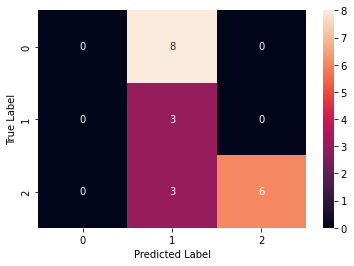

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.6044910821047695, Test Loss: 2.7428226470947266
Epoch 2-- Train Loss:1.5311364910819314, Test Loss: 1.5621654987335205
Epoch 3-- Train Loss:1.3683480566198176, Test Loss: 2.1913771629333496
Epoch 4-- Train Loss:1.1477185541933232, Test Loss: 1.2949233055114746
Epoch 5-- Train Loss:1.2629454298452898, Test Loss: 1.3339482545852661
Epoch 6-- Train Loss:1.088418651710857, Test Loss: 1.2848142385482788
Epoch 7-- Train Loss:1.1197856122797185, Test Loss: 1.481135606765747
Epoch 8-- Train Loss:0.9368254163048484, Test Loss: 0.7975277900695801
Epoch 9-- Train Loss:0.9529756036671725, Test Loss: 0.9481058716773987
Epoch 10-- Train Loss:0.9466857801784169, Test Loss: 1.6468087434768677
Epoch 11-- Train Loss:0.8504934852773492, Test Loss: 0.8303458094596863
Epoch 12-- Train Loss:0.6295311748981476, Test Loss: 0.3355139195919037
Epoch 13-- Train Loss:0.9172353744506836, Test Loss: 0.6479207277297974
Epoch 14-- Train L

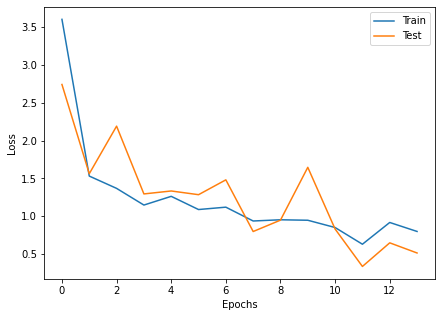

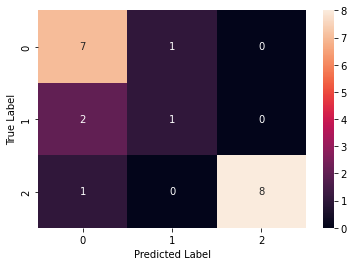

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.414022082632238, Test Loss: 1.762877106666565
Epoch 2-- Train Loss:1.6436510682106018, Test Loss: 0.01763685792684555
Epoch 3-- Train Loss:1.5258902257139033, Test Loss: 0.39423155784606934
Epoch 4-- Train Loss:1.2831816510720686, Test Loss: 2.421598196029663
Epoch 5-- Train Loss:1.2958403609015725, Test Loss: 1.956073522567749
Epoch 6-- Train Loss:1.0920716469938105, Test Loss: 1.0982308387756348
Epoch 7-- Train Loss:1.144238753752275, Test Loss: 1.425004005432129
Epoch 8-- Train Loss:1.1128500266508623, Test Loss: 1.0339993238449097
Epoch 9-- Train Loss:0.8341939720240507, Test Loss: 1.1077138185501099
Epoch 10-- Train Loss:1.0313059904358604, Test Loss: 4.817492485046387
Epoch 11-- Train Loss:0.7012476568872278, Test Loss: 0.2916140854358673
Epoch 12-- Train Loss:0.6139315028082241, Test Loss: 0.9697878360748291
Epoch 13-- Train Loss:0.6015149354934692, Test Loss: 1.1899937391281128
Epoch 14-- Train Loss

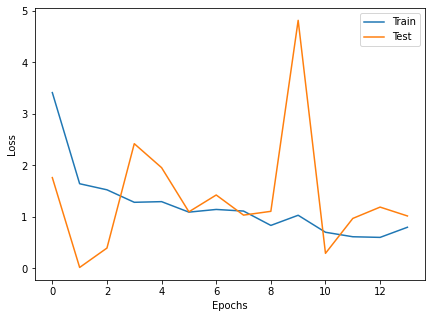

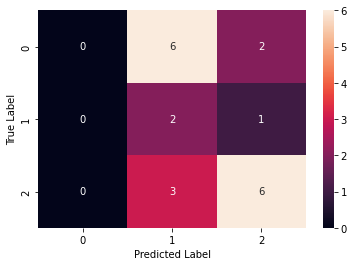

Starting testing
Training Complete
{'0': {'f1-score': '0.296±0.288',
       'precision': '0.41±0.388',
       'recall': '0.375±0.418',
       'support': 8},
 '1': {'f1-score': '0.318±0.218',
       'precision': '0.262±0.222',
       'recall': '0.533±0.34',
       'support': 4},
 '2': {'f1-score': '0.587±0.304',
       'precision': '0.638±0.359',
       'recall': '0.58±0.312',
       'support': 9},
 'accuracy': '0.491±0.124',
 'macro avg': {'f1-score': '0.4±0.149',
               'precision': '0.437±0.211',
               'recall': '0.496±0.11',
               'support': 21},
 'weighted avg': {'f1-score': '0.43±0.17',
                  'precision': '0.49±0.258',
                  'recall': '0.491±0.124',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.058, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:3.0454723943363535, Test Loss: 2.194380044937134
Epoch 2-- Train Loss:1.5170431543480267, Test Loss: 0.8730282783508301
Epoch 3-- Train Loss:1.

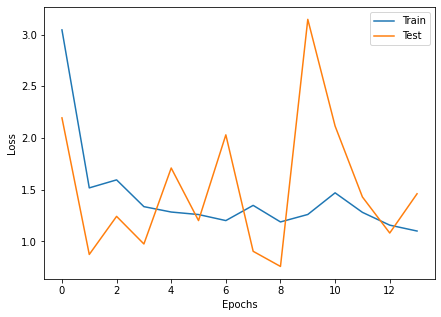

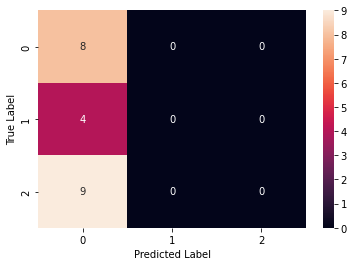

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:5.882287434556267, Test Loss: 0.8349837064743042
Epoch 2-- Train Loss:1.7193439982154153, Test Loss: 1.8043439388275146
Epoch 3-- Train Loss:1.238413241776553, Test Loss: 3.109950304031372
Epoch 4-- Train Loss:1.27223110740835, Test Loss: 1.671638011932373
Epoch 5-- Train Loss:1.1137753129005432, Test Loss: 2.2685840129852295
Epoch 6-- Train Loss:1.088031151077964, Test Loss: 0.49815845489501953
Epoch 7-- Train Loss:1.3039827075871555, Test Loss: 2.771179676055908
Epoch 8-- Train Loss:1.1095164905894885, Test Loss: 1.3366299867630005
Epoch 9-- Train Loss:1.0307954929091714, Test Loss: 1.5700876712799072
Epoch 10-- Train Loss:1.0813611312346025, Test Loss: 1.2363429069519043
Epoch 11-- Train Loss:1.0462417873469265, Test Loss: 0.8534111976623535
Epoch 12-- Train Loss:0.9525994604284113, Test Loss: 1.1991169452667236
Epoch 13-- Train Loss:0.9746645092964172, Test Loss: 2.7461905479431152
Epoch 14-- Train Loss:1

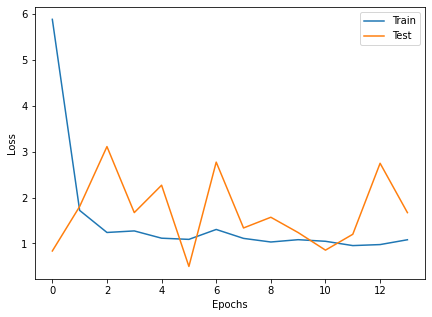

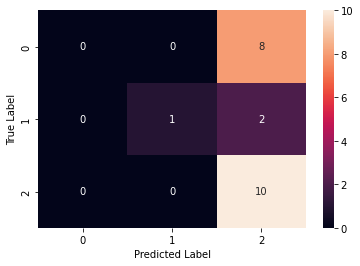

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.217590201984752, Test Loss: 3.6548657417297363
Epoch 2-- Train Loss:1.7969687310132114, Test Loss: 2.7448110580444336
Epoch 3-- Train Loss:1.4448485049334439, Test Loss: 0.6734696626663208
Epoch 4-- Train Loss:1.29268386147239, Test Loss: 1.4902005195617676
Epoch 5-- Train Loss:1.1199047402902083, Test Loss: 1.984971284866333
Epoch 6-- Train Loss:1.132531469518488, Test Loss: 1.8462876081466675
Epoch 7-- Train Loss:1.1172445795752786, Test Loss: 1.1653950214385986
Epoch 8-- Train Loss:1.007886453108354, Test Loss: 2.7417373657226562
Epoch 9-- Train Loss:1.0411251241510564, Test Loss: 2.1335744857788086
Epoch 10-- Train Loss:1.016891593282873, Test Loss: 1.2800747156143188
Epoch 11-- Train Loss:0.9632554162632335, Test Loss: 0.6807449460029602
Epoch 12-- Train Loss:0.8611513105305758, Test Loss: 1.563002586364746
Epoch 13-- Train Loss:0.9783099374987863, Test Loss: 0.6383290886878967
Epoch 14-- Train Loss:0.

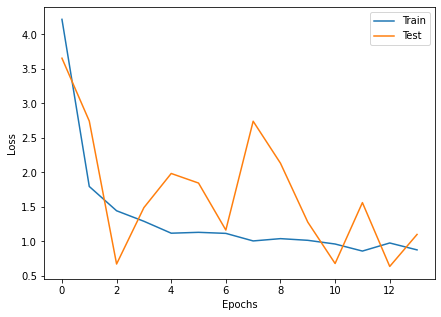

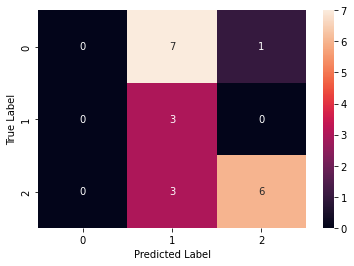

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.552338806065646, Test Loss: 1.3163788318634033
Epoch 2-- Train Loss:1.8520475192503496, Test Loss: 1.4842143058776855
Epoch 3-- Train Loss:1.7499779083512046, Test Loss: 2.392622470855713
Epoch 4-- Train Loss:1.194528807293285, Test Loss: 1.1150705814361572
Epoch 5-- Train Loss:1.2287334149534053, Test Loss: 1.1742266416549683
Epoch 6-- Train Loss:1.1262521689588374, Test Loss: 1.8508888483047485
Epoch 7-- Train Loss:1.1118155501105569, Test Loss: 1.6069319248199463
Epoch 8-- Train Loss:1.0009032162753018, Test Loss: 0.7619016170501709
Epoch 9-- Train Loss:0.8987424048510465, Test Loss: 0.9599727988243103
Epoch 10-- Train Loss:0.9645618308674205, Test Loss: 1.8077735900878906
Epoch 11-- Train Loss:0.8925895149057562, Test Loss: 0.7529727220535278
Epoch 12-- Train Loss:0.7086719057776711, Test Loss: 0.21980489790439606
Epoch 13-- Train Loss:1.04093275828795, Test Loss: 0.902883768081665
Epoch 14-- Train Loss

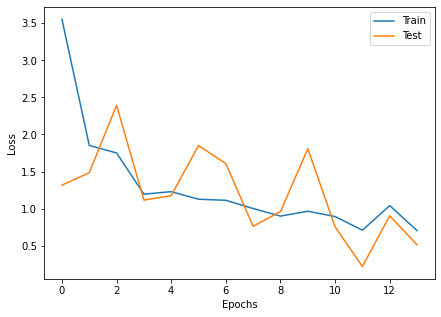

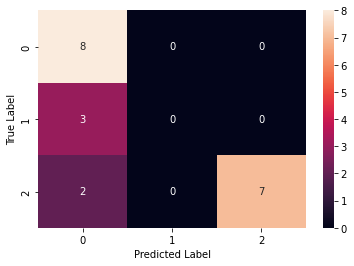

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.707904376766898, Test Loss: 2.1026523113250732
Epoch 2-- Train Loss:1.6153327985243364, Test Loss: 0.05193676799535751
Epoch 3-- Train Loss:1.2885151342912153, Test Loss: 0.8202178478240967
Epoch 4-- Train Loss:1.1588725339282642, Test Loss: 2.8064076900482178
Epoch 5-- Train Loss:1.1548280119895935, Test Loss: 1.960715413093567
Epoch 6-- Train Loss:0.889795639298179, Test Loss: 0.6274686455726624
Epoch 7-- Train Loss:1.1116124662485989, Test Loss: 1.8971576690673828
Epoch 8-- Train Loss:1.1842654130675576, Test Loss: 1.4078843593597412
Epoch 9-- Train Loss:0.9961576407605951, Test Loss: 1.306248664855957
Epoch 10-- Train Loss:0.8214140046726573, Test Loss: 5.795411109924316
Epoch 11-- Train Loss:0.7282298586585305, Test Loss: 0.5099669694900513
Epoch 12-- Train Loss:0.7390605861490424, Test Loss: 0.34101802110671997
Epoch 13-- Train Loss:0.7595950039950284, Test Loss: 1.0337045192718506
Epoch 14-- Train Lo

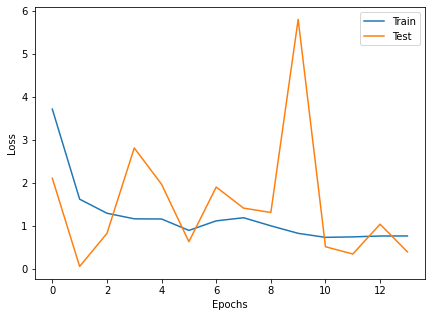

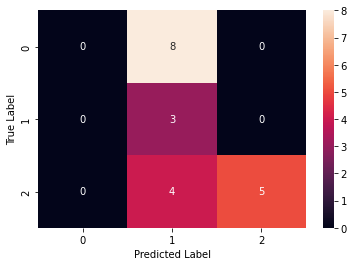

Starting testing
Training Complete
{'0': {'f1-score': '0.244±0.301',
       'precision': '0.184±0.231',
       'recall': '0.375±0.461',
       'support': 8},
 '1': {'f1-score': '0.221±0.197',
       'precision': '0.274±0.373',
       'recall': '0.4±0.389',
       'support': 4},
 '2': {'f1-score': '0.567±0.286',
       'precision': '0.61±0.334',
       'recall': '0.578±0.325',
       'support': 9},
 'accuracy': '0.471±0.103',
 'macro avg': {'f1-score': '0.344±0.094',
               'precision': '0.356±0.131',
               'recall': '0.451±0.067',
               'support': 21},
 'weighted avg': {'f1-score': '0.386±0.126',
                  'precision': '0.389±0.145',
                  'recall': '0.471±0.103',
                  'support': 21}}
{'num_epochs': 2, 'lr': 0.037000000000000005, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.7216037561496098, Test Loss: 2.720439910888672
Epoch 2-- Train Loss:2.7818945050239563, Test Loss: 1.026245355606079


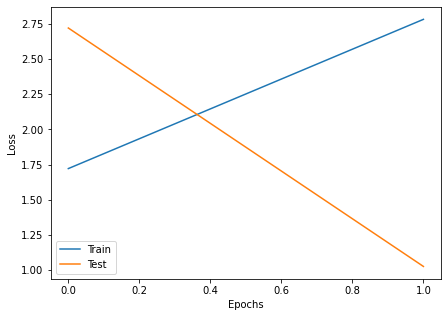

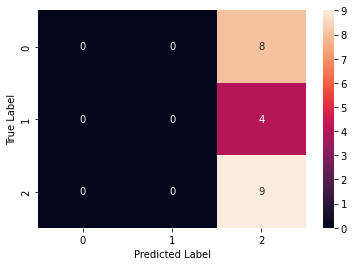

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.949246406555176, Test Loss: 6.4060378074646
Epoch 2-- Train Loss:1.9104298154513042, Test Loss: 1.819940447807312


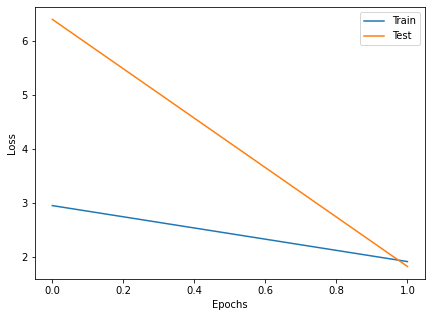

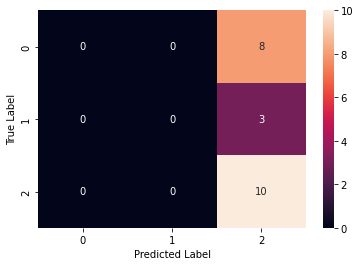

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.535641133785248, Test Loss: 0.6594513058662415
Epoch 2-- Train Loss:5.338523268699646, Test Loss: 1.9666675329208374


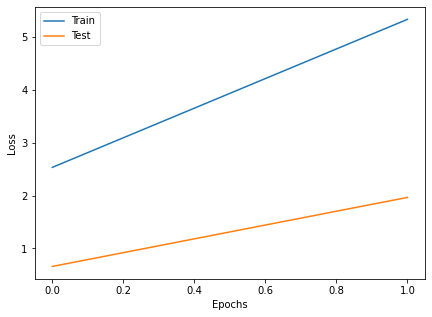

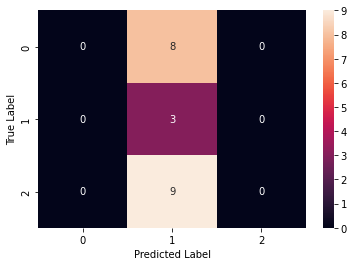

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:2.36335776730751, Test Loss: 3.900122880935669
Epoch 2-- Train Loss:1.9267611702283223, Test Loss: 5.814574241638184


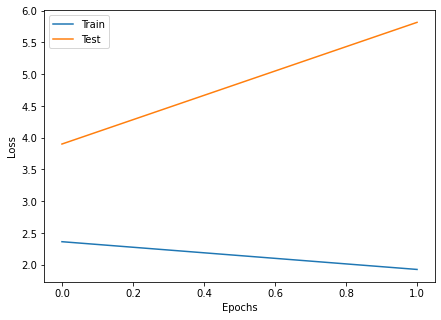

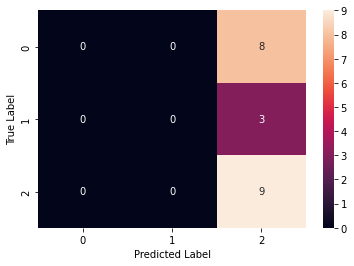

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.5027520259221396, Test Loss: 14.414510726928711
Epoch 2-- Train Loss:4.0276051958401995, Test Loss: 4.8927836418151855


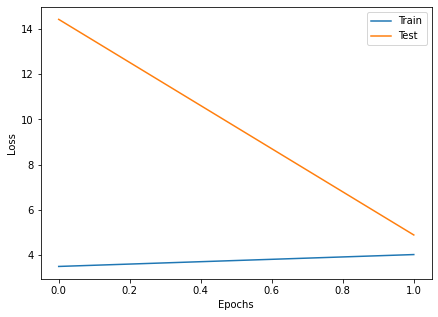

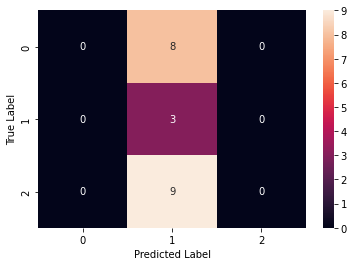

Starting testing
Training Complete
{'0': {'f1-score': '0.0±0.0',
       'precision': '0.0±0.0',
       'recall': '0.0±0.0',
       'support': 8},
 '1': {'f1-score': '0.104±0.128',
       'precision': '0.06±0.073',
       'recall': '0.4±0.49',
       'support': 4},
 '2': {'f1-score': '0.373±0.305',
       'precision': '0.271±0.222',
       'recall': '0.6±0.49',
       'support': 9},
 'accuracy': '0.331±0.149',
 'macro avg': {'f1-score': '0.159±0.059',
               'precision': '0.11±0.05',
               'recall': '0.333±0.0',
               'support': 21},
 'weighted avg': {'f1-score': '0.184±0.12',
                  'precision': '0.132±0.09',
                  'recall': '0.331±0.149',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.013000000000000001, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.2112303177515666, Test Loss: 1.9258968830108643
Epoch 2-- Train Loss:1.6141751607259114, Test Loss: 1.896322250366211
Epoch 3-- Train Loss:1.

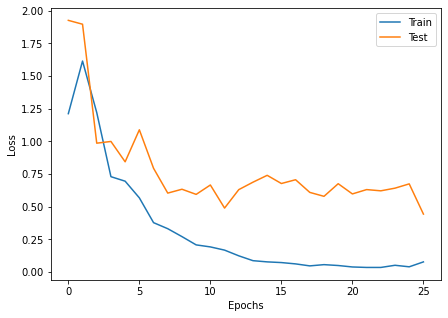

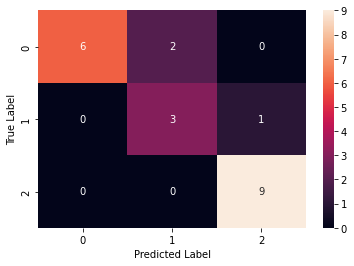

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.1101545890172322, Test Loss: 0.9900399446487427
Epoch 2-- Train Loss:1.0234060088793437, Test Loss: 1.25604248046875
Epoch 3-- Train Loss:1.195220450560252, Test Loss: 1.1619229316711426
Epoch 4-- Train Loss:1.0935750404993694, Test Loss: 0.7790154814720154
Epoch 5-- Train Loss:0.5467639565467834, Test Loss: 1.054923176765442
Epoch 6-- Train Loss:0.5431247154871622, Test Loss: 0.8177071809768677
Epoch 7-- Train Loss:0.3401452600955963, Test Loss: 0.7194298505783081
Epoch 8-- Train Loss:0.3592716455459595, Test Loss: 0.7419508695602417
Epoch 9-- Train Loss:0.22354473173618317, Test Loss: 0.6565662026405334
Epoch 10-- Train Loss:0.18865876893202463, Test Loss: 0.5916615128517151
Epoch 11-- Train Loss:0.13437978426615396, Test Loss: 0.5637607574462891
Epoch 12-- Train Loss:0.13746229310830435, Test Loss: 0.5181542634963989
Epoch 13-- Train Loss:0.0914257640639941, Test Loss: 0.5643377900123596
Epoch 14-- Train

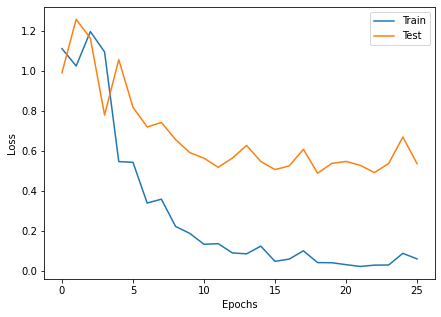

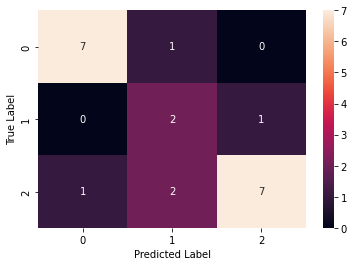

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.3675205707550049, Test Loss: 1.039372444152832
Epoch 2-- Train Loss:0.9710379044214884, Test Loss: 1.0683739185333252
Epoch 3-- Train Loss:0.8887352347373962, Test Loss: 0.8868977427482605
Epoch 4-- Train Loss:0.66276416182518, Test Loss: 1.0923570394515991
Epoch 5-- Train Loss:0.6526587009429932, Test Loss: 0.987912654876709
Epoch 6-- Train Loss:0.4611288209756215, Test Loss: 0.7197427749633789
Epoch 7-- Train Loss:0.4183550576368968, Test Loss: 0.9687459468841553
Epoch 8-- Train Loss:0.365142285823822, Test Loss: 0.9345545172691345
Epoch 9-- Train Loss:0.3244260350863139, Test Loss: 0.8746675848960876
Epoch 10-- Train Loss:0.3317021081844966, Test Loss: 0.7121601104736328
Epoch 11-- Train Loss:0.1515298088391622, Test Loss: 0.7094663381576538
Epoch 12-- Train Loss:0.14341100802024206, Test Loss: 0.7356418371200562
Epoch 13-- Train Loss:0.09857966254154842, Test Loss: 0.6745284199714661
Epoch 14-- Train Lo

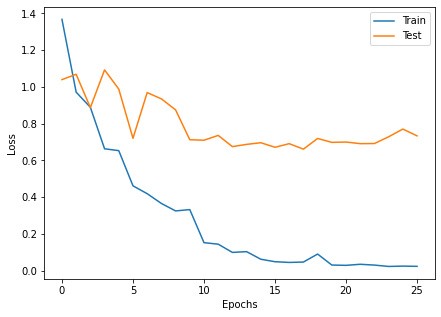

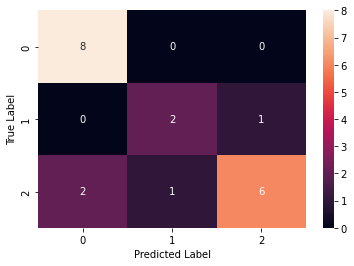

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.0933589935302734, Test Loss: 1.0148205757141113
Epoch 2-- Train Loss:0.9687394301096598, Test Loss: 1.1032236814498901
Epoch 3-- Train Loss:0.8172430793444315, Test Loss: 0.853611409664154
Epoch 4-- Train Loss:0.6975595951080322, Test Loss: 0.8284742832183838
Epoch 5-- Train Loss:0.5986807545026144, Test Loss: 1.0857142210006714
Epoch 6-- Train Loss:0.6028388639291128, Test Loss: 0.7500519752502441
Epoch 7-- Train Loss:0.4286653200785319, Test Loss: 0.6798275709152222
Epoch 8-- Train Loss:0.3092186450958252, Test Loss: 0.6216562986373901
Epoch 9-- Train Loss:0.2161839803059896, Test Loss: 0.6568143367767334
Epoch 10-- Train Loss:0.2541794627904892, Test Loss: 0.9390882849693298
Epoch 11-- Train Loss:0.19198329746723175, Test Loss: 0.6231796145439148
Epoch 12-- Train Loss:0.10547000666459401, Test Loss: 0.5367664694786072
Epoch 13-- Train Loss:0.09895291676123937, Test Loss: 0.5648636221885681
Epoch 14-- Tra

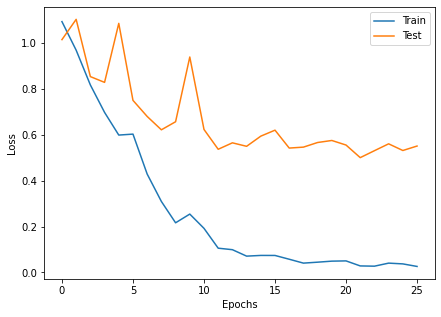

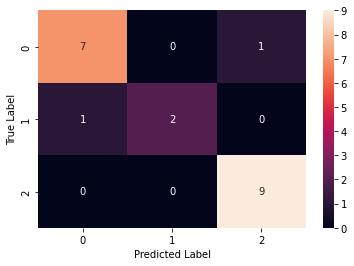

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.234405517578125, Test Loss: 1.5606749057769775
Epoch 2-- Train Loss:1.2110010584195454, Test Loss: 1.5532416105270386
Epoch 3-- Train Loss:0.8744095961252848, Test Loss: 1.1875544786453247
Epoch 4-- Train Loss:0.8973729213078817, Test Loss: 0.9276735782623291
Epoch 5-- Train Loss:0.5474574764569601, Test Loss: 1.0271241664886475
Epoch 6-- Train Loss:0.5585987468560537, Test Loss: 1.0357741117477417
Epoch 7-- Train Loss:0.41691314180692035, Test Loss: 1.0337820053100586
Epoch 8-- Train Loss:0.2693081895510356, Test Loss: 0.8701702356338501
Epoch 9-- Train Loss:0.23119150598843893, Test Loss: 0.884198009967804
Epoch 10-- Train Loss:0.20482208331425986, Test Loss: 0.8370935320854187
Epoch 11-- Train Loss:0.14673470705747604, Test Loss: 0.9201030135154724
Epoch 12-- Train Loss:0.15674369285504022, Test Loss: 0.9843432903289795
Epoch 13-- Train Loss:0.10989576826492946, Test Loss: 0.9166958928108215
Epoch 14-- T

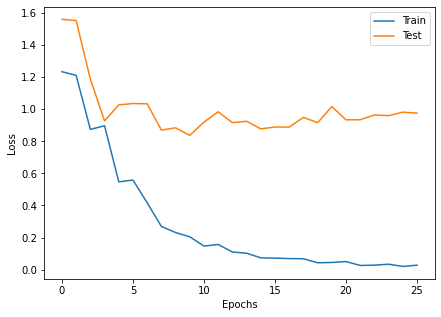

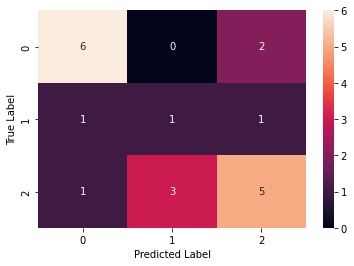

Starting testing
Training Complete
{'0': {'f1-score': '0.848±0.06',
       'precision': '0.881±0.106',
       'recall': '0.825±0.061',
       'support': 8},
 '1': {'f1-score': '0.554±0.177',
       'precision': '0.537±0.262',
       'recall': '0.617±0.145',
       'support': 4},
 '2': {'f1-score': '0.802±0.135',
       'precision': '0.831±0.104',
       'recall': '0.784±0.182',
       'support': 9},
 'accuracy': '0.774±0.104',
 'macro avg': {'f1-score': '0.735±0.114',
               'precision': '0.75±0.129',
               'recall': '0.742±0.107',
               'support': 21},
 'weighted avg': {'f1-score': '0.781±0.1',
                  'precision': '0.804±0.103',
                  'recall': '0.774±0.104',
                  'support': 21}}
{'num_epochs': 18, 'lr': 0.067, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:3.045712323415847, Test Loss: 3.167654514312744
Epoch 2-- Train Loss:1.3871354999996366, Test Loss: 0.08478079736232758
Epoch 3-- Train Lo

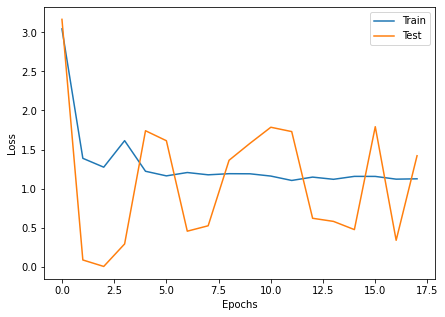

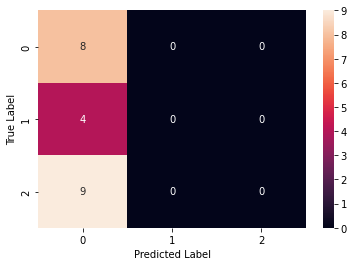

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.107972204685211, Test Loss: 3.5086116790771484
Epoch 2-- Train Loss:1.2729634940624237, Test Loss: 0.03669828549027443
Epoch 3-- Train Loss:1.325447215920403, Test Loss: 1.7494359016418457
Epoch 4-- Train Loss:1.2467299302419026, Test Loss: 0.17549139261245728
Epoch 5-- Train Loss:1.2251424732662382, Test Loss: 2.560063123703003
Epoch 6-- Train Loss:1.2028333828562783, Test Loss: 2.312777280807495
Epoch 7-- Train Loss:1.2773577968279521, Test Loss: 2.2412378787994385
Epoch 8-- Train Loss:1.158810785838536, Test Loss: 0.33449864387512207
Epoch 9-- Train Loss:1.1137820595786685, Test Loss: 0.23706023395061493
Epoch 10-- Train Loss:1.0706593933559598, Test Loss: 1.8571542501449585
Epoch 11-- Train Loss:1.083002425375439, Test Loss: 2.45994234085083
Epoch 12-- Train Loss:1.0288230436188834, Test Loss: 0.3817862272262573
Epoch 13-- Train Loss:1.0056998133659363, Test Loss: 2.899170398712158
Epoch 14-- Train Loss

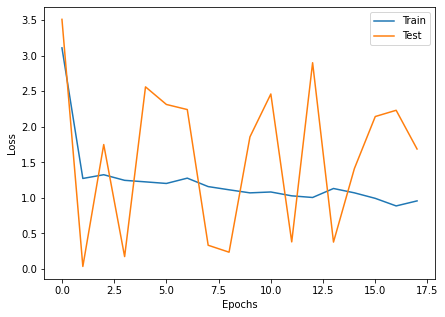

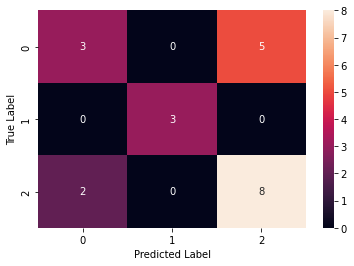

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:5.100172806353796, Test Loss: 2.4594242572784424
Epoch 2-- Train Loss:1.342289354119982, Test Loss: 1.042387843132019
Epoch 3-- Train Loss:1.243534232888903, Test Loss: 0.9293820261955261
Epoch 4-- Train Loss:1.1049214629899888, Test Loss: 1.0803030729293823
Epoch 5-- Train Loss:1.0803506970405579, Test Loss: 1.058162808418274
Epoch 6-- Train Loss:1.0077023875145685, Test Loss: 0.7729061841964722
Epoch 7-- Train Loss:1.0661137870379858, Test Loss: 0.8327274322509766
Epoch 8-- Train Loss:1.0068007849511647, Test Loss: 0.7044669389724731
Epoch 9-- Train Loss:1.0080808855238415, Test Loss: 0.7400698661804199
Epoch 10-- Train Loss:1.0126661431221735, Test Loss: 0.8326077461242676
Epoch 11-- Train Loss:1.0823507025128318, Test Loss: 1.6171852350234985
Epoch 12-- Train Loss:1.2178537533396767, Test Loss: 1.0984669923782349
Epoch 13-- Train Loss:1.0831983259746008, Test Loss: 1.6398123502731323
Epoch 14-- Train Loss

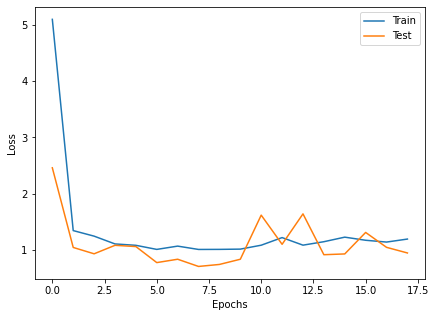

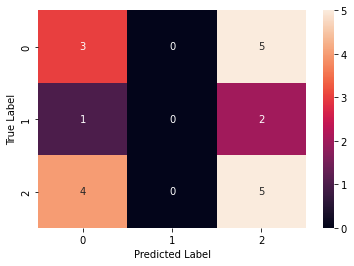

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:2.8277186212085543, Test Loss: 1.2419215440750122
Epoch 2-- Train Loss:1.2177352110544841, Test Loss: 0.7007197141647339
Epoch 3-- Train Loss:1.5133750921203977, Test Loss: 1.2318158149719238
Epoch 4-- Train Loss:1.3464387484959193, Test Loss: 1.6055898666381836
Epoch 5-- Train Loss:1.232207267057328, Test Loss: 1.406790852546692
Epoch 6-- Train Loss:1.1282341451871962, Test Loss: 1.1900830268859863
Epoch 7-- Train Loss:1.2308163387434823, Test Loss: 1.7305065393447876
Epoch 8-- Train Loss:1.1101756223610468, Test Loss: 1.5085705518722534
Epoch 9-- Train Loss:1.1056848679270064, Test Loss: 1.1147578954696655
Epoch 10-- Train Loss:1.0816355461166018, Test Loss: 0.9411442279815674
Epoch 11-- Train Loss:1.0376888059434437, Test Loss: 1.0753785371780396
Epoch 12-- Train Loss:1.0573679634502955, Test Loss: 0.7224670648574829
Epoch 13-- Train Loss:1.0337458536738442, Test Loss: 0.9602046608924866
Epoch 14-- Train L

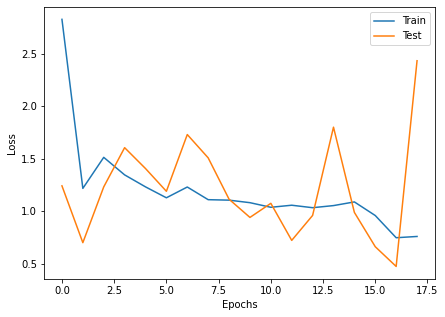

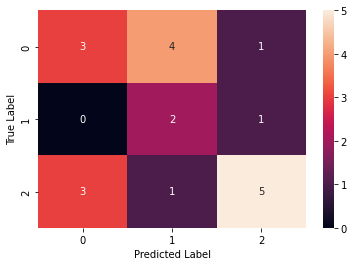

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.1915210130668825, Test Loss: 1.3469653129577637
Epoch 2-- Train Loss:1.522256226766677, Test Loss: 1.0129716396331787
Epoch 3-- Train Loss:0.9830570476395744, Test Loss: 0.6861997246742249
Epoch 4-- Train Loss:0.964637435617901, Test Loss: 0.8054478168487549
Epoch 5-- Train Loss:1.0418513530776614, Test Loss: 0.8666877746582031
Epoch 6-- Train Loss:0.9585162457965669, Test Loss: 2.934617042541504
Epoch 7-- Train Loss:0.8790830430530366, Test Loss: 2.5520832538604736
Epoch 8-- Train Loss:0.9077638217381069, Test Loss: 1.860101580619812
Epoch 9-- Train Loss:1.0566746777012235, Test Loss: 0.6638621687889099
Epoch 10-- Train Loss:0.9142426053682963, Test Loss: 0.5125788450241089
Epoch 11-- Train Loss:0.8757004908152989, Test Loss: 1.1462634801864624
Epoch 12-- Train Loss:0.9059329756668636, Test Loss: 1.9232089519500732
Epoch 13-- Train Loss:0.9176678543999082, Test Loss: 1.3140677213668823
Epoch 14-- Train Los

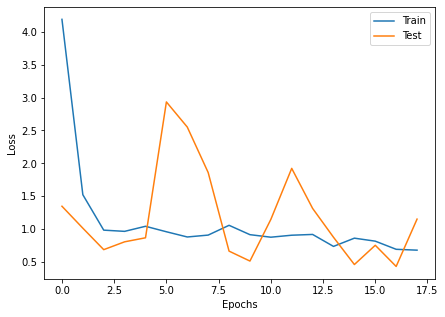

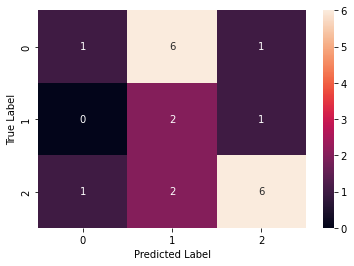

Starting testing
Training Complete
{'0': {'f1-score': '0.414±0.166',
       'precision': '0.401±0.146',
       'recall': '0.5±0.296',
       'support': 8},
 '1': {'f1-score': '0.133±0.194',
       'precision': '0.089±0.13',
       'recall': '0.267±0.389',
       'support': 4},
 '2': {'f1-score': '0.502±0.295',
       'precision': '0.568±0.347',
       'recall': '0.469±0.296',
       'support': 9},
 'accuracy': '0.45±0.137',
 'macro avg': {'f1-score': '0.35±0.143',
               'precision': '0.353±0.173',
               'recall': '0.412±0.145',
               'support': 21},
 'weighted avg': {'f1-score': '0.411±0.162',
                  'precision': '0.429±0.204',
                  'recall': '0.45±0.137',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.078, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:3.872714785012332, Test Loss: 2.772557020187378
Epoch 2-- Train Loss:1.6137542968446559, Test Loss: 0.6543115973472595
Epoch 3-- Train Loss:

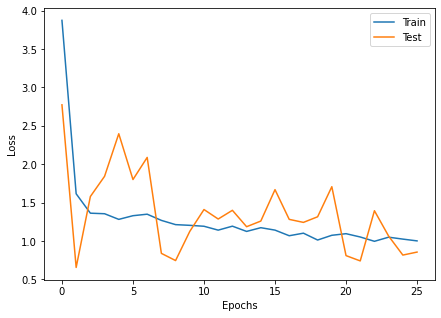

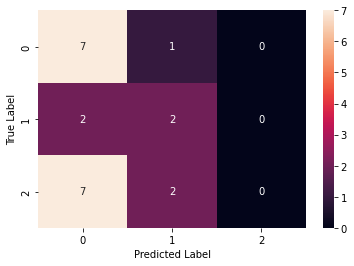

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.7534385377710517, Test Loss: 4.370832920074463
Epoch 2-- Train Loss:1.3833863653919913, Test Loss: 1.2312451601028442
Epoch 3-- Train Loss:1.3883434425700794, Test Loss: 2.119682788848877
Epoch 4-- Train Loss:1.2975480122999712, Test Loss: 0.7420990467071533
Epoch 5-- Train Loss:1.0829554362730547, Test Loss: 7.221252918243408
Epoch 6-- Train Loss:1.5096975294026462, Test Loss: 0.7418216466903687
Epoch 7-- Train Loss:1.359784180467779, Test Loss: 3.4681501388549805
Epoch 8-- Train Loss:1.3099644292484631, Test Loss: 1.2868930101394653
Epoch 9-- Train Loss:1.0024018775333057, Test Loss: 2.7256107330322266
Epoch 10-- Train Loss:1.0485629547726025, Test Loss: 0.7786840796470642
Epoch 11-- Train Loss:0.9329643005674536, Test Loss: 2.009716033935547
Epoch 12-- Train Loss:1.069299957968972, Test Loss: 0.8941721320152283
Epoch 13-- Train Loss:0.9590394361452623, Test Loss: 1.702721357345581
Epoch 14-- Train Loss:0

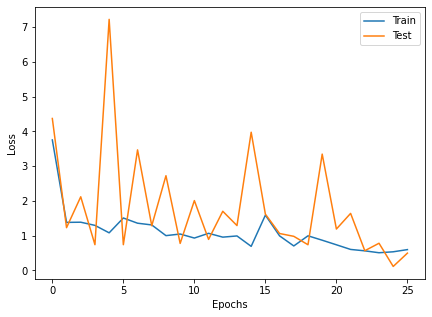

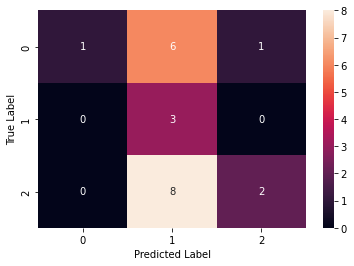

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:5.367652367461812, Test Loss: 0.9598305225372314
Epoch 2-- Train Loss:1.6325880343263799, Test Loss: 1.5408531427383423
Epoch 3-- Train Loss:1.9584372693842107, Test Loss: 2.21635103225708
Epoch 4-- Train Loss:1.2776442928747698, Test Loss: 2.152853488922119
Epoch 5-- Train Loss:1.26862493428317, Test Loss: 0.5967592000961304
Epoch 6-- Train Loss:1.1407790238207036, Test Loss: 1.5281555652618408
Epoch 7-- Train Loss:1.1724928129803052, Test Loss: 0.6279336810112
Epoch 8-- Train Loss:1.0888833511959424, Test Loss: 1.6927897930145264
Epoch 9-- Train Loss:1.262756808237596, Test Loss: 1.9084683656692505
Epoch 10-- Train Loss:1.3144143657250837, Test Loss: 0.9763988256454468
Epoch 11-- Train Loss:1.1668026609854265, Test Loss: 1.055991291999817
Epoch 12-- Train Loss:1.0342006574977527, Test Loss: 1.4579774141311646
Epoch 13-- Train Loss:1.088928385214372, Test Loss: 0.8398278951644897
Epoch 14-- Train Loss:1.0775

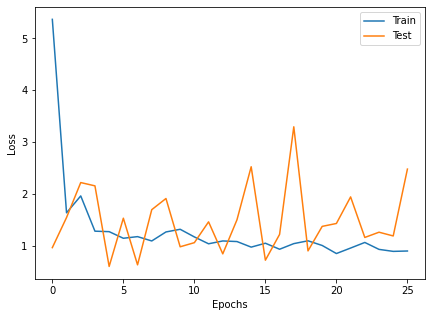

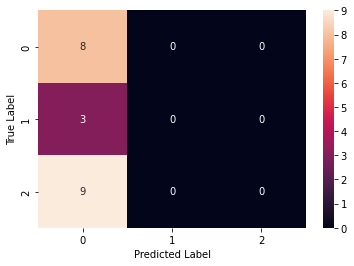

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.833976539698514, Test Loss: 1.5656993389129639
Epoch 2-- Train Loss:1.4356012832034717, Test Loss: 3.238879680633545
Epoch 3-- Train Loss:1.431220981207761, Test Loss: 1.155220866203308
Epoch 4-- Train Loss:1.3745614127679304, Test Loss: 0.9355001449584961
Epoch 5-- Train Loss:1.1849745837124912, Test Loss: 1.8579152822494507
Epoch 6-- Train Loss:1.1875518397851423, Test Loss: 1.185226559638977
Epoch 7-- Train Loss:1.142431616783142, Test Loss: 0.9376329779624939
Epoch 8-- Train Loss:1.0185421109199524, Test Loss: 0.6613810658454895
Epoch 9-- Train Loss:1.1762207042087207, Test Loss: 1.4442089796066284
Epoch 10-- Train Loss:1.1185964129187844, Test Loss: 2.3822224140167236
Epoch 11-- Train Loss:1.18405512788079, Test Loss: 1.2712810039520264
Epoch 12-- Train Loss:1.1031513214111328, Test Loss: 0.8707732558250427
Epoch 13-- Train Loss:1.0679772279479287, Test Loss: 0.7700152397155762
Epoch 14-- Train Loss:0.

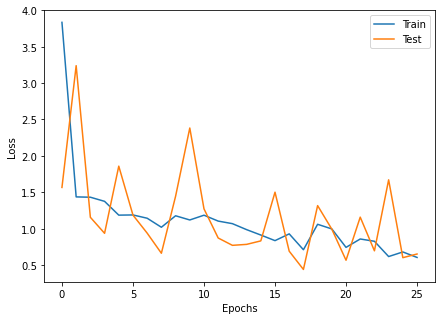

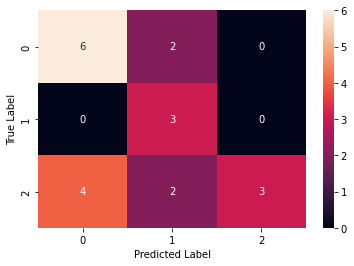

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:5.350528847087514, Test Loss: 1.7028905153274536
Epoch 2-- Train Loss:1.7662120949138294, Test Loss: 1.7464263439178467
Epoch 3-- Train Loss:1.3904759016903965, Test Loss: 0.6329334378242493
Epoch 4-- Train Loss:1.295412302017212, Test Loss: 1.060398817062378
Epoch 5-- Train Loss:1.3223924745212903, Test Loss: 1.4051109552383423
Epoch 6-- Train Loss:1.1667631322687322, Test Loss: 2.0979983806610107
Epoch 7-- Train Loss:1.1065204251896252, Test Loss: 1.3841193914413452
Epoch 8-- Train Loss:1.2598439346660266, Test Loss: 1.9210675954818726
Epoch 9-- Train Loss:1.2381788600574841, Test Loss: 0.921254575252533
Epoch 10-- Train Loss:1.248688741163774, Test Loss: 1.3813375234603882
Epoch 11-- Train Loss:1.214387525211681, Test Loss: 1.0734308958053589
Epoch 12-- Train Loss:1.1324080553921787, Test Loss: 0.8912611603736877
Epoch 13-- Train Loss:1.1543948975476352, Test Loss: 1.4507814645767212
Epoch 14-- Train Loss:

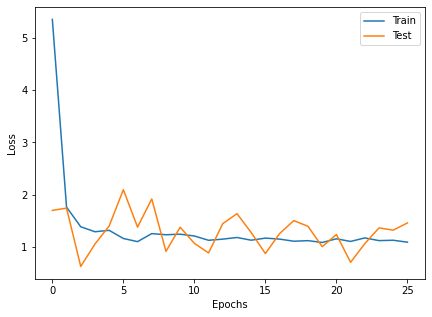

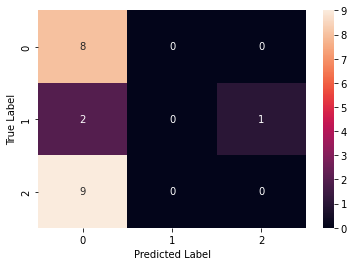

Starting testing
Training Complete
{'0': {'f1-score': '0.578±0.14',
       'precision': '0.595±0.251',
       'recall': '0.775±0.278',
       'support': 8},
 '1': {'f1-score': '0.33±0.298',
       'precision': '0.258±0.25',
       'recall': '0.55±0.458',
       'support': 4},
 '2': {'f1-score': '0.235±0.299',
       'precision': '0.4±0.49',
       'recall': '0.171±0.225',
       'support': 9},
 'accuracy': '0.472±0.14',
 'macro avg': {'f1-score': '0.381±0.198',
               'precision': '0.417±0.276',
               'recall': '0.499±0.174',
               'support': 21},
 'weighted avg': {'f1-score': '0.39±0.193',
                  'precision': '0.461±0.328',
                  'recall': '0.472±0.14',
                  'support': 21}}
{'num_epochs': 6, 'lr': 0.048, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.0697131781350997, Test Loss: 3.1584181785583496
Epoch 2-- Train Loss:1.638442045166379, Test Loss: 0.017337549477815628
Epoch 3-- Train Loss:1.

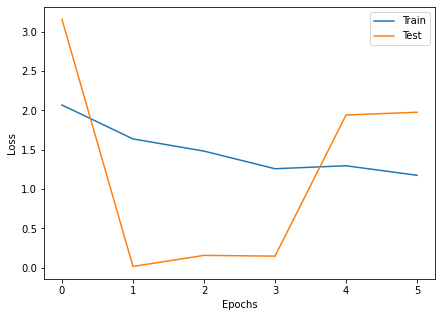

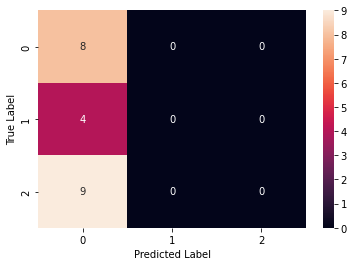

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.2296302247615087, Test Loss: 0.0009708458092063665
Epoch 2-- Train Loss:1.4968828104791188, Test Loss: 0.09618492424488068
Epoch 3-- Train Loss:1.2527111201059251, Test Loss: 0.2204679697751999
Epoch 4-- Train Loss:1.0981217111860002, Test Loss: 3.3422491550445557
Epoch 5-- Train Loss:1.048221393710091, Test Loss: 2.5811212062835693
Epoch 6-- Train Loss:1.0452945814246224, Test Loss: 3.050318479537964


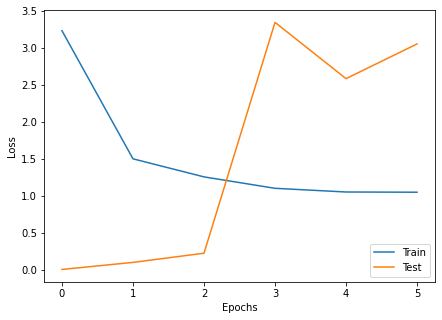

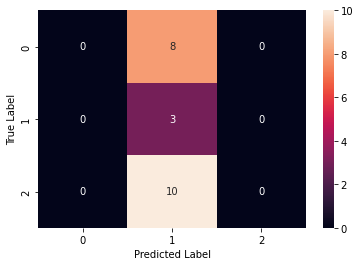

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:3.228933493296305, Test Loss: 2.3813579082489014
Epoch 2-- Train Loss:1.278947875613258, Test Loss: 1.3139246702194214
Epoch 3-- Train Loss:1.1343246073949904, Test Loss: 0.8524963855743408
Epoch 4-- Train Loss:1.2916481409754073, Test Loss: 1.0598400831222534
Epoch 5-- Train Loss:1.139126249722072, Test Loss: 1.6411798000335693
Epoch 6-- Train Loss:1.168379389104389, Test Loss: 1.4401684999465942


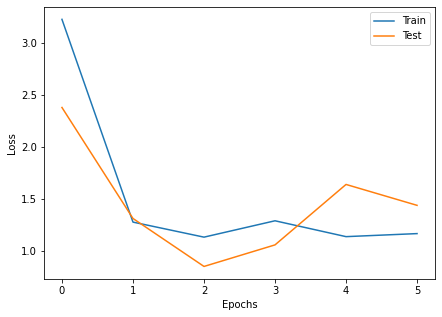

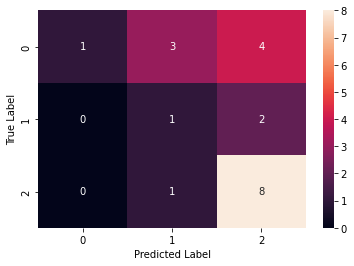

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.504965992200942, Test Loss: 1.2827579975128174
Epoch 2-- Train Loss:1.4560859487170266, Test Loss: 1.221816062927246
Epoch 3-- Train Loss:1.361572958174206, Test Loss: 1.1823933124542236
Epoch 4-- Train Loss:1.2514930083638145, Test Loss: 0.6995722651481628
Epoch 5-- Train Loss:1.2028932202429998, Test Loss: 0.8678016662597656
Epoch 6-- Train Loss:1.1470742026964824, Test Loss: 1.2844208478927612


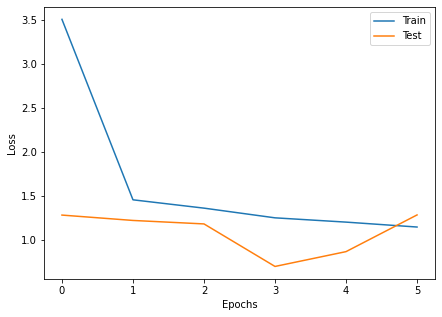

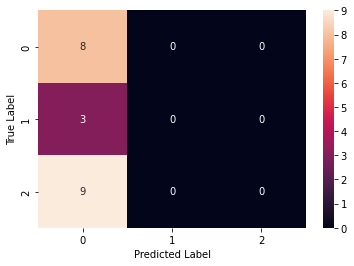

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.5186175931067694, Test Loss: 0.6332556009292603
Epoch 2-- Train Loss:1.3733326508885337, Test Loss: 1.4587424993515015
Epoch 3-- Train Loss:1.323123934723082, Test Loss: 1.486604928970337
Epoch 4-- Train Loss:1.1408035712582725, Test Loss: 0.787982165813446
Epoch 5-- Train Loss:1.142533881323678, Test Loss: 1.4317251443862915
Epoch 6-- Train Loss:1.0617038635980516, Test Loss: 0.9894540309906006


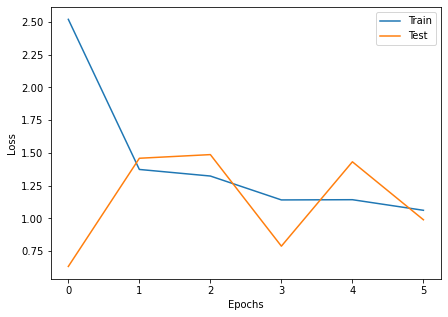

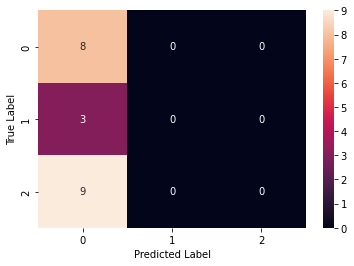

Starting testing
Training Complete
{'0': {'f1-score': '0.339±0.277',
       'precision': '0.236±0.193',
       'recall': '0.6±0.49',
       'support': 8},
 '1': {'f1-score': '0.094±0.116',
       'precision': '0.062±0.076',
       'recall': '0.267±0.389',
       'support': 4},
 '2': {'f1-score': '0.114±0.229',
       'precision': '0.1±0.2',
       'recall': '0.133±0.267',
       'support': 9},
 'accuracy': '0.335±0.098',
 'macro avg': {'f1-score': '0.183±0.058',
               'precision': '0.133±0.055',
               'recall': '0.333±0.0',
               'support': 21},
 'weighted avg': {'f1-score': '0.199±0.086',
                  'precision': '0.147±0.073',
                  'recall': '0.335±0.098',
                  'support': 21}}
{'num_epochs': 22, 'lr': 0.014000000000000002, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.4156312048435211, Test Loss: 2.6996796131134033
Epoch 2-- Train Loss:1.4659222513437271, Test Loss: 0.713953971862793
Epoch 3

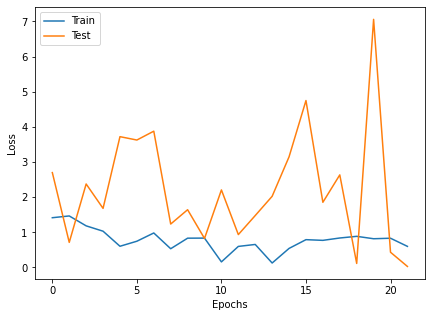

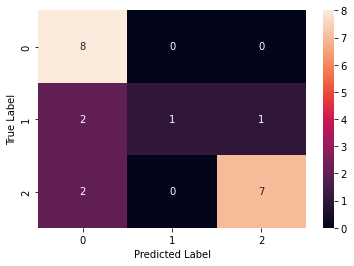

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.435087502002716, Test Loss: 3.8812923431396484
Epoch 2-- Train Loss:1.4069556891918182, Test Loss: 3.4142324924468994
Epoch 3-- Train Loss:1.5446372131506603, Test Loss: 2.6173810958862305
Epoch 4-- Train Loss:0.9745264053344727, Test Loss: 1.8307881355285645
Epoch 5-- Train Loss:0.5534105251232783, Test Loss: 3.9174184799194336
Epoch 6-- Train Loss:0.6922242045402527, Test Loss: 3.604095697402954
Epoch 7-- Train Loss:0.5116236843168736, Test Loss: 2.5862185955047607
Epoch 8-- Train Loss:0.3134261245528857, Test Loss: 0.1985466182231903
Epoch 9-- Train Loss:0.6627874169498682, Test Loss: 2.992818593978882
Epoch 10-- Train Loss:0.49953699484467506, Test Loss: 0.06273700296878815
Epoch 11-- Train Loss:0.7819557388623556, Test Loss: 2.381588935852051
Epoch 12-- Train Loss:0.546192896241943, Test Loss: 2.4442458152770996
Epoch 13-- Train Loss:0.7315335899281005, Test Loss: 4.717560291290283
Epoch 14-- Train Los

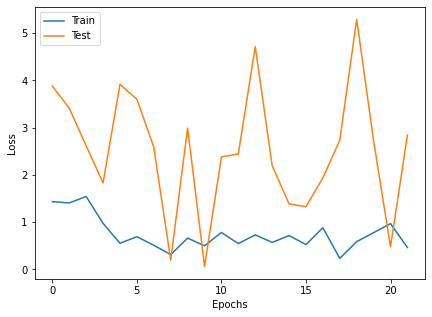

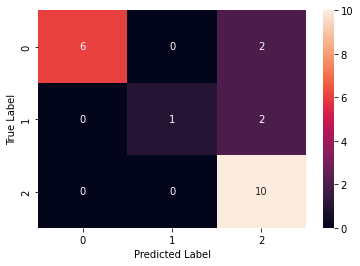

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.0716039538383484, Test Loss: 1.3887752294540405
Epoch 2-- Train Loss:1.1010320981343586, Test Loss: 3.3940792083740234
Epoch 3-- Train Loss:0.9491471449534098, Test Loss: 0.5144594311714172
Epoch 4-- Train Loss:0.7128994812568029, Test Loss: 1.0713406801223755
Epoch 5-- Train Loss:0.7341728135943413, Test Loss: 1.8913518190383911
Epoch 6-- Train Loss:0.5070951208472252, Test Loss: 2.6886491775512695
Epoch 7-- Train Loss:0.5282552763819695, Test Loss: 0.9415952563285828
Epoch 8-- Train Loss:0.1564856426169475, Test Loss: 0.6700626611709595
Epoch 9-- Train Loss:0.10235523603235681, Test Loss: 0.6276608109474182
Epoch 10-- Train Loss:0.044651614502072334, Test Loss: 1.8369169235229492
Epoch 11-- Train Loss:0.20055470475926995, Test Loss: 4.368688106536865
Epoch 12-- Train Loss:0.46457841185232, Test Loss: 3.4894840717315674
Epoch 13-- Train Loss:0.39953737147152424, Test Loss: 0.49038606882095337
Epoch 14-- Tr

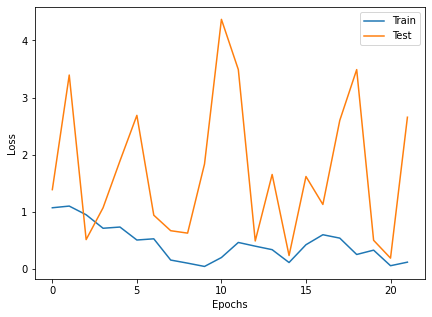

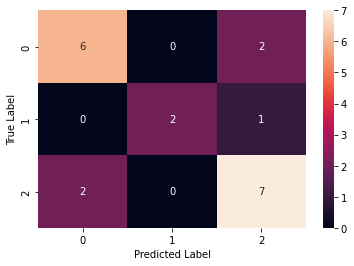

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.0221403340498607, Test Loss: 2.5514092445373535
Epoch 2-- Train Loss:1.0262169142564137, Test Loss: 4.272762298583984
Epoch 3-- Train Loss:1.1930774748325348, Test Loss: 1.5192638635635376
Epoch 4-- Train Loss:0.5024508684873581, Test Loss: 0.18039517104625702
Epoch 5-- Train Loss:0.3159993886947632, Test Loss: 0.634983241558075
Epoch 6-- Train Loss:0.31736264874537784, Test Loss: 3.533726930618286
Epoch 7-- Train Loss:0.2996086912850539, Test Loss: 0.31930243968963623
Epoch 8-- Train Loss:0.20995611449082693, Test Loss: 2.048175811767578
Epoch 9-- Train Loss:0.6410536790887514, Test Loss: 3.1561543941497803
Epoch 10-- Train Loss:0.5902568312982718, Test Loss: 3.4052579402923584
Epoch 11-- Train Loss:0.4259688618282477, Test Loss: 0.371640682220459
Epoch 12-- Train Loss:0.28396157423655194, Test Loss: 1.0439817905426025
Epoch 13-- Train Loss:0.12237649410963058, Test Loss: 1.1136505603790283
Epoch 14-- Trai

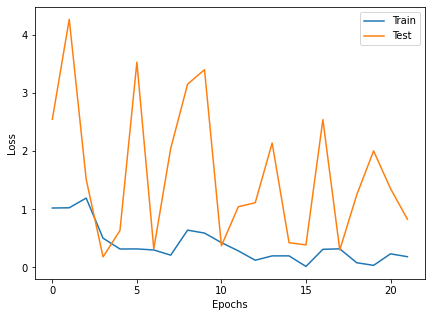

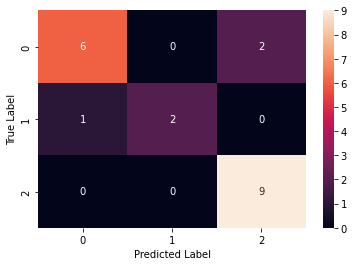

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.4848475058873494, Test Loss: 0.8534788489341736
Epoch 2-- Train Loss:1.2793519000212352, Test Loss: 3.595825672149658
Epoch 3-- Train Loss:1.3577019224564235, Test Loss: 2.448458194732666
Epoch 4-- Train Loss:0.4092077265183131, Test Loss: 0.21439024806022644
Epoch 5-- Train Loss:0.3251759136716525, Test Loss: 1.3963520526885986
Epoch 6-- Train Loss:0.3954440268377463, Test Loss: 6.171380043029785
Epoch 7-- Train Loss:0.4858982612689336, Test Loss: 5.8072733879089355
Epoch 8-- Train Loss:0.5657751361529032, Test Loss: 5.2081828117370605
Epoch 9-- Train Loss:0.40771722172697383, Test Loss: 1.1490654945373535
Epoch 10-- Train Loss:0.0751610950877269, Test Loss: 0.3451893627643585
Epoch 11-- Train Loss:0.04620759841054678, Test Loss: 0.2705446481704712
Epoch 12-- Train Loss:0.39579810574650764, Test Loss: 1.8520572185516357
Epoch 13-- Train Loss:0.46337967583288747, Test Loss: 0.29722562432289124
Epoch 14-- Tr

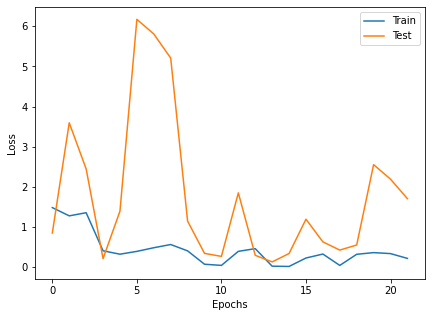

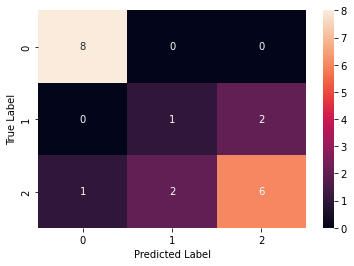

Starting testing
Training Complete
{'0': {'f1-score': '0.821±0.084',
       'precision': '0.804±0.129',
       'recall': '0.875±0.158',
       'support': 8},
 '1': {'f1-score': '0.553±0.157',
       'precision': '0.833±0.211',
       'recall': '0.45±0.18',
       'support': 4},
 '2': {'f1-score': '0.806±0.131',
       'precision': '0.818±0.159',
       'recall': '0.822±0.181',
       'support': 9},
 'accuracy': '0.784±0.098',
 'macro avg': {'f1-score': '0.727±0.095',
               'precision': '0.819±0.114',
               'recall': '0.716±0.089',
               'support': 21},
 'weighted avg': {'f1-score': '0.771±0.098',
                  'precision': '0.815±0.099',
                  'recall': '0.784±0.098',
                  'support': 21}}


In [36]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='resnet50'
    results = train_model(name=name, dataset=dataset, k_folds =5,  **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )

## 3.3 Big Transfer (BiT)

The model was proposed in this paper: https://arxiv.org/abs/1912.11370






In [43]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-4,1e-2, 1e-3)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(10,50, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 46, 'lr': 0.0001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.3486628631750743, Test Loss: 1.2714197635650635
Epoch 2-- Train Loss:1.0789705117543538, Test Loss: 1.3415467739105225
Epoch 3-- Train Loss:1.1622687081495922, Test Loss: 0.7432994246482849
Epoch 4-- Train Loss:0.9552438159783682, Test Loss: 0.9491682648658752
Epoch 5-- Train Loss:0.8445883889993032, Test Loss: 1.1346728801727295
Epoch 6-- Train Loss:0.804964691400528, Test Loss: 0.8646690249443054
Epoch 7-- Train Loss:0.6943607280651728, Test Loss: 0.714041531085968
Epoch 8-- Train Loss:0.7045531074206034, Test Loss: 0.7231897711753845
Epoch 9-- Train Loss:0.6844158371289571, Test Loss: 0.39315682649612427
Epoch 10-- Train Loss:0.6455301543076833, Test Loss: 0.4560553729534149
Epoch 11-- Train Loss:0.5019873641431332, Test Loss: 0.5573620796203613
Epoch 12-- Train Loss:0.5998219350973765, Test Loss: 0.8679092526435852
Epoch 13-- Train Loss:0.6540543437004089, Test Loss: 0.

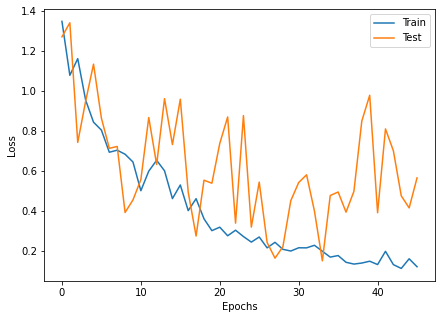

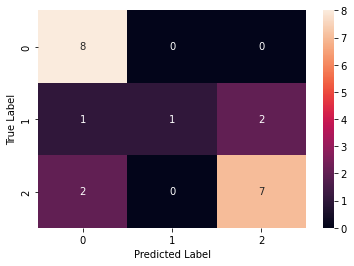

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.5225254893302917, Test Loss: 1.2647398710250854
Epoch 2-- Train Loss:1.147114376227061, Test Loss: 0.5858713984489441
Epoch 3-- Train Loss:1.213329553604126, Test Loss: 1.2105485200881958
Epoch 4-- Train Loss:0.9822944899400076, Test Loss: 1.2276222705841064
Epoch 5-- Train Loss:0.8965856929620107, Test Loss: 0.8639350533485413
Epoch 6-- Train Loss:0.8831270138422648, Test Loss: 0.9648733735084534
Epoch 7-- Train Loss:0.7020261983076731, Test Loss: 1.0296969413757324
Epoch 8-- Train Loss:0.683716873327891, Test Loss: 0.8030332922935486
Epoch 9-- Train Loss:0.621082623799642, Test Loss: 1.625463843345642
Epoch 10-- Train Loss:0.5604476481676102, Test Loss: 0.9027107357978821
Epoch 11-- Train Loss:0.5198149730761846, Test Loss: 1.083030343055725
Epoch 12-- Train Loss:0.49936364591121674, Test Loss: 1.0042273998260498
Epoch 13-- Train Loss:0.48717642823855084, Test Loss: 0.3704129159450531
Epoch 14-- Train Los

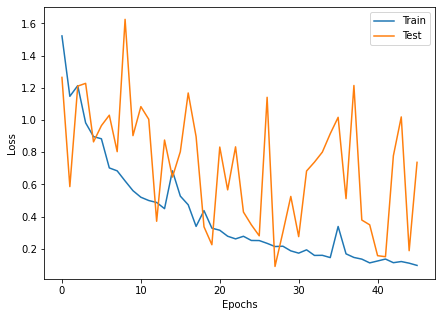

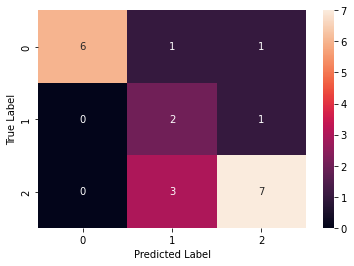

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.0949771702289581, Test Loss: 1.134998083114624
Epoch 2-- Train Loss:1.0948070685068767, Test Loss: 0.6421052813529968
Epoch 3-- Train Loss:0.9091847538948059, Test Loss: 1.378979206085205
Epoch 4-- Train Loss:0.8658732374509176, Test Loss: 0.5785293579101562
Epoch 5-- Train Loss:0.813297301530838, Test Loss: 1.0234944820404053
Epoch 6-- Train Loss:0.6690882245699564, Test Loss: 0.9266753792762756
Epoch 7-- Train Loss:0.6774499515692393, Test Loss: 0.9038825631141663
Epoch 8-- Train Loss:0.6187727500995001, Test Loss: 0.7966030240058899
Epoch 9-- Train Loss:0.5790406614542007, Test Loss: 0.7164974212646484
Epoch 10-- Train Loss:0.5540404518445333, Test Loss: 0.8778901100158691
Epoch 11-- Train Loss:0.5150095224380493, Test Loss: 0.7516739368438721
Epoch 12-- Train Loss:0.49194525678952533, Test Loss: 0.9363875389099121
Epoch 13-- Train Loss:0.4223761012156804, Test Loss: 0.6674624681472778
Epoch 14-- Train L

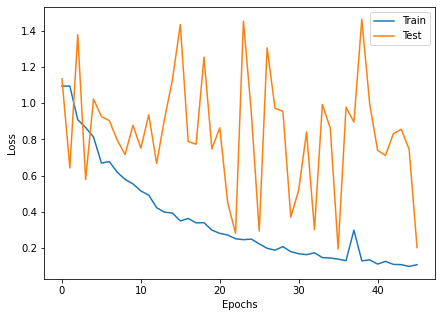

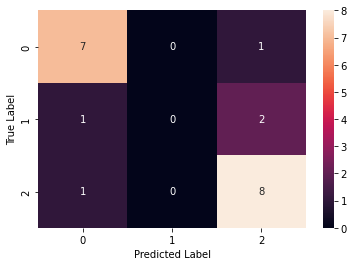

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.1007948815822601, Test Loss: 0.5438940525054932
Epoch 2-- Train Loss:1.0292345583438873, Test Loss: 1.2030556201934814
Epoch 3-- Train Loss:0.9384521842002869, Test Loss: 0.9090700745582581
Epoch 4-- Train Loss:0.8991547723611196, Test Loss: 0.5649817585945129
Epoch 5-- Train Loss:0.8120449384053549, Test Loss: 0.908859372138977
Epoch 6-- Train Loss:0.7897868653138479, Test Loss: 0.2828945517539978
Epoch 7-- Train Loss:0.6806963781515757, Test Loss: 0.5487958192825317
Epoch 8-- Train Loss:0.6514156957467397, Test Loss: 0.7561713457107544
Epoch 9-- Train Loss:0.6556326150894165, Test Loss: 0.7100780010223389
Epoch 10-- Train Loss:0.5447972963253657, Test Loss: 0.37729230523109436
Epoch 11-- Train Loss:0.487045057117939, Test Loss: 0.8194249272346497
Epoch 12-- Train Loss:0.5940054853757223, Test Loss: 0.7675544619560242
Epoch 13-- Train Loss:0.5114011863867441, Test Loss: 0.23054663836956024
Epoch 14-- Train

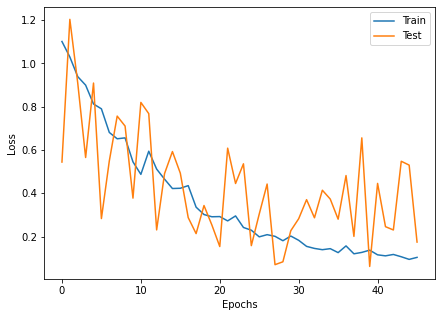

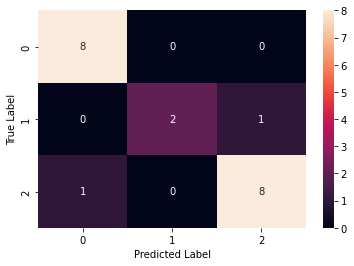

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.3168006936709087, Test Loss: 1.4329901933670044
Epoch 2-- Train Loss:1.1974767446517944, Test Loss: 0.9831809401512146
Epoch 3-- Train Loss:1.1505682269732158, Test Loss: 1.0137817859649658
Epoch 4-- Train Loss:0.9496896266937256, Test Loss: 0.8787071108818054
Epoch 5-- Train Loss:0.9185877243677775, Test Loss: 0.8924341201782227
Epoch 6-- Train Loss:0.8049295047918955, Test Loss: 1.0617341995239258
Epoch 7-- Train Loss:0.7870059212048849, Test Loss: 1.4282994270324707
Epoch 8-- Train Loss:0.6870772341887156, Test Loss: 0.9166424870491028
Epoch 9-- Train Loss:0.6241110066572825, Test Loss: 0.7825220227241516
Epoch 10-- Train Loss:0.6003435850143433, Test Loss: 1.013666033744812
Epoch 11-- Train Loss:0.6856103340784708, Test Loss: 1.1203396320343018
Epoch 12-- Train Loss:0.5760970165332159, Test Loss: 0.9633306264877319
Epoch 13-- Train Loss:0.48204222818215686, Test Loss: 0.7351491451263428
Epoch 14-- Train

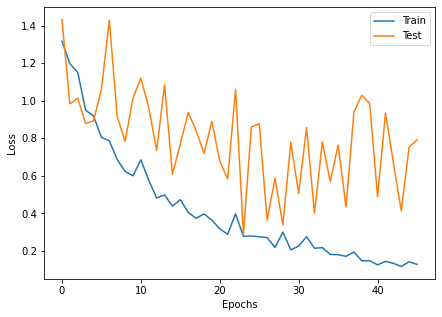

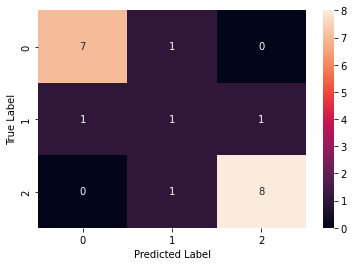

Starting testing
Training Complete
{'0': {'f1-score': '0.855±0.037',
       'precision': '0.822±0.037',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.46±0.293',
       'precision': '0.483±0.351',
       'recall': '0.5±0.333',
       'support': 4},
 '2': {'f1-score': '0.787±0.071',
       'precision': '0.829±0.102',
       'recall': '0.764±0.116',
       'support': 9},
 'accuracy': '0.775±0.063',
 'macro avg': {'f1-score': '0.701±0.107',
               'precision': '0.711±0.134',
               'recall': '0.721±0.1',
               'support': 21},
 'weighted avg': {'f1-score': '0.764±0.064',
                  'precision': '0.776±0.084',
                  'recall': '0.775±0.063',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0081, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:7.296430091063182, Test Loss: 4.5580973625183105
Epoch 2-- Train Loss:3.0199666718641915, Test Loss: 3.5545599460601807
Epoch 3-- Train Los

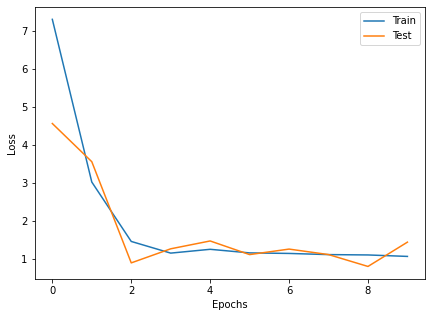

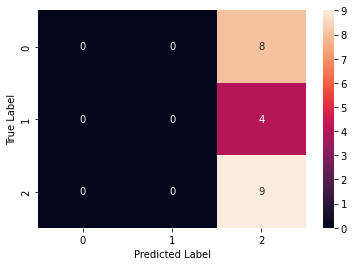

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:7.770596186319987, Test Loss: 4.055522918701172
Epoch 2-- Train Loss:1.9365350008010864, Test Loss: 1.6158970594406128
Epoch 3-- Train Loss:1.3488529721895854, Test Loss: 2.392571210861206
Epoch 4-- Train Loss:1.1317206919193268, Test Loss: 1.526194453239441
Epoch 5-- Train Loss:1.152038464943568, Test Loss: 2.0156166553497314
Epoch 6-- Train Loss:1.1958091656366985, Test Loss: 1.2014515399932861
Epoch 7-- Train Loss:1.0889715949694316, Test Loss: 1.2571614980697632
Epoch 8-- Train Loss:1.539756864309311, Test Loss: 2.020402193069458
Epoch 9-- Train Loss:1.2080063025156658, Test Loss: 1.7620172500610352
Epoch 10-- Train Loss:1.169976532459259, Test Loss: 0.9212404489517212


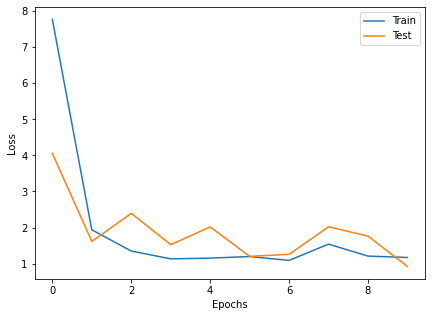

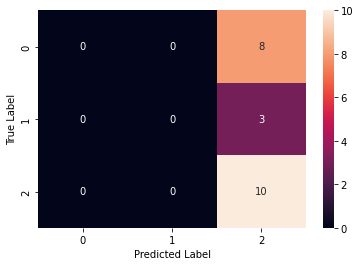

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:5.280856102705002, Test Loss: 4.994413375854492
Epoch 2-- Train Loss:9.692501068115234, Test Loss: 1.5572980642318726
Epoch 3-- Train Loss:1.2781525651613872, Test Loss: 0.03551774099469185
Epoch 4-- Train Loss:1.305602103471756, Test Loss: 2.2801594734191895
Epoch 5-- Train Loss:1.3483365575472515, Test Loss: 2.1024234294891357
Epoch 6-- Train Loss:1.155765563249588, Test Loss: 2.5190088748931885
Epoch 7-- Train Loss:1.2942914565404255, Test Loss: 1.163487195968628
Epoch 8-- Train Loss:1.2072066167990367, Test Loss: 1.456681489944458
Epoch 9-- Train Loss:1.18697323401769, Test Loss: 1.5215167999267578
Epoch 10-- Train Loss:1.1963168780008953, Test Loss: 1.0414658784866333


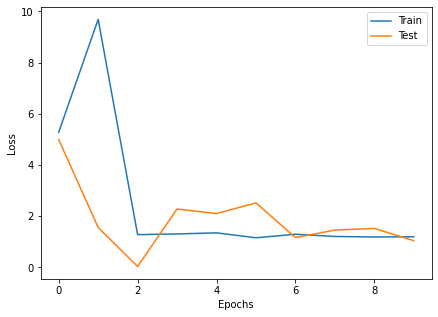

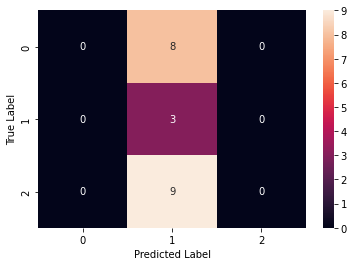

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:4.458109180132548, Test Loss: 5.868168830871582
Epoch 2-- Train Loss:2.2825717826684317, Test Loss: 2.7428205013275146
Epoch 3-- Train Loss:1.3360570073127747, Test Loss: 0.8840100765228271
Epoch 4-- Train Loss:1.202545960744222, Test Loss: 1.8268394470214844
Epoch 5-- Train Loss:1.2899110913276672, Test Loss: 3.1136646270751953
Epoch 6-- Train Loss:1.2911428610483806, Test Loss: 0.7477536797523499
Epoch 7-- Train Loss:1.116535594065984, Test Loss: 1.0053150653839111
Epoch 8-- Train Loss:1.0616358419259389, Test Loss: 1.1229281425476074
Epoch 9-- Train Loss:1.4778303106625874, Test Loss: 1.692916750907898
Epoch 10-- Train Loss:1.0869020919005077, Test Loss: 1.4183323383331299


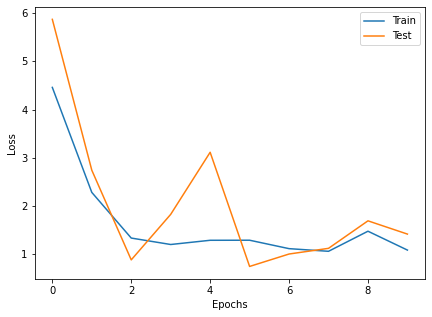

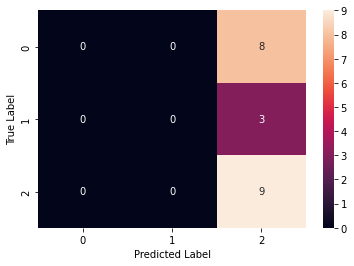

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:10.582426309585571, Test Loss: 11.803624153137207
Epoch 2-- Train Loss:4.962173044681549, Test Loss: 6.313303470611572
Epoch 3-- Train Loss:2.1124864319960275, Test Loss: 0.7554684281349182
Epoch 4-- Train Loss:1.1374940872192383, Test Loss: 1.8139362335205078
Epoch 5-- Train Loss:1.0520090659459431, Test Loss: 1.5015463829040527
Epoch 6-- Train Loss:1.1692936817804973, Test Loss: 1.4790621995925903
Epoch 7-- Train Loss:1.2263033787409465, Test Loss: 1.3243087530136108
Epoch 8-- Train Loss:1.0867660442988079, Test Loss: 1.518254041671753
Epoch 9-- Train Loss:0.9939661920070648, Test Loss: 1.463282585144043
Epoch 10-- Train Loss:1.0321740706761677, Test Loss: 1.5179105997085571


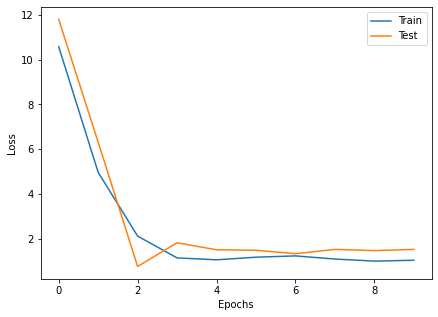

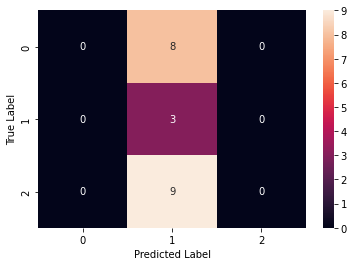

Starting testing
Training Complete
{'0': {'f1-score': '0.0±0.0',
       'precision': '0.0±0.0',
       'recall': '0.0±0.0',
       'support': 8},
 '1': {'f1-score': '0.104±0.128',
       'precision': '0.06±0.073',
       'recall': '0.4±0.49',
       'support': 4},
 '2': {'f1-score': '0.373±0.305',
       'precision': '0.271±0.222',
       'recall': '0.6±0.49',
       'support': 9},
 'accuracy': '0.331±0.149',
 'macro avg': {'f1-score': '0.159±0.059',
               'precision': '0.11±0.05',
               'recall': '0.333±0.0',
               'support': 21},
 'weighted avg': {'f1-score': '0.184±0.12',
                  'precision': '0.132±0.09',
                  'recall': '0.331±0.149',
                  'support': 21}}
{'num_epochs': 22, 'lr': 0.0031, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.9888210821719396, Test Loss: 0.06576292216777802
Epoch 2-- Train Loss:1.2291521657080877, Test Loss: 0.09092985838651657
Epoch 3-- Train Loss:1.095968118735

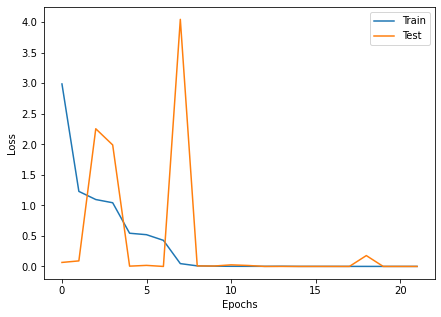

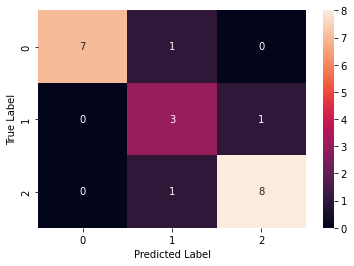

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.111549733650117, Test Loss: 0.053287576884031296
Epoch 2-- Train Loss:1.3749076880159832, Test Loss: 2.243237257003784
Epoch 3-- Train Loss:1.2091916430564154, Test Loss: 1.604275107383728
Epoch 4-- Train Loss:2.011561862060002, Test Loss: 2.149594783782959
Epoch 5-- Train Loss:1.1158180790288108, Test Loss: 1.323858618736267
Epoch 6-- Train Loss:0.849082621790114, Test Loss: 3.22708797454834
Epoch 7-- Train Loss:0.7771035823084059, Test Loss: 0.04857086017727852
Epoch 8-- Train Loss:0.8840227538631076, Test Loss: 0.14778488874435425
Epoch 9-- Train Loss:0.6071139673391978, Test Loss: 1.4754525423049927
Epoch 10-- Train Loss:0.4999655130363646, Test Loss: 1.5247951745986938
Epoch 11-- Train Loss:0.14054889081134683, Test Loss: 18.084474563598633
Epoch 12-- Train Loss:0.9135534907025951, Test Loss: 0.7433789372444153
Epoch 13-- Train Loss:0.34108557028784636, Test Loss: 0.12380912154912949
Epoch 14-- Train L

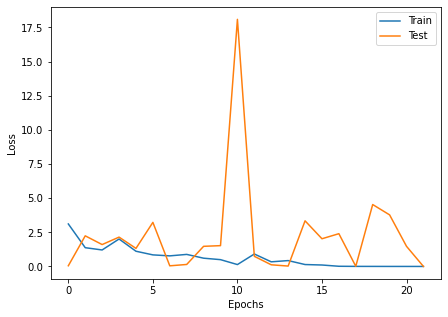

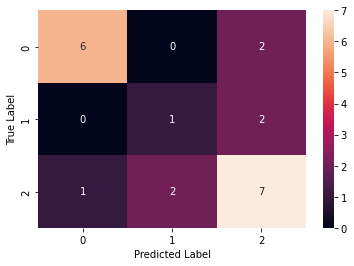

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:3.3835965324015844, Test Loss: 4.309764862060547
Epoch 2-- Train Loss:1.4701369078386397, Test Loss: 0.535742461681366
Epoch 3-- Train Loss:0.6478035749778861, Test Loss: 1.1429846286773682
Epoch 4-- Train Loss:0.34080694493882, Test Loss: 0.469083309173584
Epoch 5-- Train Loss:0.32845549282085684, Test Loss: 0.753711462020874
Epoch 6-- Train Loss:0.05466750360626195, Test Loss: 0.024908464401960373
Epoch 7-- Train Loss:0.012789016672676163, Test Loss: 0.6870391964912415
Epoch 8-- Train Loss:0.004060098701128958, Test Loss: 1.7028696537017822
Epoch 9-- Train Loss:0.0025169736091768193, Test Loss: 0.7205889225006104
Epoch 10-- Train Loss:0.0020486012143096774, Test Loss: 0.06169935315847397
Epoch 11-- Train Loss:0.001418368100920426, Test Loss: 0.04280022531747818
Epoch 12-- Train Loss:0.0012488895502299005, Test Loss: 1.5665267705917358
Epoch 13-- Train Loss:0.008730906592973042, Test Loss: 3.4192285537719727

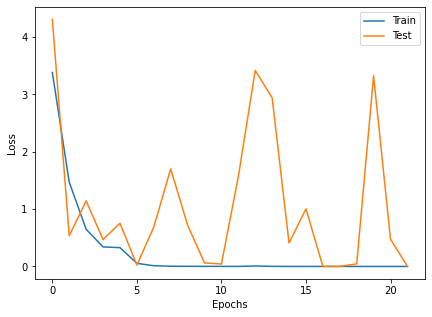

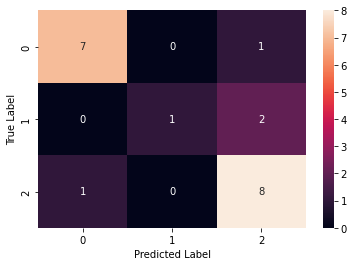

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.9365590924308416, Test Loss: 1.8631757497787476
Epoch 2-- Train Loss:1.1636986278352284, Test Loss: 1.1273486614227295
Epoch 3-- Train Loss:0.9532912380638576, Test Loss: 0.3753308355808258
Epoch 4-- Train Loss:0.6388415490232763, Test Loss: 0.5437555909156799
Epoch 5-- Train Loss:0.415555393434174, Test Loss: 0.4199301600456238
Epoch 6-- Train Loss:0.4751804695863809, Test Loss: 0.19483333826065063
Epoch 7-- Train Loss:0.22072915050999395, Test Loss: 1.29705011844635
Epoch 8-- Train Loss:0.052674693719988376, Test Loss: 0.010539893992245197
Epoch 9-- Train Loss:0.02035570565688734, Test Loss: 0.02552257664501667
Epoch 10-- Train Loss:0.003961525942681224, Test Loss: 0.06412283331155777
Epoch 11-- Train Loss:0.0054374911679977754, Test Loss: 0.7659475207328796
Epoch 12-- Train Loss:0.0025223950450752107, Test Loss: 0.4136544466018677
Epoch 13-- Train Loss:0.0021252563740182225, Test Loss: 0.0086989374831318

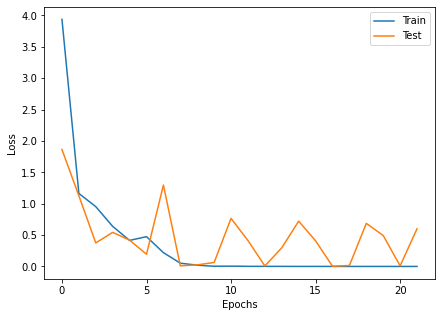

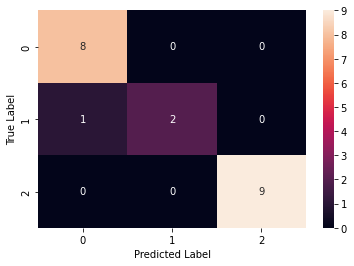

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.3352902687731243, Test Loss: 2.3909759521484375
Epoch 2-- Train Loss:1.0370976343041374, Test Loss: 2.2304253578186035
Epoch 3-- Train Loss:0.7246965964635214, Test Loss: 2.444366693496704
Epoch 4-- Train Loss:0.3744150880014613, Test Loss: 0.8787715435028076
Epoch 5-- Train Loss:0.5725138183417064, Test Loss: 1.052122712135315
Epoch 6-- Train Loss:1.1261795475369407, Test Loss: 0.25263628363609314
Epoch 7-- Train Loss:0.2757948532345749, Test Loss: 0.9147964715957642
Epoch 8-- Train Loss:0.12297375956993728, Test Loss: 1.010460376739502
Epoch 9-- Train Loss:0.1135346611873025, Test Loss: 1.3301275968551636
Epoch 10-- Train Loss:0.05694931958402906, Test Loss: 2.6027257442474365
Epoch 11-- Train Loss:0.007997879170857015, Test Loss: 0.9147502183914185
Epoch 12-- Train Loss:0.006741258671917464, Test Loss: 0.019155915826559067
Epoch 13-- Train Loss:0.0051657871237174345, Test Loss: 2.588637590408325
Epoch 14

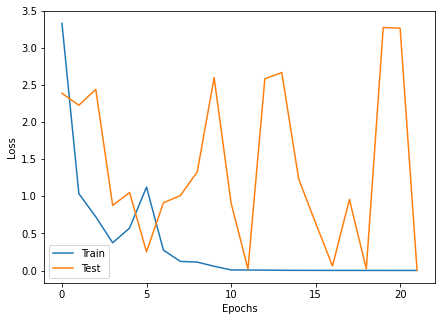

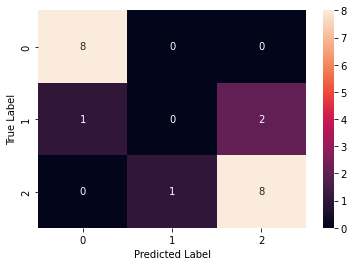

Starting testing
Training Complete
{'0': {'f1-score': '0.878±0.069',
       'precision': '0.863±0.085',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.45±0.283',
       'precision': '0.57±0.399',
       'recall': '0.417±0.269',
       'support': 4},
 '2': {'f1-score': '0.821±0.106',
       'precision': '0.817±0.118',
       'recall': '0.831±0.116',
       'support': 9},
 'accuracy': '0.795±0.096',
 'macro avg': {'f1-score': '0.716±0.126',
               'precision': '0.75±0.159',
               'recall': '0.716±0.114',
               'support': 21},
 'weighted avg': {'f1-score': '0.786±0.095',
                  'precision': '0.796±0.104',
                  'recall': '0.795±0.096',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0011, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.2240663170814514, Test Loss: 5.673562049865723
Epoch 2-- Train Loss:1.4502891798814137, Test Loss: 3.8017470836639404
Epoch 3-- Train L

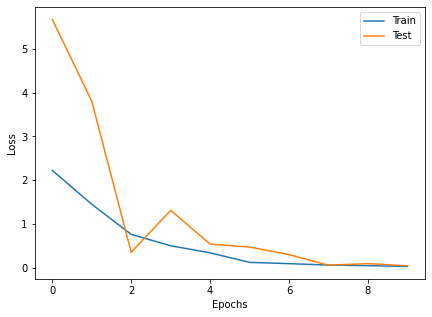

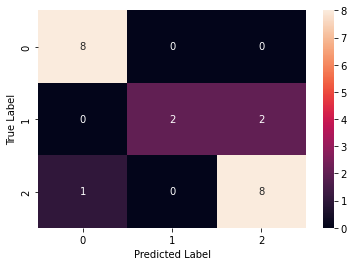

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.8806013564268749, Test Loss: 5.504518508911133
Epoch 2-- Train Loss:1.7798954745133717, Test Loss: 3.8795113563537598
Epoch 3-- Train Loss:1.4804382522900899, Test Loss: 4.914045333862305
Epoch 4-- Train Loss:1.2129620512326558, Test Loss: 3.5111210346221924
Epoch 5-- Train Loss:1.0592738166451454, Test Loss: 1.0587774515151978
Epoch 6-- Train Loss:0.34772801399230957, Test Loss: 0.640056848526001
Epoch 7-- Train Loss:0.2362851221114397, Test Loss: 0.24790066480636597
Epoch 8-- Train Loss:0.15044928466280302, Test Loss: 0.3874967694282532
Epoch 9-- Train Loss:0.07580623837808768, Test Loss: 0.32281798124313354
Epoch 10-- Train Loss:0.0705672378341357, Test Loss: 0.18000046908855438


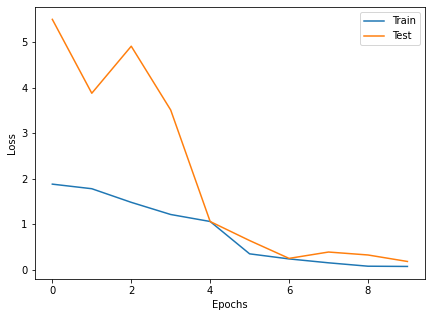

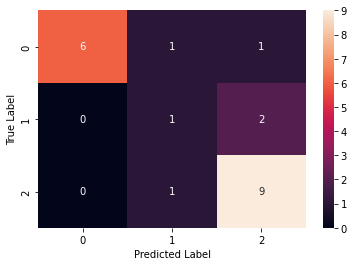

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.0790104071299234, Test Loss: 0.7122461795806885
Epoch 2-- Train Loss:1.1752313524484634, Test Loss: 5.368846893310547
Epoch 3-- Train Loss:0.872167706489563, Test Loss: 0.0013107375707477331
Epoch 4-- Train Loss:0.8455890665451685, Test Loss: 2.6480088233947754
Epoch 5-- Train Loss:0.2432843210796515, Test Loss: 0.5926899313926697
Epoch 6-- Train Loss:0.08413625570635001, Test Loss: 0.761603832244873
Epoch 7-- Train Loss:0.06133804035683473, Test Loss: 0.3823922872543335
Epoch 8-- Train Loss:0.035080669835830726, Test Loss: 0.5444396734237671
Epoch 9-- Train Loss:0.031065212252239387, Test Loss: 0.5675572752952576
Epoch 10-- Train Loss:0.02756005898118019, Test Loss: 0.6152137517929077


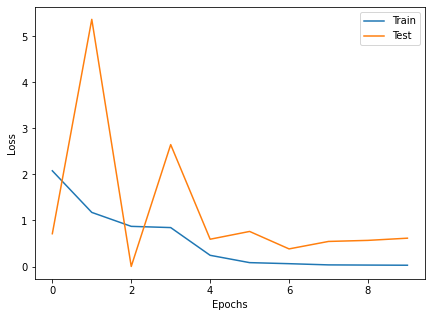

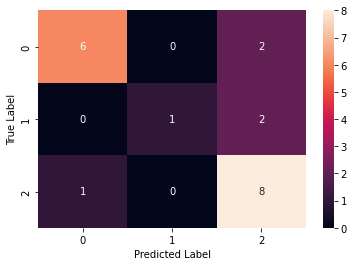

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.94939790169398, Test Loss: 2.9554741382598877
Epoch 2-- Train Loss:1.252785325050354, Test Loss: 1.9091826677322388
Epoch 3-- Train Loss:0.8303979684909185, Test Loss: 0.4945485293865204
Epoch 4-- Train Loss:0.3607414315144221, Test Loss: 0.8339879512786865
Epoch 5-- Train Loss:0.25543532334268093, Test Loss: 0.21748854219913483
Epoch 6-- Train Loss:0.09106527641415596, Test Loss: 0.03357141464948654
Epoch 7-- Train Loss:0.07813108231251438, Test Loss: 0.32435286045074463
Epoch 8-- Train Loss:0.06065039957563082, Test Loss: 0.038398388773202896
Epoch 9-- Train Loss:0.05073150433599949, Test Loss: 0.08971843123435974
Epoch 10-- Train Loss:0.03898462435851494, Test Loss: 0.06410007178783417


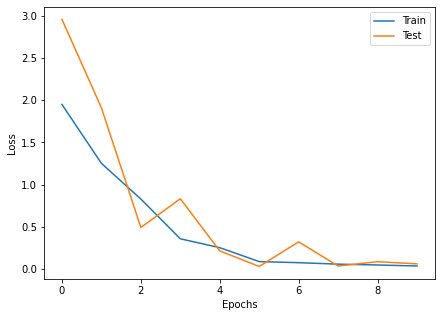

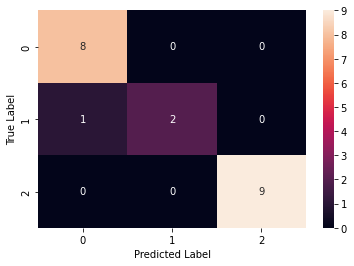

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.189341902732849, Test Loss: 2.747893810272217
Epoch 2-- Train Loss:1.0321860512097676, Test Loss: 0.7598842978477478
Epoch 3-- Train Loss:0.46841874221960705, Test Loss: 0.7857135534286499
Epoch 4-- Train Loss:0.3316442494591077, Test Loss: 3.228074073791504
Epoch 5-- Train Loss:0.18699050197998682, Test Loss: 1.0168137550354004
Epoch 6-- Train Loss:0.09540220598379771, Test Loss: 1.1687779426574707
Epoch 7-- Train Loss:0.06951892996827762, Test Loss: 1.0578207969665527
Epoch 8-- Train Loss:0.05146812771757444, Test Loss: 0.1737631857395172
Epoch 9-- Train Loss:0.04561572025219599, Test Loss: 0.4250350892543793
Epoch 10-- Train Loss:0.02874981379136443, Test Loss: 1.885600209236145


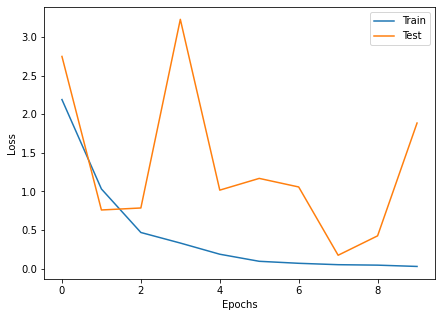

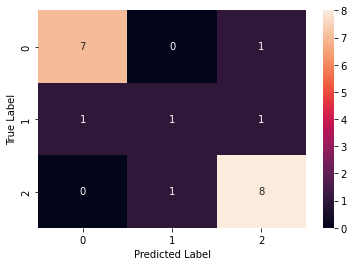

Starting testing
Training Complete
{'0': {'f1-score': '0.895±0.069',
       'precision': '0.924±0.063',
       'recall': '0.875±0.112',
       'support': 8},
 '1': {'f1-score': '0.58±0.238',
       'precision': '0.767±0.291',
       'recall': '0.5±0.258',
       'support': 4},
 '2': {'f1-score': '0.853±0.079',
       'precision': '0.803±0.11',
       'recall': '0.913±0.044',
       'support': 9},
 'accuracy': '0.834±0.091',
 'macro avg': {'f1-score': '0.776±0.123',
               'precision': '0.831±0.112',
               'recall': '0.763±0.129',
               'support': 21},
 'weighted avg': {'f1-score': '0.827±0.093',
                  'precision': '0.847±0.083',
                  'recall': '0.834±0.091',
                  'support': 21}}
{'num_epochs': 22, 'lr': 0.0091, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.790132034392584, Test Loss: 0.03693084418773651
Epoch 2-- Train Loss:1.365779378584453, Test Loss: 0.13427196443080902
Epoch 3-- Train 

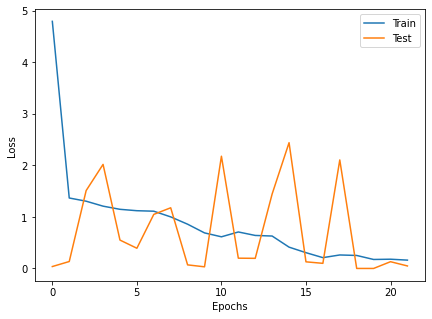

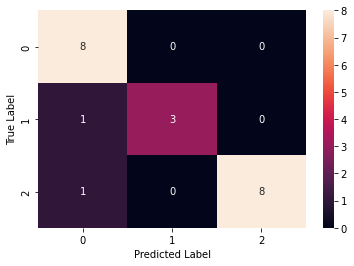

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.374033116158985, Test Loss: 0.06459679454565048
Epoch 2-- Train Loss:1.3986844193367731, Test Loss: 1.7854318618774414
Epoch 3-- Train Loss:1.264977460815793, Test Loss: 1.326210618019104
Epoch 4-- Train Loss:1.0548570922442846, Test Loss: 1.30666184425354
Epoch 5-- Train Loss:1.1299673162755512, Test Loss: 2.74411678314209
Epoch 6-- Train Loss:1.0017246220793043, Test Loss: 2.383610963821411
Epoch 7-- Train Loss:1.1218560934066772, Test Loss: 0.20851045846939087
Epoch 8-- Train Loss:0.9846577757880801, Test Loss: 1.7820461988449097
Epoch 9-- Train Loss:0.9457825918992361, Test Loss: 0.44533395767211914
Epoch 10-- Train Loss:0.9620973183995202, Test Loss: 0.44902554154396057
Epoch 11-- Train Loss:0.9526144315799078, Test Loss: 1.0008083581924438
Epoch 12-- Train Loss:0.9609266916910807, Test Loss: 0.3402489125728607
Epoch 13-- Train Loss:0.8647776089963459, Test Loss: 1.5913466215133667
Epoch 14-- Train Los

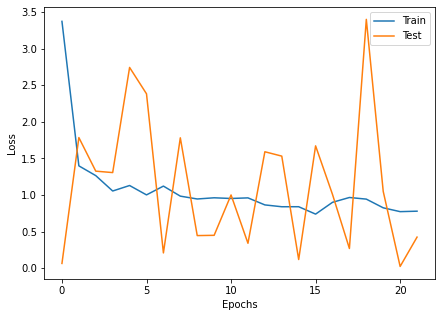

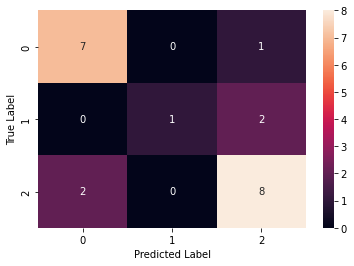

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.000180741151174, Test Loss: 1.8490300178527832
Epoch 2-- Train Loss:1.2905511487097967, Test Loss: 0.6829116940498352
Epoch 3-- Train Loss:1.36535648504893, Test Loss: 1.2761614322662354
Epoch 4-- Train Loss:1.1410043665340968, Test Loss: 0.6948851943016052
Epoch 5-- Train Loss:1.0962352993942441, Test Loss: 1.2101869583129883
Epoch 6-- Train Loss:0.8889085096972329, Test Loss: 0.5766143202781677
Epoch 7-- Train Loss:0.8073085943857828, Test Loss: 0.9368574023246765
Epoch 8-- Train Loss:0.9455766734622774, Test Loss: 0.7840688228607178
Epoch 9-- Train Loss:0.7203603216579982, Test Loss: 0.5954319834709167
Epoch 10-- Train Loss:0.5705159874189467, Test Loss: 1.1996852159500122
Epoch 11-- Train Loss:1.061456158579815, Test Loss: 0.5827199816703796
Epoch 12-- Train Loss:1.0015897012892223, Test Loss: 0.7382579445838928
Epoch 13-- Train Loss:0.9258465837864649, Test Loss: 0.4834173619747162
Epoch 14-- Train Los

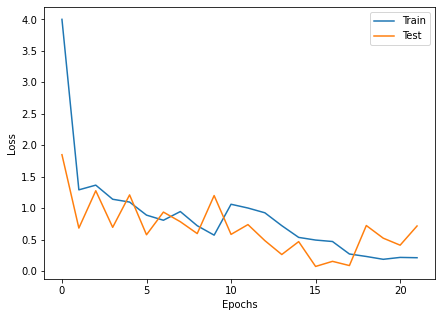

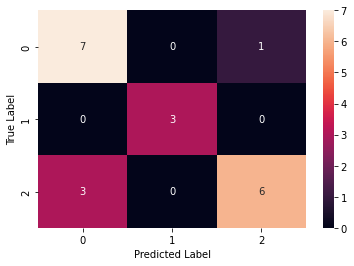

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:8.811135033766428, Test Loss: 3.8840746879577637
Epoch 2-- Train Loss:1.2931372608457292, Test Loss: 1.3224631547927856
Epoch 3-- Train Loss:1.4688227914628529, Test Loss: 1.1166964769363403
Epoch 4-- Train Loss:1.3110601873624892, Test Loss: 1.3568933010101318
Epoch 5-- Train Loss:1.1864532317434038, Test Loss: 1.5760544538497925
Epoch 6-- Train Loss:1.1168015542484464, Test Loss: 0.7550601363182068
Epoch 7-- Train Loss:1.1479244700499944, Test Loss: 1.3163816928863525
Epoch 8-- Train Loss:1.1656982813562666, Test Loss: 1.1400431394577026
Epoch 9-- Train Loss:1.165211714449383, Test Loss: 0.8872321248054504
Epoch 10-- Train Loss:1.1526933511098225, Test Loss: 1.0224558115005493
Epoch 11-- Train Loss:1.135032438096546, Test Loss: 1.4778456687927246
Epoch 12-- Train Loss:1.1308516434260778, Test Loss: 1.002242922782898
Epoch 13-- Train Loss:1.1151024188314165, Test Loss: 1.068035364151001
Epoch 14-- Train Loss

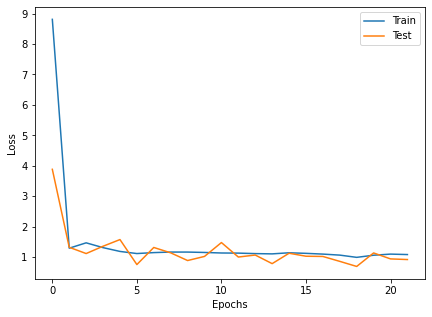

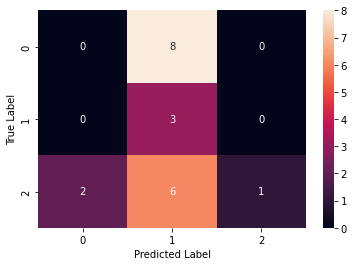

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:5.780140431154342, Test Loss: 2.7626686096191406
Epoch 2-- Train Loss:2.407476876463209, Test Loss: 3.681650400161743
Epoch 3-- Train Loss:1.3458753994532995, Test Loss: 3.495939254760742
Epoch 4-- Train Loss:1.3104250374294462, Test Loss: 1.1609930992126465
Epoch 5-- Train Loss:1.2077198908442544, Test Loss: 1.0839533805847168
Epoch 6-- Train Loss:1.190178053719657, Test Loss: 1.2654863595962524
Epoch 7-- Train Loss:1.1802047264008295, Test Loss: 1.0743036270141602
Epoch 8-- Train Loss:1.128849514893123, Test Loss: 1.09819495677948
Epoch 9-- Train Loss:1.1223517202195668, Test Loss: 1.2235007286071777
Epoch 10-- Train Loss:1.0641037566321236, Test Loss: 1.4592233896255493
Epoch 11-- Train Loss:1.099819458666302, Test Loss: 0.9174209237098694
Epoch 12-- Train Loss:1.0817342684382485, Test Loss: 0.9076240062713623
Epoch 13-- Train Loss:1.1377734428360349, Test Loss: 1.2101871967315674
Epoch 14-- Train Loss:1.0

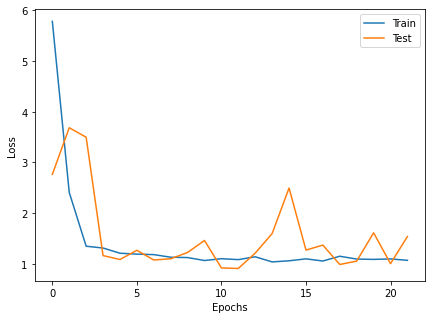

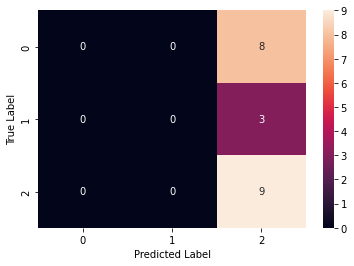

Starting testing
Training Complete
{'0': {'f1-score': '0.498±0.408',
       'precision': '0.456±0.373',
       'recall': '0.55±0.451',
       'support': 8},
 '1': {'f1-score': '0.526±0.368',
       'precision': '0.632±0.454',
       'recall': '0.617±0.393',
       'support': 4},
 '2': {'f1-score': '0.655±0.249',
       'precision': '0.807±0.205',
       'recall': '0.693±0.311',
       'support': 9},
 'accuracy': '0.623±0.26',
 'macro avg': {'f1-score': '0.56±0.315',
               'precision': '0.631±0.308',
               'recall': '0.62±0.231',
               'support': 21},
 'weighted avg': {'f1-score': '0.572±0.308',
                  'precision': '0.64±0.265',
                  'recall': '0.623±0.26',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0081, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.533042220842271, Test Loss: 0.007045899052172899
Epoch 2-- Train Loss:1.5512461236545019, Test Loss: 0.16542862355709076
Epoch 3-- Train 

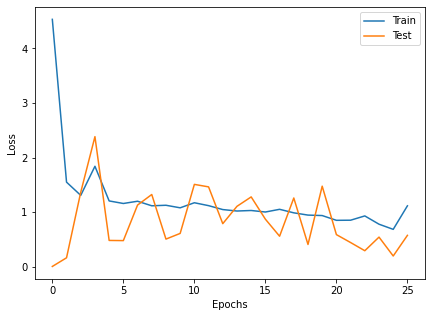

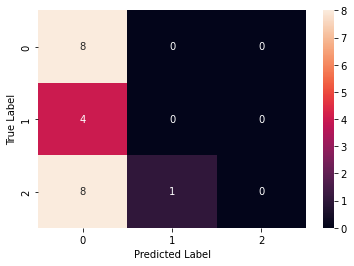

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:5.177853010949635, Test Loss: 1.7404896020889282
Epoch 2-- Train Loss:1.1395289245105924, Test Loss: 1.8739720582962036
Epoch 3-- Train Loss:1.2168819223131453, Test Loss: 0.6696029305458069
Epoch 4-- Train Loss:1.1293765192940122, Test Loss: 1.139714241027832
Epoch 5-- Train Loss:1.1329374370120822, Test Loss: 1.1692521572113037
Epoch 6-- Train Loss:1.1465923672630673, Test Loss: 0.9432298541069031
Epoch 7-- Train Loss:1.1371518912769498, Test Loss: 1.157405138015747
Epoch 8-- Train Loss:1.1138310829798381, Test Loss: 0.8010974526405334
Epoch 9-- Train Loss:1.104768259184701, Test Loss: 1.4315929412841797
Epoch 10-- Train Loss:1.1045771894000826, Test Loss: 1.1247718334197998
Epoch 11-- Train Loss:1.1031675849642073, Test Loss: 0.9086815118789673
Epoch 12-- Train Loss:1.087078917594183, Test Loss: 1.7908916473388672
Epoch 13-- Train Loss:1.096882695243472, Test Loss: 1.1917308568954468
Epoch 14-- Train Loss:

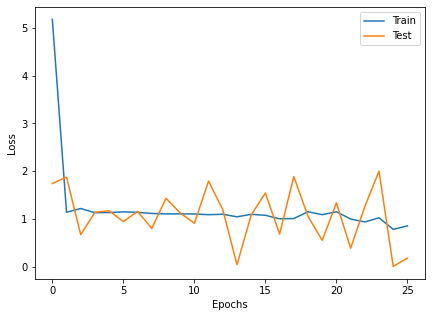

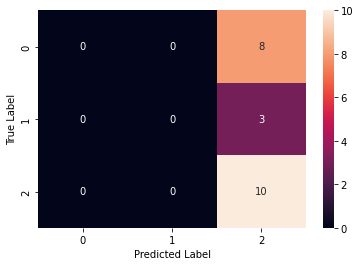

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:6.500522324017116, Test Loss: 2.2266368865966797
Epoch 2-- Train Loss:1.3071165397053672, Test Loss: 0.7935450077056885
Epoch 3-- Train Loss:1.291695475578308, Test Loss: 1.0296134948730469
Epoch 4-- Train Loss:1.2219655825978233, Test Loss: 1.7395148277282715
Epoch 5-- Train Loss:1.294355375426156, Test Loss: 1.0674107074737549
Epoch 6-- Train Loss:1.2179634429159618, Test Loss: 1.101499319076538
Epoch 7-- Train Loss:1.1400696890694755, Test Loss: 0.7451738119125366
Epoch 8-- Train Loss:1.1428684109733218, Test Loss: 1.098219633102417
Epoch 9-- Train Loss:1.1459785387629555, Test Loss: 1.0238288640975952
Epoch 10-- Train Loss:1.1116163162958055, Test Loss: 0.9375367760658264
Epoch 11-- Train Loss:1.1173358956972759, Test Loss: 0.9388852715492249
Epoch 12-- Train Loss:1.0950347128368558, Test Loss: 1.2489330768585205
Epoch 13-- Train Loss:1.1432250511078608, Test Loss: 1.149014949798584
Epoch 14-- Train Loss:

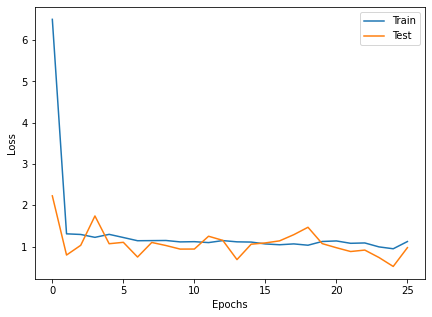

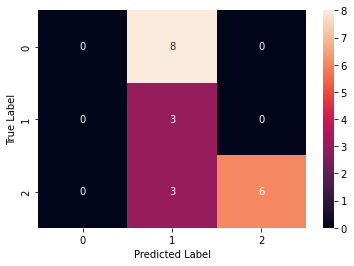

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:4.548010153429849, Test Loss: 1.5405381917953491
Epoch 2-- Train Loss:1.1823376956440153, Test Loss: 0.6926586627960205
Epoch 3-- Train Loss:1.227741076832726, Test Loss: 1.255012035369873
Epoch 4-- Train Loss:1.160634350209009, Test Loss: 1.0423808097839355
Epoch 5-- Train Loss:1.161148644628979, Test Loss: 1.327209234237671
Epoch 6-- Train Loss:1.1354936474845523, Test Loss: 0.9002664685249329
Epoch 7-- Train Loss:1.1050003000668116, Test Loss: 1.1217060089111328
Epoch 8-- Train Loss:1.108032484849294, Test Loss: 1.6175119876861572
Epoch 9-- Train Loss:1.0585327034904843, Test Loss: 0.8466384410858154
Epoch 10-- Train Loss:1.0489223514284407, Test Loss: 0.939608097076416
Epoch 11-- Train Loss:0.9677495615822929, Test Loss: 2.3999414443969727
Epoch 12-- Train Loss:1.1679648011922836, Test Loss: 1.175421953201294
Epoch 13-- Train Loss:1.0491449946448916, Test Loss: 1.1630187034606934
Epoch 14-- Train Loss:0.9

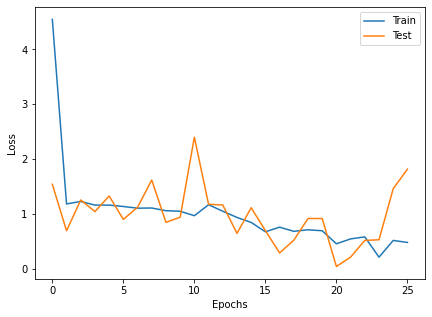

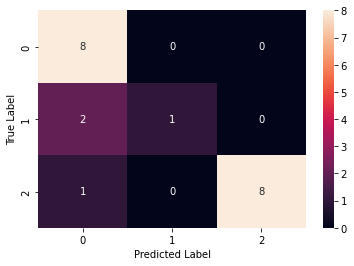

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.408335314620109, Test Loss: 1.8412038087844849
Epoch 2-- Train Loss:1.2971038818359375, Test Loss: 1.0862367153167725
Epoch 3-- Train Loss:3.8027069057737077, Test Loss: 4.249325275421143
Epoch 4-- Train Loss:3.182078735814208, Test Loss: 1.8859107494354248
Epoch 5-- Train Loss:1.1650136028017317, Test Loss: 1.0317447185516357
Epoch 6-- Train Loss:1.0876555953707014, Test Loss: 1.3055546283721924
Epoch 7-- Train Loss:0.9993787180809748, Test Loss: 1.773871898651123
Epoch 8-- Train Loss:0.9792301399367196, Test Loss: 0.6953397393226624
Epoch 9-- Train Loss:0.8633092457339877, Test Loss: 1.025573492050171
Epoch 10-- Train Loss:0.8343939710231054, Test Loss: 1.3744930028915405
Epoch 11-- Train Loss:0.8382669843378521, Test Loss: 0.7934476733207703
Epoch 12-- Train Loss:0.8130929626169658, Test Loss: 2.3403701782226562
Epoch 13-- Train Loss:0.8395707252479735, Test Loss: 0.9150518774986267
Epoch 14-- Train Loss

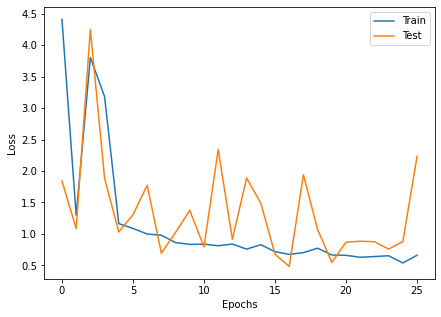

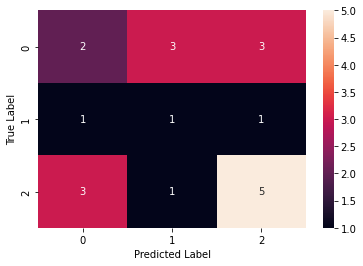

Starting testing
Training Complete
{'0': {'f1-score': '0.344±0.328',
       'precision': '0.305±0.277',
       'recall': '0.45±0.458',
       'support': 8},
 '1': {'f1-score': '0.221±0.197',
       'precision': '0.283±0.37',
       'recall': '0.333±0.365',
       'support': 4},
 '2': {'f1-score': '0.559±0.3',
       'precision': '0.57±0.351',
       'recall': '0.6±0.334',
       'support': 9},
 'accuracy': '0.501±0.153',
 'macro avg': {'f1-score': '0.375±0.19',
               'precision': '0.386±0.264',
               'recall': '0.461±0.146',
               'support': 21},
 'weighted avg': {'f1-score': '0.424±0.193',
                  'precision': '0.422±0.239',
                  'recall': '0.501±0.153',
                  'support': 21}}
{'num_epochs': 46, 'lr': 0.0021, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:3.1083014806111655, Test Loss: 4.133660793304443
Epoch 2-- Train Loss:3.0478397210439048, Test Loss: 2.631638526916504
Epoch 3-- Train Loss:

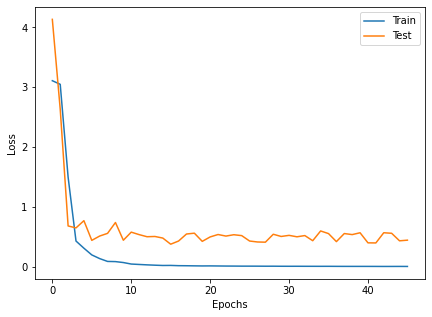

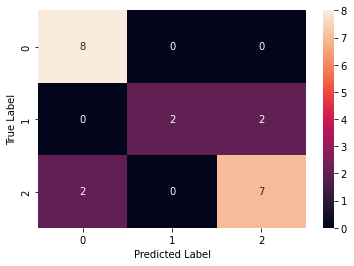

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.2242266734441123, Test Loss: 2.5100574493408203
Epoch 2-- Train Loss:2.6489717165629068, Test Loss: 3.3501226902008057
Epoch 3-- Train Loss:2.8224210341771445, Test Loss: 1.6927036046981812
Epoch 4-- Train Loss:0.6354899456103643, Test Loss: 0.7628096342086792
Epoch 5-- Train Loss:0.408596138159434, Test Loss: 0.9675823450088501
Epoch 6-- Train Loss:0.25548545519510907, Test Loss: 0.7317124009132385
Epoch 7-- Train Loss:0.14607466757297516, Test Loss: 0.7131307721138
Epoch 8-- Train Loss:0.11225852370262146, Test Loss: 0.6408599019050598
Epoch 9-- Train Loss:0.06986820325255394, Test Loss: 0.7187049388885498
Epoch 10-- Train Loss:0.04672547057271004, Test Loss: 0.5955101251602173
Epoch 11-- Train Loss:0.039193437745173774, Test Loss: 0.5553524494171143
Epoch 12-- Train Loss:0.02919379559655984, Test Loss: 0.5857849717140198
Epoch 13-- Train Loss:0.02915547974407673, Test Loss: 0.6500800848007202
Epoch 14-- 

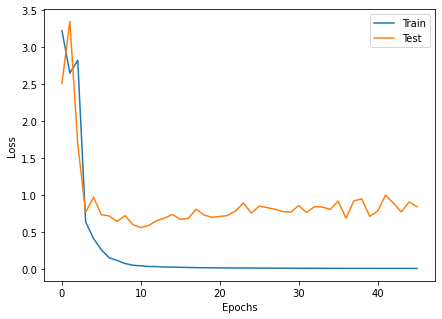

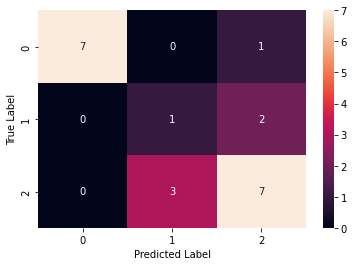

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.3296632369359336, Test Loss: 3.614955186843872
Epoch 2-- Train Loss:1.7262298663457234, Test Loss: 1.1613528728485107
Epoch 3-- Train Loss:0.6798042456309, Test Loss: 1.165759801864624
Epoch 4-- Train Loss:0.3420703013737996, Test Loss: 0.8176339268684387
Epoch 5-- Train Loss:1.1181636253992717, Test Loss: 1.0262833833694458
Epoch 6-- Train Loss:0.13042985647916794, Test Loss: 0.560407280921936
Epoch 7-- Train Loss:0.09811652451753616, Test Loss: 0.7513458728790283
Epoch 8-- Train Loss:0.0665555124481519, Test Loss: 0.7196555137634277
Epoch 9-- Train Loss:0.04605548828840256, Test Loss: 0.8635951280593872
Epoch 10-- Train Loss:0.031090866774320602, Test Loss: 0.6990860104560852
Epoch 11-- Train Loss:0.02530466951429844, Test Loss: 0.7639085054397583
Epoch 12-- Train Loss:0.0215245612586538, Test Loss: 0.7505201101303101
Epoch 13-- Train Loss:0.01708439737558365, Test Loss: 0.8279762268066406
Epoch 14-- Trai

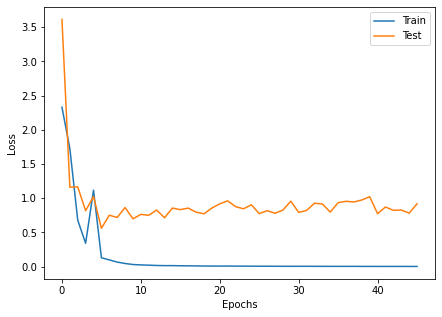

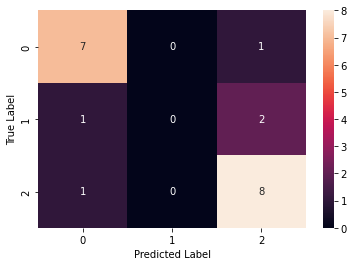

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.050236145655314, Test Loss: 6.373758792877197
Epoch 2-- Train Loss:2.24671870470047, Test Loss: 4.249804496765137
Epoch 3-- Train Loss:2.439667562643687, Test Loss: 0.5971335768699646
Epoch 4-- Train Loss:0.4705537756284078, Test Loss: 0.6101810932159424
Epoch 5-- Train Loss:0.31113500396410626, Test Loss: 0.4183865785598755
Epoch 6-- Train Loss:0.17854016025861105, Test Loss: 0.337398886680603
Epoch 7-- Train Loss:0.10799039403597514, Test Loss: 0.3023830056190491
Epoch 8-- Train Loss:0.08492880314588547, Test Loss: 0.3364023268222809
Epoch 9-- Train Loss:0.06898911421497662, Test Loss: 0.2979494035243988
Epoch 10-- Train Loss:0.05119388923048973, Test Loss: 0.30019721388816833
Epoch 11-- Train Loss:0.04332608605424563, Test Loss: 0.33474332094192505
Epoch 12-- Train Loss:0.03631685674190521, Test Loss: 0.3145315647125244
Epoch 13-- Train Loss:0.031069347634911537, Test Loss: 0.2544173002243042
Epoch 14-- 

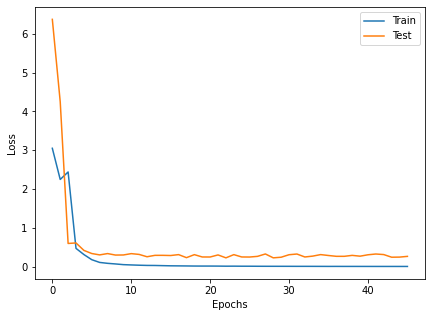

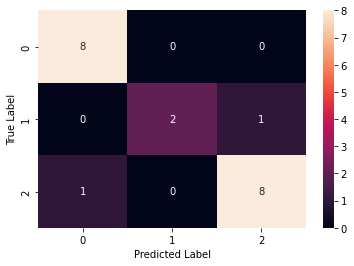

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.7946794827779136, Test Loss: 4.427530288696289
Epoch 2-- Train Loss:3.106628974278768, Test Loss: 2.817873477935791
Epoch 3-- Train Loss:1.6928975383440654, Test Loss: 0.8019936680793762
Epoch 4-- Train Loss:0.46833235025405884, Test Loss: 0.9370095133781433
Epoch 5-- Train Loss:0.41667675971984863, Test Loss: 0.8169214129447937
Epoch 6-- Train Loss:0.21344375113646188, Test Loss: 0.6882111430168152
Epoch 7-- Train Loss:0.13846629858016968, Test Loss: 0.6263523697853088
Epoch 8-- Train Loss:0.07661234835783641, Test Loss: 0.6169208288192749
Epoch 9-- Train Loss:0.06276408831278484, Test Loss: 0.5519640445709229
Epoch 10-- Train Loss:0.059745173901319504, Test Loss: 0.6165412664413452
Epoch 11-- Train Loss:0.04388470451037089, Test Loss: 0.6141808032989502
Epoch 12-- Train Loss:0.03503730768958727, Test Loss: 0.6349517107009888
Epoch 13-- Train Loss:0.030828315764665604, Test Loss: 0.5133452415466309
Epoch 1

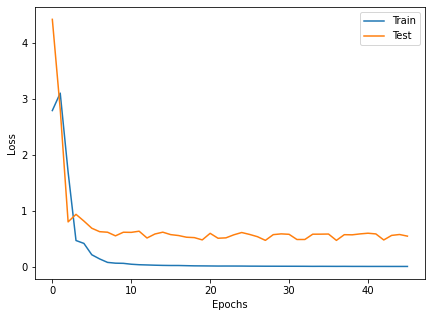

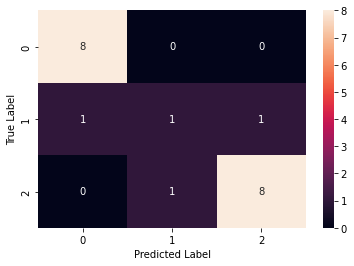

Starting testing
Training Complete
{'0': {'f1-score': '0.877±0.039',
       'precision': '0.868±0.078',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.47±0.34',
       'precision': '0.55±0.4',
       'recall': '0.433±0.327',
       'support': 4},
 '2': {'f1-score': '0.823±0.055',
       'precision': '0.802±0.073',
       'recall': '0.849±0.049',
       'support': 9},
 'accuracy': '0.805±0.067',
 'macro avg': {'f1-score': '0.724±0.129',
               'precision': '0.74±0.149',
               'recall': '0.727±0.117',
               'support': 21},
 'weighted avg': {'f1-score': '0.791±0.075',
                  'precision': '0.792±0.088',
                  'recall': '0.805±0.067',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0091, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.925232257161822, Test Loss: 0.07548466324806213
Epoch 2-- Train Loss:1.3760264799708413, Test Loss: 0.1099591851234436
Epoch 3-- Train Loss

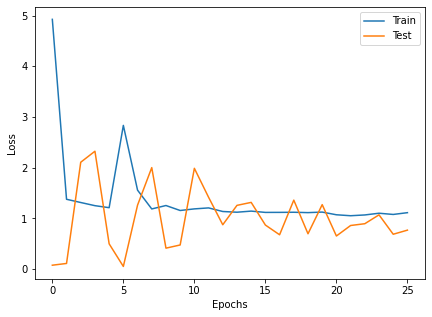

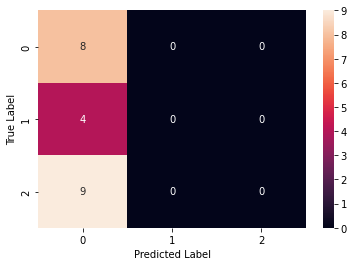

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:5.6052064789193015, Test Loss: 2.4007644653320312
Epoch 2-- Train Loss:1.1986171858651298, Test Loss: 2.179009437561035
Epoch 3-- Train Loss:1.2819934714408148, Test Loss: 0.551889955997467
Epoch 4-- Train Loss:1.150463757060823, Test Loss: 1.4003291130065918
Epoch 5-- Train Loss:1.1576394864491053, Test Loss: 1.284928321838379
Epoch 6-- Train Loss:1.1583124541101002, Test Loss: 0.8757086396217346
Epoch 7-- Train Loss:1.1389941431227184, Test Loss: 1.1406481266021729
Epoch 8-- Train Loss:1.1141949750128246, Test Loss: 0.7414941787719727
Epoch 9-- Train Loss:1.1039162107876368, Test Loss: 1.3099992275238037
Epoch 10-- Train Loss:1.1101044501577104, Test Loss: 1.1690125465393066
Epoch 11-- Train Loss:1.1176190092450096, Test Loss: 0.8949041962623596
Epoch 12-- Train Loss:1.1035256584485371, Test Loss: 1.3695569038391113
Epoch 13-- Train Loss:1.1033795192128135, Test Loss: 1.1327252388000488
Epoch 14-- Train Los

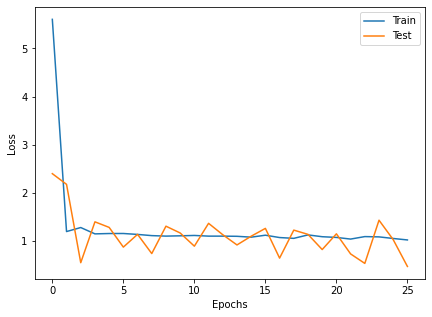

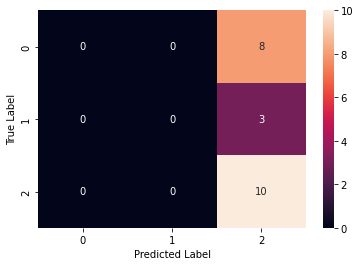

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:5.215193212032318, Test Loss: 2.189037322998047
Epoch 2-- Train Loss:1.343197376955123, Test Loss: 0.8269311189651489
Epoch 3-- Train Loss:1.2703642504555839, Test Loss: 1.00969660282135
Epoch 4-- Train Loss:1.1953392653238206, Test Loss: 1.5161267518997192
Epoch 5-- Train Loss:1.2178581328619094, Test Loss: 1.107029914855957
Epoch 6-- Train Loss:1.189723014831543, Test Loss: 1.1247552633285522
Epoch 7-- Train Loss:1.1334532272248041, Test Loss: 0.7495049834251404
Epoch 8-- Train Loss:1.1267230879692804, Test Loss: 1.113838791847229
Epoch 9-- Train Loss:1.1308000485102336, Test Loss: 1.048393964767456
Epoch 10-- Train Loss:1.1119732062021892, Test Loss: 0.9637541174888611
Epoch 11-- Train Loss:1.1161660381725855, Test Loss: 0.9454450011253357
Epoch 12-- Train Loss:1.0920822478476024, Test Loss: 1.4371310472488403
Epoch 13-- Train Loss:1.141689487865993, Test Loss: 1.165341854095459
Epoch 14-- Train Loss:1.109

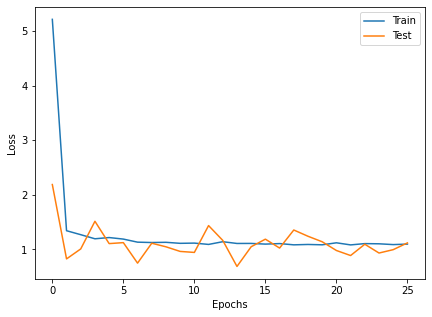

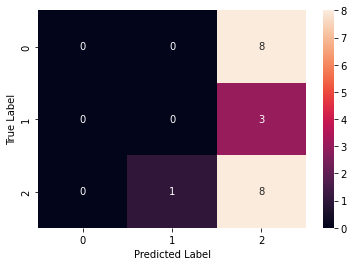

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:6.374716756491883, Test Loss: 1.9341926574707031
Epoch 2-- Train Loss:1.2303461063475836, Test Loss: 0.8831659555435181
Epoch 3-- Train Loss:1.366046672775632, Test Loss: 1.3508321046829224
Epoch 4-- Train Loss:1.168428605511075, Test Loss: 1.063652515411377
Epoch 5-- Train Loss:1.1678038920675005, Test Loss: 1.19537353515625
Epoch 6-- Train Loss:1.1466659761610485, Test Loss: 0.8703172206878662
Epoch 7-- Train Loss:1.1233339848972501, Test Loss: 1.116284966468811
Epoch 8-- Train Loss:1.128769570872897, Test Loss: 1.4971750974655151
Epoch 9-- Train Loss:1.1124021808306377, Test Loss: 0.9115071296691895
Epoch 10-- Train Loss:1.1125317102386838, Test Loss: 1.0157358646392822
Epoch 11-- Train Loss:1.0810391590708779, Test Loss: 1.4720300436019897
Epoch 12-- Train Loss:1.1131734479041326, Test Loss: 1.0431597232818604
Epoch 13-- Train Loss:1.0467506249745686, Test Loss: 0.8711010813713074
Epoch 14-- Train Loss:0.

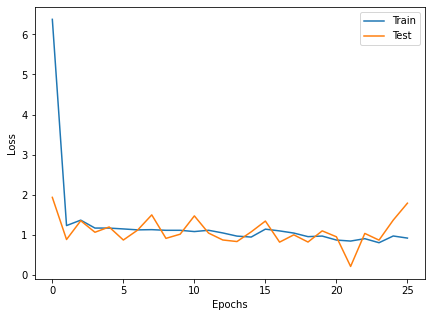

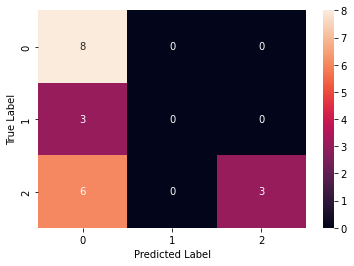

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.471905931120827, Test Loss: 1.5625535249710083
Epoch 2-- Train Loss:1.2407429161525907, Test Loss: 1.0669207572937012
Epoch 3-- Train Loss:1.1751854987371535, Test Loss: 0.939877450466156
Epoch 4-- Train Loss:1.079900398140862, Test Loss: 1.7341455221176147
Epoch 5-- Train Loss:1.0946043928464253, Test Loss: 1.046581506729126
Epoch 6-- Train Loss:1.0153505901495616, Test Loss: 2.0205016136169434
Epoch 7-- Train Loss:0.9175785538696107, Test Loss: 1.466183066368103
Epoch 8-- Train Loss:0.8965192692620414, Test Loss: 0.6953098773956299
Epoch 9-- Train Loss:0.7482201896962666, Test Loss: 2.72649884223938
Epoch 10-- Train Loss:0.831727113042559, Test Loss: 0.7537006735801697
Epoch 11-- Train Loss:0.552787782180877, Test Loss: 0.36362338066101074
Epoch 12-- Train Loss:0.6234905826193946, Test Loss: 0.8443087935447693
Epoch 13-- Train Loss:0.5057701220115026, Test Loss: 6.292565822601318
Epoch 14-- Train Loss:1.0

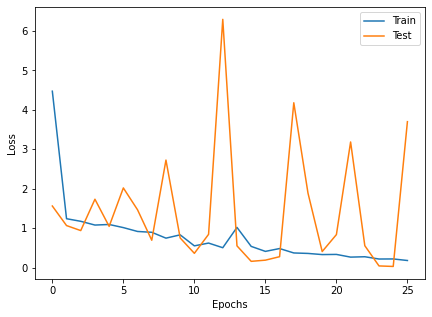

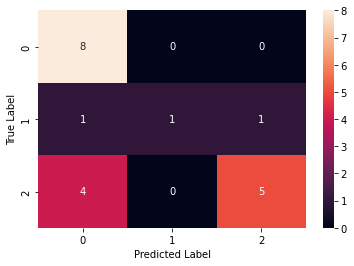

Starting testing
Training Complete
{'0': {'f1-score': '0.391±0.326',
       'precision': '0.293±0.251',
       'recall': '0.6±0.49',
       'support': 8},
 '1': {'f1-score': '0.1±0.2',
       'precision': '0.2±0.4',
       'recall': '0.067±0.133',
       'support': 4},
 '2': {'f1-score': '0.487±0.25',
       'precision': '0.552±0.347',
       'recall': '0.578±0.387',
       'support': 9},
 'accuracy': '0.511±0.109',
 'macro avg': {'f1-score': '0.326±0.173',
               'precision': '0.348±0.27',
               'recall': '0.415±0.116',
               'support': 21},
 'weighted avg': {'f1-score': '0.391±0.17',
                  'precision': '0.397±0.256',
                  'recall': '0.511±0.109',
                  'support': 21}}
{'num_epochs': 34, 'lr': 0.0061, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:7.062877158323924, Test Loss: 9.949264526367188
Epoch 2-- Train Loss:2.119471867879232, Test Loss: 2.7363250255584717
Epoch 3-- Train Loss:1.37597

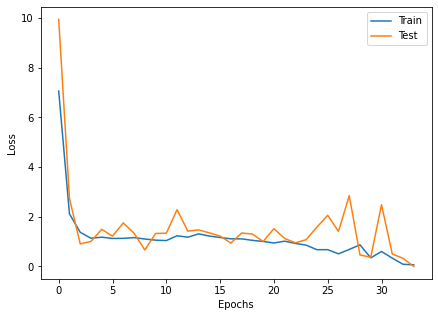

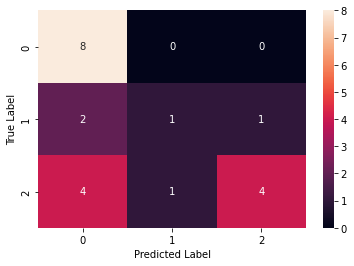

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:6.6977152824401855, Test Loss: 8.284775733947754
Epoch 2-- Train Loss:2.321562647819519, Test Loss: 1.6395188570022583
Epoch 3-- Train Loss:1.1891791423161824, Test Loss: 0.9553344249725342
Epoch 4-- Train Loss:1.3566527565320332, Test Loss: 2.5680689811706543
Epoch 5-- Train Loss:1.3109819889068604, Test Loss: 1.5224318504333496
Epoch 6-- Train Loss:1.2254623174667358, Test Loss: 0.8639211654663086
Epoch 7-- Train Loss:1.1622056861718495, Test Loss: 1.1125097274780273
Epoch 8-- Train Loss:1.2258254090944927, Test Loss: 1.5087913274765015
Epoch 9-- Train Loss:1.1052582263946533, Test Loss: 1.2715872526168823
Epoch 10-- Train Loss:1.1527570486068726, Test Loss: 1.5213035345077515
Epoch 11-- Train Loss:1.1208572785059612, Test Loss: 0.6547573208808899
Epoch 12-- Train Loss:1.0549141367276509, Test Loss: 1.8491472005844116
Epoch 13-- Train Loss:1.1311447819073994, Test Loss: 1.3215432167053223
Epoch 14-- Train L

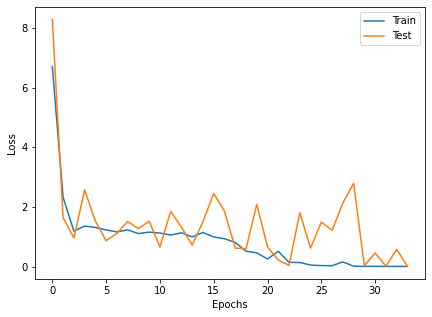

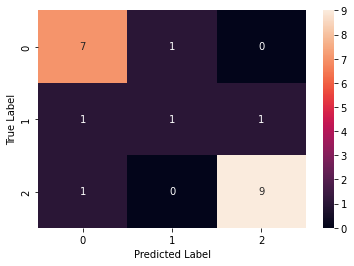

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.145153005917867, Test Loss: 6.461722373962402
Epoch 2-- Train Loss:1.3948152462641399, Test Loss: 1.7957435846328735
Epoch 3-- Train Loss:1.0557136038939159, Test Loss: 1.209469199180603
Epoch 4-- Train Loss:1.0562852229292428, Test Loss: 3.250671863555908
Epoch 5-- Train Loss:1.2853365043799083, Test Loss: 1.0320005416870117
Epoch 6-- Train Loss:0.5584106345971426, Test Loss: 1.0628485679626465
Epoch 7-- Train Loss:0.32888571669658023, Test Loss: 0.40668436884880066
Epoch 8-- Train Loss:0.20663351193070412, Test Loss: 2.9890458583831787
Epoch 9-- Train Loss:4.1376776744922, Test Loss: 4.241690158843994
Epoch 10-- Train Loss:1.1414417227109273, Test Loss: 1.0265514850616455
Epoch 11-- Train Loss:0.6450189550717672, Test Loss: 0.8849027156829834
Epoch 12-- Train Loss:0.6176114479700724, Test Loss: 0.17823444306850433
Epoch 13-- Train Loss:0.10183124989271164, Test Loss: 0.07640776038169861
Epoch 14-- Train L

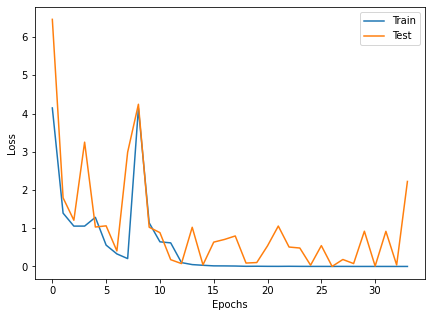

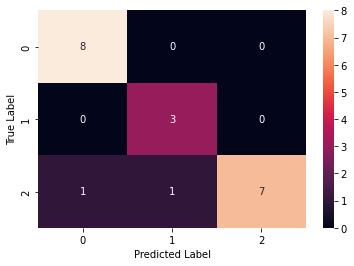

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:4.268822326906957, Test Loss: 3.6594576835632324
Epoch 2-- Train Loss:4.567173143227895, Test Loss: 1.6504548788070679
Epoch 3-- Train Loss:1.2464101612567902, Test Loss: 2.186081647872925
Epoch 4-- Train Loss:1.3110046585400899, Test Loss: 3.1356232166290283
Epoch 5-- Train Loss:1.5923330585161846, Test Loss: 0.8839538097381592
Epoch 6-- Train Loss:1.084003875652949, Test Loss: 1.623923897743225
Epoch 7-- Train Loss:1.0441384712855022, Test Loss: 0.5370418429374695
Epoch 8-- Train Loss:0.9432266453901926, Test Loss: 0.8530543446540833
Epoch 9-- Train Loss:0.7099559356768926, Test Loss: 0.20277385413646698
Epoch 10-- Train Loss:0.37007156014442444, Test Loss: 0.4742066562175751
Epoch 11-- Train Loss:0.8547950312495232, Test Loss: 0.9527685046195984
Epoch 12-- Train Loss:0.5242633372545242, Test Loss: 0.12879163026809692
Epoch 13-- Train Loss:0.23355220809268454, Test Loss: 0.025067491456866264
Epoch 14-- Trai

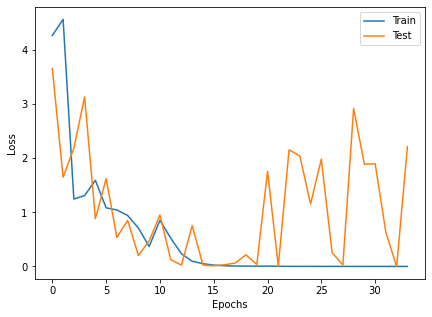

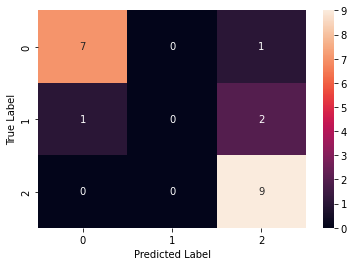

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.951772212982178, Test Loss: 4.354952812194824
Epoch 2-- Train Loss:2.0688639978567758, Test Loss: 2.3291776180267334
Epoch 3-- Train Loss:1.089896668990453, Test Loss: 1.650197148323059
Epoch 4-- Train Loss:1.0965187748273213, Test Loss: 2.466737747192383
Epoch 5-- Train Loss:1.484388828277588, Test Loss: 0.8344735503196716
Epoch 6-- Train Loss:1.1873785257339478, Test Loss: 1.5762075185775757
Epoch 7-- Train Loss:1.0466751754283905, Test Loss: 0.6332755088806152
Epoch 8-- Train Loss:0.8629205822944641, Test Loss: 0.869742751121521
Epoch 9-- Train Loss:1.017086923122406, Test Loss: 1.9046554565429688
Epoch 10-- Train Loss:0.6846323609352112, Test Loss: 0.9345974326133728
Epoch 11-- Train Loss:0.4534522667527199, Test Loss: 1.8505080938339233
Epoch 12-- Train Loss:0.8224012951056162, Test Loss: 1.6151171922683716
Epoch 13-- Train Loss:0.2603453211874391, Test Loss: 3.175774574279785
Epoch 14-- Train Loss:0.6

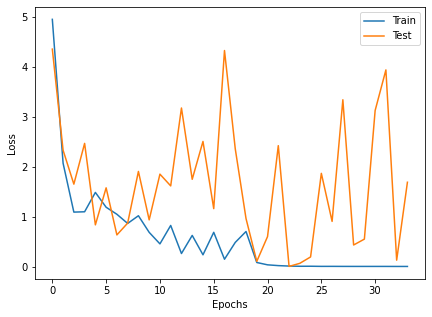

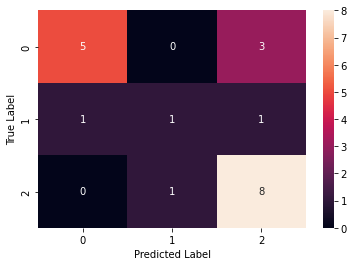

Starting testing
Training Complete
{'0': {'f1-score': '0.817±0.078',
       'precision': '0.767±0.125',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.398±0.273',
       'precision': '0.45±0.245',
       'recall': '0.383±0.332',
       'support': 4},
 '2': {'f1-score': '0.798±0.1',
       'precision': '0.871±0.123',
       'recall': '0.78±0.174',
       'support': 9},
 'accuracy': '0.766±0.092',
 'macro avg': {'f1-score': '0.671±0.128',
               'precision': '0.696±0.121',
               'recall': '0.688±0.129',
               'support': 21},
 'weighted avg': {'f1-score': '0.744±0.103',
                  'precision': '0.765±0.092',
                  'recall': '0.766±0.092',
                  'support': 21}}
{'num_epochs': 34, 'lr': 0.0021, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.961939122189175, Test Loss: 2.046924591064453
Epoch 2-- Train Loss:0.8255411833524704, Test Loss: 2.117443799972534
Epoch 3-- Train Loss:

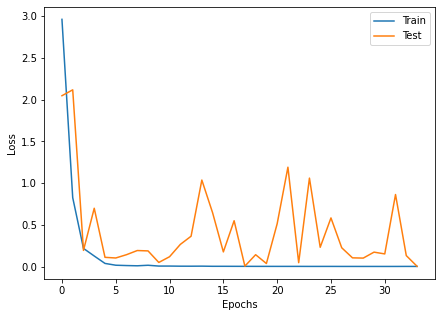

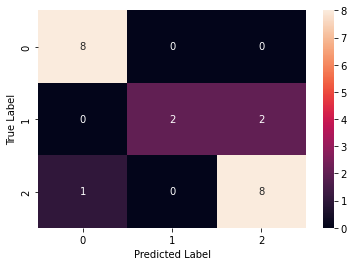

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.880916021086953, Test Loss: 6.5511932373046875
Epoch 2-- Train Loss:1.1767822151834315, Test Loss: 2.6747493743896484
Epoch 3-- Train Loss:0.9354583424600688, Test Loss: 0.534295916557312
Epoch 4-- Train Loss:0.3274007937447591, Test Loss: 1.865082025527954
Epoch 5-- Train Loss:0.4479649993167682, Test Loss: 1.391854166984558
Epoch 6-- Train Loss:0.1165325493467125, Test Loss: 0.11569179594516754
Epoch 7-- Train Loss:0.020836410282010383, Test Loss: 0.02947486750781536
Epoch 8-- Train Loss:0.06744025139646097, Test Loss: 1.8634033203125
Epoch 9-- Train Loss:0.005192360999485986, Test Loss: 0.09509048610925674
Epoch 10-- Train Loss:0.0035043804567645898, Test Loss: 0.9699644446372986
Epoch 11-- Train Loss:0.0029559538075277073, Test Loss: 1.0264593362808228
Epoch 12-- Train Loss:0.003136927542403679, Test Loss: 1.3692156076431274
Epoch 13-- Train Loss:0.0024911874206736684, Test Loss: 1.7560378313064575
Epoc

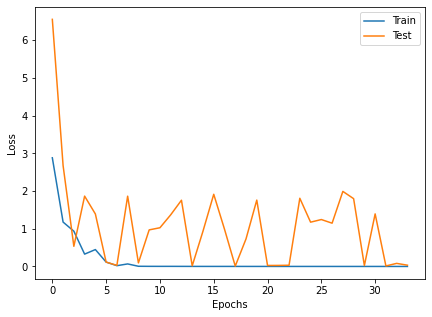

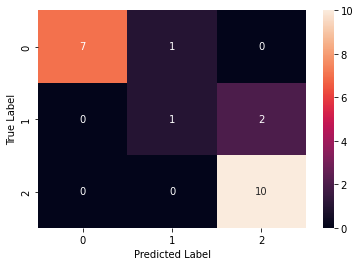

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:3.0365464795719492, Test Loss: 3.863934278488159
Epoch 2-- Train Loss:1.058243448084051, Test Loss: 1.8220970630645752
Epoch 3-- Train Loss:0.5267395411025394, Test Loss: 1.630138874053955
Epoch 4-- Train Loss:0.15811696055937896, Test Loss: 0.9314362406730652
Epoch 5-- Train Loss:0.07413524346934124, Test Loss: 0.7644688487052917
Epoch 6-- Train Loss:0.0737514439070682, Test Loss: 0.5868684649467468
Epoch 7-- Train Loss:0.01036525216080587, Test Loss: 0.11657843738794327
Epoch 8-- Train Loss:0.006498194193806161, Test Loss: 0.4499008059501648
Epoch 9-- Train Loss:0.004139997065067291, Test Loss: 0.0033737209159880877
Epoch 10-- Train Loss:0.0039605422749776735, Test Loss: 0.5712202191352844
Epoch 11-- Train Loss:0.0027800021396780557, Test Loss: 0.6659739017486572
Epoch 12-- Train Loss:0.0028679600641639395, Test Loss: 0.5537675023078918
Epoch 13-- Train Loss:0.002383381085978313, Test Loss: 0.12991632521152

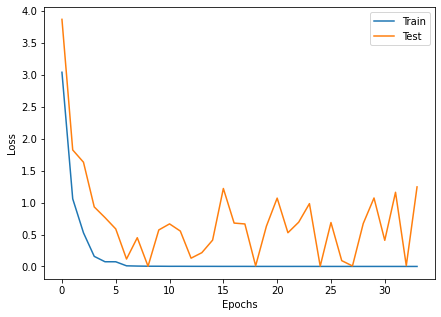

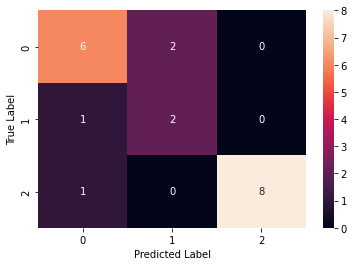

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.0718722207979723, Test Loss: 3.058619976043701
Epoch 2-- Train Loss:1.355410023169084, Test Loss: 1.6499998569488525
Epoch 3-- Train Loss:0.5321721272035078, Test Loss: 1.0233371257781982
Epoch 4-- Train Loss:0.20757217772982337, Test Loss: 0.6042748689651489
Epoch 5-- Train Loss:0.1576133854687214, Test Loss: 0.14063052833080292
Epoch 6-- Train Loss:0.04885275585746223, Test Loss: 0.628588080406189
Epoch 7-- Train Loss:0.012273677794093435, Test Loss: 0.002347400179132819
Epoch 8-- Train Loss:0.008530639958652582, Test Loss: 0.05027484521269798
Epoch 9-- Train Loss:0.00691325661980293, Test Loss: 0.0019452573033049703
Epoch 10-- Train Loss:0.005698704097250646, Test Loss: 0.12971210479736328
Epoch 11-- Train Loss:0.004008569394830953, Test Loss: 0.16544100642204285
Epoch 12-- Train Loss:0.0037733262235468083, Test Loss: 0.18432225286960602
Epoch 13-- Train Loss:0.003088482703209262, Test Loss: 0.0112274559

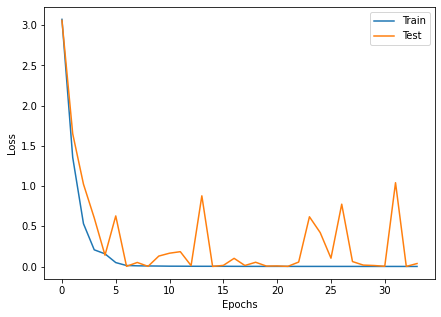

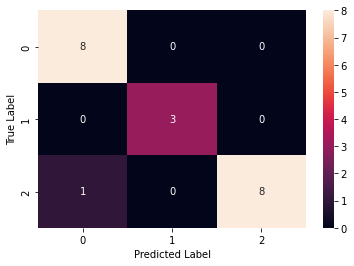

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.761146220293912, Test Loss: 7.221610069274902
Epoch 2-- Train Loss:1.718646214766936, Test Loss: 0.45501241087913513
Epoch 3-- Train Loss:0.28650949167257006, Test Loss: 1.8322724103927612
Epoch 4-- Train Loss:0.07576406645503911, Test Loss: 0.30573803186416626


In [ ]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='bit'
    results = train_model(name=name, dataset=dataset, k_folds =5,  **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )

## 3.4 Parametric Scattering Network

In [107]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-5,1e-2, 1e-3)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(10,50, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


In [108]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='scattering'
    results = train_model(name=name, dataset=dataset, k_folds =5,  **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )

{'num_epochs': 46, 'lr': 1e-05, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:0.9663238525390625, Test Loss: 1.1445127725601196
Epoch 2-- Train Loss:0.8974922696749369, Test Loss: 0.9095592498779297
Epoch 3-- Train Loss:0.75362096230189, Test Loss: 0.7695978283882141


KeyboardInterrupt: 